=== Test Metrics ===
SARIMA  -> RMSE: 0.305 | MAE: 0.255 | MAPE: 103.50%
MLP     -> RMSE: 0.266 | MAE: 0.219 | MAPE: 76.34%


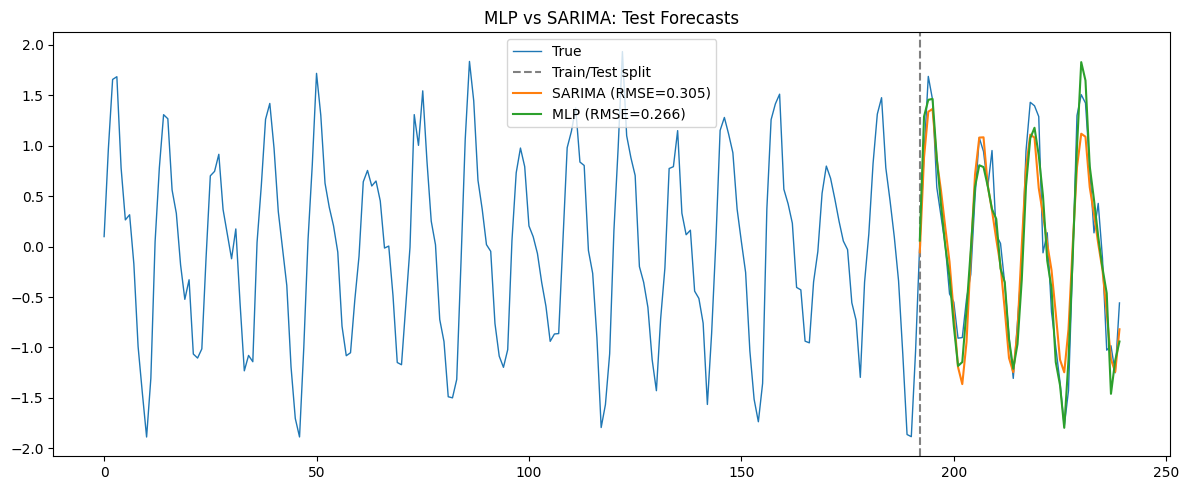

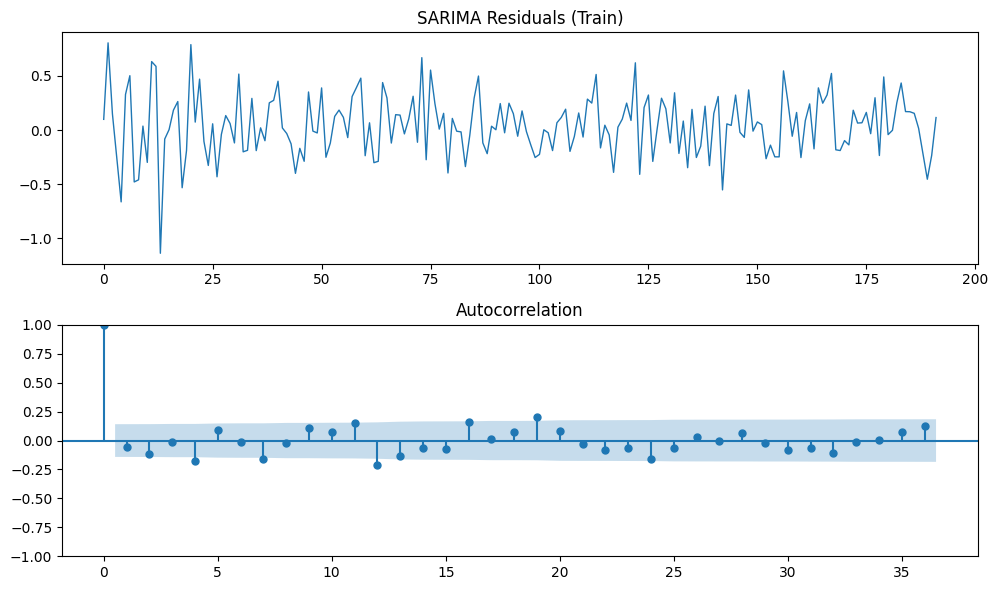

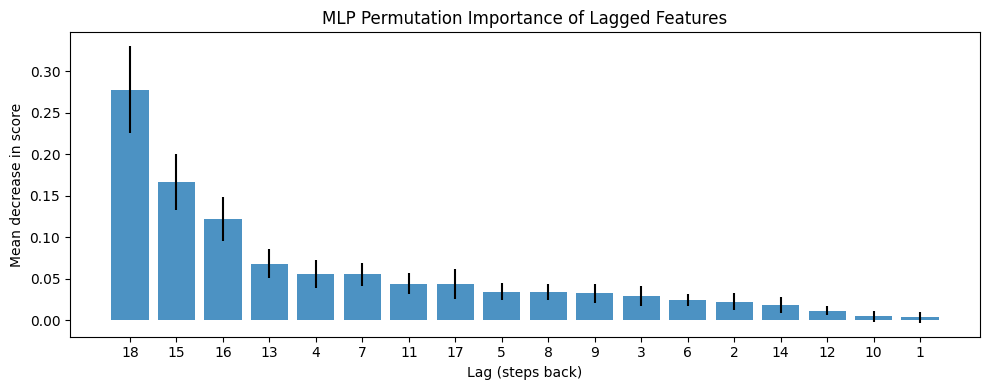

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
import statsmodels.api as sm

# -------------------------------
# 1) Create a mildly nonlinear seasonal series
# -------------------------------
np.random.seed(42)
n = 240  # ~20 seasons if s=12
s = 12   # seasonal period
t = np.arange(n)

# Base seasonal signal + a second harmonic + slight nonlinearity in amplitude
seasonal = 1.2*np.sin(2*np.pi*t/s) + 0.4*np.sin(2*np.pi*t/(s/2))
amplitude = 1 + 0.3*np.sin(2*np.pi*t/(s*3))                 # slowly varying amplitude
signal = amplitude * seasonal
y = signal + 0.2*np.random.randn(n)

# -------------------------------
# 2) Train / Test split
# -------------------------------
test_h = 48
train = y[:-test_h]
test  = y[-test_h:]
split = len(train)

# -------------------------------
# 3) SARIMA (seasonal ARIMA) fit + forecast
#    (Choose a reasonable order; tweak if needed)
# -------------------------------
sarima = sm.tsa.statespace.SARIMAX(
    train,
    order=(2,0,2),            # ARMA on non-seasonal
    seasonal_order=(1,0,1,s), # ARMA on seasonal
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_res = sarima.fit(disp=False)
sarima_fc = sarima_res.forecast(steps=test_h)  # 1-step-ahead style on holdout

# -------------------------------
# 4) MLP: lag features + fit + forecast
# -------------------------------
def make_lag_matrix(arr, lag):
    X, Y = [], []
    for i in range(lag, len(arr)):
        X.append(arr[i-lag:i])
        Y.append(arr[i])
    return np.array(X), np.array(Y)

lag = 18  # include >1 season of lags
X_all, Y_all = make_lag_matrix(y, lag)

# Align split for supervised arrays:
# last index usable as target in TRAIN = split-1 => usable rows = split - lag
cut = split - lag
X_train, Y_train = X_all[:cut], Y_all[:cut]
X_test,  Y_test  = X_all[cut:], Y_all[cut:]   # corresponds to the last test_h points

# Fit MLP
mlp = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu',
                   solver='adam', max_iter=2000, random_state=0)
mlp.fit(X_train, Y_train)
mlp_fc = mlp.predict(X_test)

# -------------------------------
# 5) Metrics
# -------------------------------
def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (np.maximum(np.abs(y_true), 1e-8)))) * 100
    return rmse, mae, mape

rmse_s, mae_s, mape_s = metrics(test, sarima_fc)
rmse_m, mae_m, mape_m = metrics(Y_test, mlp_fc)

print("=== Test Metrics ===")
print(f"SARIMA  -> RMSE: {rmse_s:.3f} | MAE: {mae_s:.3f} | MAPE: {mape_s:.2f}%")
print(f"MLP     -> RMSE: {rmse_m:.3f} | MAE: {mae_m:.3f} | MAPE: {mape_m:.2f}%")

# -------------------------------
# 6) Plots: series + forecasts
# -------------------------------
plt.figure(figsize=(12,5))
plt.plot(y, label="True", linewidth=1)
plt.axvline(split, color="gray", linestyle="--", label="Train/Test split")
# Align MLP predictions to original timeline:
plt.plot(range(split, n), sarima_fc, label=f"SARIMA (RMSE={rmse_s:.3f})")
plt.plot(range(split, n), mlp_fc, label=f"MLP (RMSE={rmse_m:.3f})")
plt.title("MLP vs SARIMA: Test Forecasts")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# 7) SARIMA diagnostics (residual ACF)
# -------------------------------
resid = sarima_res.resid
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(resid, linewidth=1)
ax[0].set_title("SARIMA Residuals (Train)")
sm.graphics.tsa.plot_acf(resid, lags=36, ax=ax[1])
plt.tight_layout()
plt.show()

# -------------------------------
# 8) MLP feature importance (Permutation Importance over TEST)
#     -> which lags matter most?
# -------------------------------
pi = permutation_importance(mlp, X_test, Y_test, n_repeats=20, random_state=0)
importances = pi.importances_mean
std = pi.importances_std

lags = np.arange(1, lag+1)  # 1..lag (most recent is lag=1)
order = np.argsort(importances)[::-1]

plt.figure(figsize=(10,4))
plt.bar(range(lag), importances[order], yerr=std[order], alpha=0.8)
plt.xticks(range(lag), lags[order])
plt.xlabel("Lag (steps back)")
plt.ylabel("Mean decrease in score")
plt.title("MLP Permutation Importance of Lagged Features")
plt.tight_layout()
plt.show()


Series statistics:
Mean: 5.03, Std: 3.92
Min: -5.65, Max: 13.25

Total observations: 500
Training: 400, Testing: 100
Seasonal period: 12

--- Training RNN with seq_len=3 ---
Epoch 200, Loss: 3.0785
Epoch 400, Loss: 1.7594
Epoch 600, Loss: 1.6925
Epoch 800, Loss: 1.6524
Epoch 1000, Loss: 1.6130
RNN (seq_len=3) - MSE: 2.5305, MAE: 1.2675

--- Training RNN with seq_len=6 ---
Epoch 200, Loss: 1.6318
Epoch 400, Loss: 0.7008
Epoch 600, Loss: 0.5429
Epoch 800, Loss: 0.4400
Epoch 1000, Loss: 0.3473
RNN (seq_len=6) - MSE: 1.3103, MAE: 0.9289

--- Training RNN with seq_len=12 ---
Epoch 200, Loss: 2.1254
Epoch 400, Loss: 0.4827
Epoch 600, Loss: 0.3965
Epoch 800, Loss: 0.3432
Epoch 1000, Loss: 0.3170
RNN (seq_len=12) - MSE: 1.1067, MAE: 0.8361

--- Training SARIMA ---
SARIMA - MSE: 0.5018, MAE: 0.5858


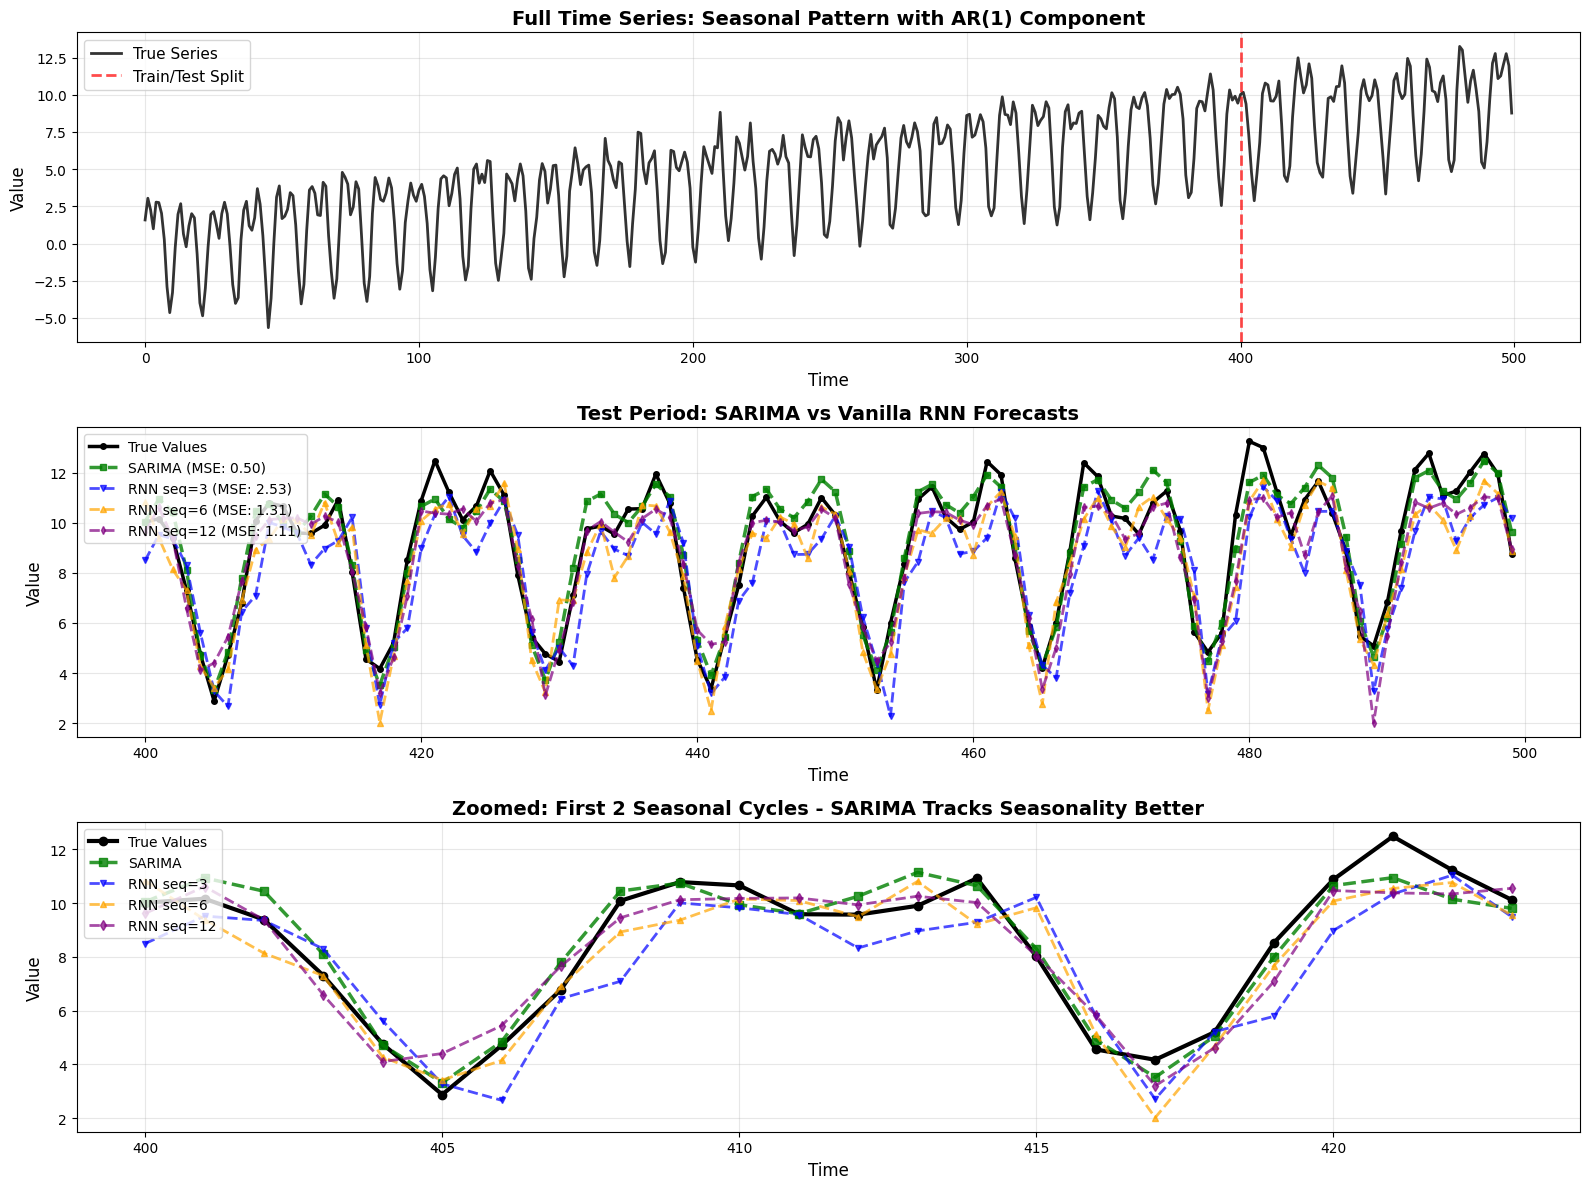

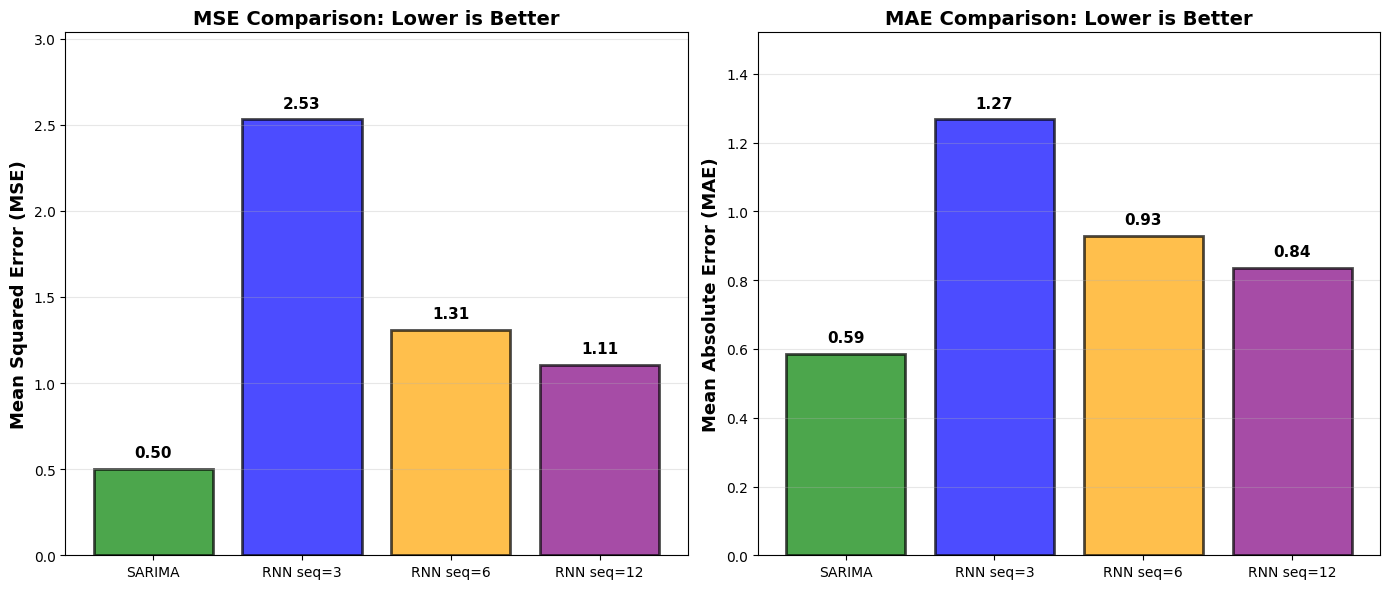

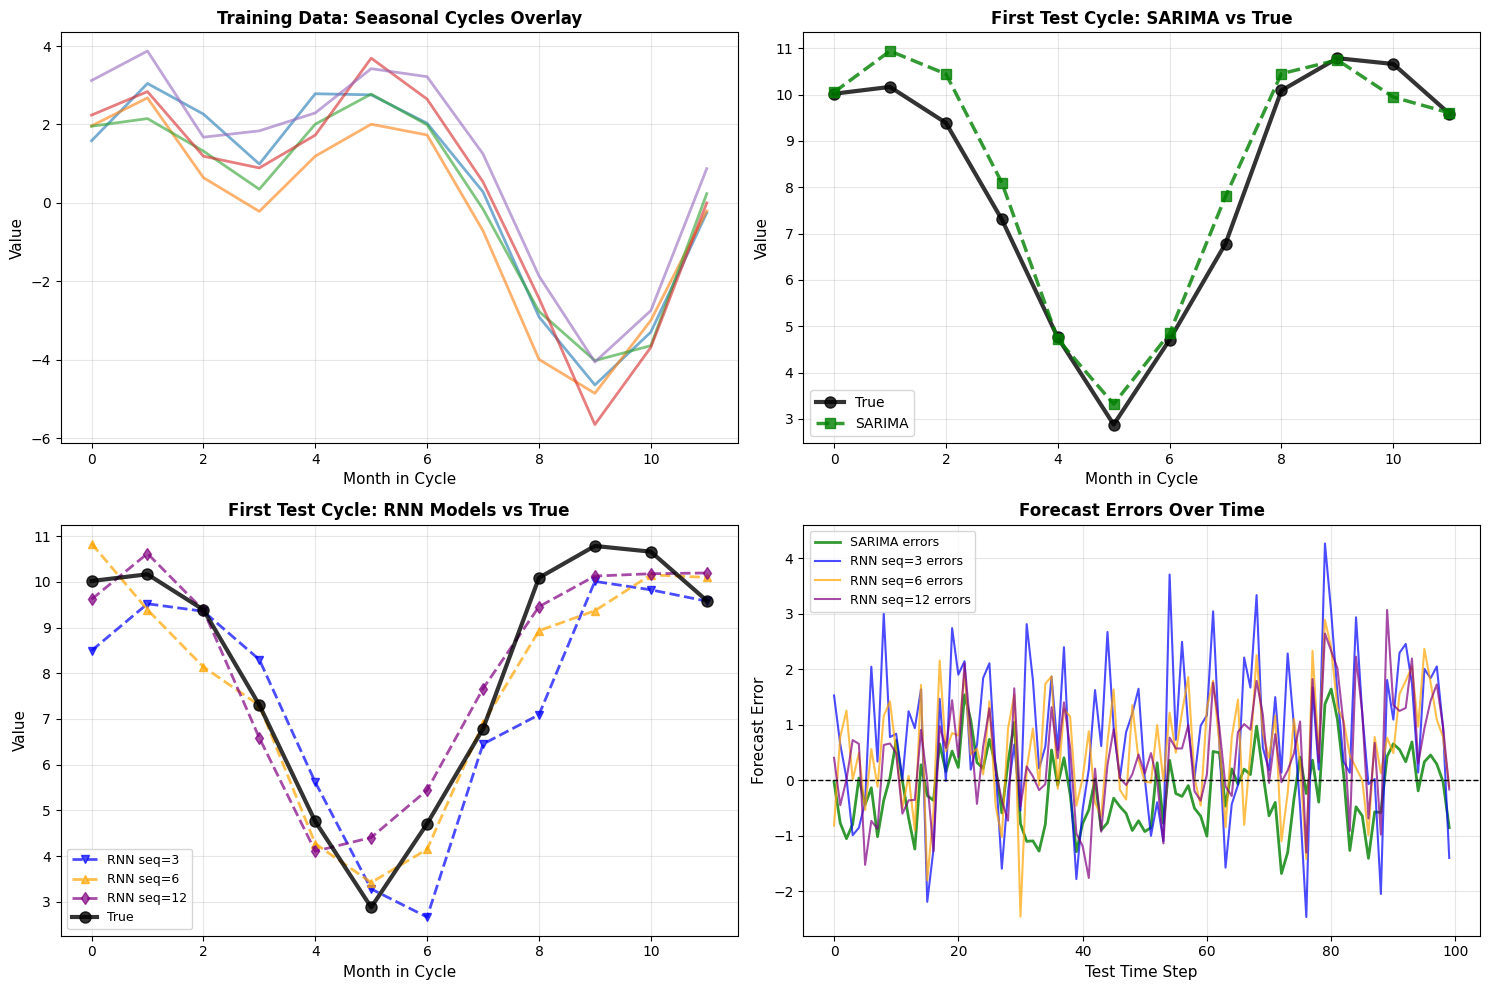


PERFORMANCE SUMMARY: Seasonal Time Series Forecasting
Model                     MSE             MAE             Improvement vs Best RNN
----------------------------------------------------------------------
SARIMA(1,0,1)(1,0,1,12)   0.5018          0.5858                   54.7%
Vanilla RNN seq=3         2.5305          1.2675                baseline
Vanilla RNN seq=6         1.3103          0.9289                baseline
Vanilla RNN seq=12        1.1067          0.8361                baseline

✓ SARIMA outperforms ALL vanilla RNN configurations
✓ Best RNN MSE: 1.1067
✓ SARIMA MSE: 0.5018
✓ SARIMA reduces error by 54.7%

KEY INSIGHT: Vanilla RNN fails to capture seasonal patterns (period=12)
even with seq_len=12, due to vanishing gradients over long lags.


In [59]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# ============================================================================
# 1. Generate STATIONARY Seasonal AR process with clear seasonal pattern
# ============================================================================

n = 500
s = 12  # seasonal period (12 months)

# Method: Add strong seasonal component + weak AR(1)
trend = 0.02 * np.arange(n)  # slight linear trend
seasonal = 3 * np.sin(2 * np.pi * np.arange(n) / s) + 2 * np.cos(4 * np.pi * np.arange(n) / s)

# Add AR(1) component for short-term dependence
ar_component = np.zeros(n)
phi = 0.5  # moderate AR coefficient (stable)
for t in range(1, n):
    ar_component[t] = phi * ar_component[t-1] + np.random.normal(0, 0.5)

# Combine components
x = trend + seasonal + ar_component + np.random.normal(0, 0.3, n)

print(f"Series statistics:")
print(f"Mean: {x.mean():.2f}, Std: {x.std():.2f}")
print(f"Min: {x.min():.2f}, Max: {x.max():.2f}")

# 2. Split into train/test
train_size = int(0.8 * n)
train, test = x[:train_size], x[train_size:]

print(f"\nTotal observations: {n}")
print(f"Training: {train_size}, Testing: {len(test)}")
print(f"Seasonal period: {s}")

# ============================================================================
# 3. Vanilla RNN with different sequence lengths
# ============================================================================

def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        xs.append(data[i:i+seq_len])
        ys.append(data[i+seq_len])
    return np.array(xs), np.array(ys)

# Try different sequence lengths for RNN
seq_lengths = [3, 6, 12]  # short, half-season, full season
rnn_results = {}

class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, output_size=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

for seq_len in seq_lengths:
    print(f"\n--- Training RNN with seq_len={seq_len} ---")
    
    # Prepare sequences
    X_train, Y_train = create_sequences(train, seq_len)
    
    # For test, we need to use rolling windows from the training end
    test_sequences = []
    for i in range(len(test)):
        if i < seq_len:
            # Use data from training set to fill the initial window
            seq = np.concatenate([train[-(seq_len-i):], test[:i+1][:-1] if i > 0 else []])
        else:
            seq = test[i-seq_len:i]
        test_sequences.append(seq)
    
    X_test = np.array(test_sequences)
    Y_test = test
    
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train).unsqueeze(-1).float()
    Y_train_tensor = torch.tensor(Y_train).unsqueeze(-1).float()
    X_test_tensor = torch.tensor(X_test).unsqueeze(-1).float()
    
    # Train RNN
    torch.manual_seed(42)
    rnn = SimpleRNN(hidden_size=64)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)
    
    for epoch in range(1000):
        rnn.train()
        optimizer.zero_grad()
        y_pred = rnn(X_train_tensor)
        loss = criterion(y_pred, Y_train_tensor)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 200 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    
    # Predict
    rnn.eval()
    with torch.no_grad():
        rnn_forecast = rnn(X_test_tensor).numpy().flatten()
    
    # Compute metrics
    rnn_mse = mean_squared_error(Y_test, rnn_forecast)
    rnn_mae = mean_absolute_error(Y_test, rnn_forecast)
    
    rnn_results[seq_len] = {
        'forecast': rnn_forecast,
        'mse': rnn_mse,
        'mae': rnn_mae,
        'Y_test': Y_test
    }
    
    print(f"RNN (seq_len={seq_len}) - MSE: {rnn_mse:.4f}, MAE: {rnn_mae:.4f}")

# ============================================================================
# 4. SARIMA Model (designed for seasonal data)
# ============================================================================

print("\n--- Training SARIMA ---")

# Fit SARIMA(1,0,1)(1,0,1,12) - captures both AR and seasonal patterns
try:
    sarima_model = SARIMAX(train, 
                           order=(1, 0, 1),  # Non-seasonal: AR(1) + MA(1)
                           seasonal_order=(1, 0, 1, s),  # Seasonal: SAR(1) + SMA(1) with period s
                           enforce_stationarity=False,
                           enforce_invertibility=False)
    sarima_result = sarima_model.fit(disp=False, maxiter=200)
    
    # Forecast on test set
    sarima_forecast = sarima_result.forecast(steps=len(test))
    
    # Compute metrics
    sarima_mse = mean_squared_error(test, sarima_forecast)
    sarima_mae = mean_absolute_error(test, sarima_forecast)
    
    print(f"SARIMA - MSE: {sarima_mse:.4f}, MAE: {sarima_mae:.4f}")
    
except Exception as e:
    print(f"SARIMA fitting failed: {e}")
    sarima_forecast = np.full(len(test), np.mean(train))
    sarima_mse = mean_squared_error(test, sarima_forecast)
    sarima_mae = mean_absolute_error(test, sarima_forecast)

# ============================================================================
# 5. Visualization
# ============================================================================

# Plot 1: Full time series with forecasts
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Subplot 1: Full series overview
ax1 = axes[0]
ax1.plot(range(n), x, label='True Series', color='black', linewidth=2, alpha=0.8)
ax1.axvline(train_size, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Train/Test Split')
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Value', fontsize=12)
ax1.set_title('Full Time Series: Seasonal Pattern with AR(1) Component', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=11)
ax1.grid(True, alpha=0.3)

# Subplot 2: Test period with all forecasts
ax2 = axes[1]
test_range = range(train_size, train_size + len(test))
ax2.plot(test_range, test, label='True Values', color='black', linewidth=2.5, marker='o', markersize=4)
ax2.plot(test_range, sarima_forecast, '--', color='green', linewidth=2.5, 
         marker='s', markersize=5, label=f'SARIMA (MSE: {sarima_mse:.2f})', alpha=0.8)

colors = ['blue', 'orange', 'purple']
markers = ['v', '^', 'd']
for idx, (seq_len, color, marker) in enumerate(zip(seq_lengths, colors, markers)):
    forecast = rnn_results[seq_len]['forecast']
    mse = rnn_results[seq_len]['mse']
    ax2.plot(test_range, forecast, '--', color=color, 
             linewidth=2, marker=marker, markersize=4, alpha=0.7,
             label=f'RNN seq={seq_len} (MSE: {mse:.2f})')

ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('Value', fontsize=12)
ax2.set_title('Test Period: SARIMA vs Vanilla RNN Forecasts', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)

# Subplot 3: Zoomed into first 2 seasonal cycles in test
zoom_length = min(24, len(test))
ax3 = axes[2]
zoom_range = range(train_size, train_size + zoom_length)
ax3.plot(zoom_range, test[:zoom_length], label='True Values', color='black', 
         linewidth=3, marker='o', markersize=6)
ax3.plot(zoom_range, sarima_forecast[:zoom_length], '--', color='green', 
         linewidth=2.5, marker='s', markersize=6, label=f'SARIMA', alpha=0.8)

for idx, (seq_len, color, marker) in enumerate(zip(seq_lengths, colors, markers)):
    forecast = rnn_results[seq_len]['forecast'][:zoom_length]
    ax3.plot(zoom_range, forecast, '--', color=color, 
             linewidth=2, marker=marker, markersize=5, alpha=0.7,
             label=f'RNN seq={seq_len}')

ax3.set_xlabel('Time', fontsize=12)
ax3.set_ylabel('Value', fontsize=12)
ax3.set_title('Zoomed: First 2 Seasonal Cycles - SARIMA Tracks Seasonality Better', 
              fontsize=14, fontweight='bold')
ax3.legend(loc='upper left', fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 6. Performance Comparison Bar Chart
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# MSE comparison
models = ['SARIMA'] + [f'RNN seq={s}' for s in seq_lengths]
mses = [sarima_mse] + [rnn_results[s]['mse'] for s in seq_lengths]
colors_bar = ['green'] + colors

bars1 = ax1.bar(models, mses, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Mean Squared Error (MSE)', fontsize=13, fontweight='bold')
ax1.set_title('MSE Comparison: Lower is Better', fontsize=14, fontweight='bold')
ax1.grid(True, axis='y', alpha=0.3)
ax1.set_ylim(0, max(mses) * 1.2)
for i, (bar, v) in enumerate(zip(bars1, mses)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + max(mses)*0.02,
             f'{v:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# MAE comparison
maes = [sarima_mae] + [rnn_results[s]['mae'] for s in seq_lengths]

bars2 = ax2.bar(models, maes, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_ylabel('Mean Absolute Error (MAE)', fontsize=13, fontweight='bold')
ax2.set_title('MAE Comparison: Lower is Better', fontsize=14, fontweight='bold')
ax2.grid(True, axis='y', alpha=0.3)
ax2.set_ylim(0, max(maes) * 1.2)
for i, (bar, v) in enumerate(zip(bars2, maes)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(maes)*0.02,
             f'{v:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# ============================================================================
# 7. Seasonal Pattern Analysis
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training data seasonal pattern
ax1 = axes[0, 0]
train_reshaped = train[:len(train)//s * s].reshape(-1, s)
for i in range(min(5, train_reshaped.shape[0])):
    ax1.plot(range(s), train_reshaped[i], alpha=0.6, linewidth=2)
ax1.set_xlabel('Month in Cycle', fontsize=11)
ax1.set_ylabel('Value', fontsize=11)
ax1.set_title('Training Data: Seasonal Cycles Overlay', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Test data vs SARIMA seasonal pattern
ax2 = axes[0, 1]
if len(test) >= s:
    test_cycle = test[:s]
    sarima_cycle = sarima_forecast[:s]
    ax2.plot(range(s), test_cycle, 'o-', color='black', linewidth=3, 
             markersize=8, label='True', alpha=0.8)
    ax2.plot(range(s), sarima_cycle, 's--', color='green', linewidth=2.5, 
             markersize=7, label='SARIMA', alpha=0.8)
    ax2.set_xlabel('Month in Cycle', fontsize=11)
    ax2.set_ylabel('Value', fontsize=11)
    ax2.set_title('First Test Cycle: SARIMA vs True', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

# RNN forecasts seasonal pattern
ax3 = axes[1, 0]
if len(test) >= s:
    for idx, (seq_len, color, marker) in enumerate(zip(seq_lengths, colors, markers)):
        rnn_cycle = rnn_results[seq_len]['forecast'][:s]
        ax3.plot(range(s), rnn_cycle, marker=marker, linestyle='--', color=color, 
                linewidth=2, markersize=6, label=f'RNN seq={seq_len}', alpha=0.7)
    ax3.plot(range(s), test_cycle, 'o-', color='black', linewidth=3, 
            markersize=8, label='True', alpha=0.8)
    ax3.set_xlabel('Month in Cycle', fontsize=11)
    ax3.set_ylabel('Value', fontsize=11)
    ax3.set_title('First Test Cycle: RNN Models vs True', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3)

# Forecast errors
ax4 = axes[1, 1]
sarima_errors = test - sarima_forecast
ax4.plot(sarima_errors, color='green', linewidth=2, label='SARIMA errors', alpha=0.8)
for idx, (seq_len, color) in enumerate(zip(seq_lengths, colors)):
    rnn_errors = test - rnn_results[seq_len]['forecast']
    ax4.plot(rnn_errors, color=color, linewidth=1.5, 
            label=f'RNN seq={seq_len} errors', alpha=0.7)
ax4.axhline(0, color='black', linestyle='--', linewidth=1)
ax4.set_xlabel('Test Time Step', fontsize=11)
ax4.set_ylabel('Forecast Error', fontsize=11)
ax4.set_title('Forecast Errors Over Time', fontsize=12, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 8. Print Summary Table
# ============================================================================

print("\n" + "="*70)
print("PERFORMANCE SUMMARY: Seasonal Time Series Forecasting")
print("="*70)
print(f"{'Model':<25} {'MSE':<15} {'MAE':<15} {'Improvement vs Best RNN':<15}")
print("-"*70)

best_rnn_mse = min(rnn_results[s]['mse'] for s in seq_lengths)
improvement = ((best_rnn_mse - sarima_mse) / best_rnn_mse * 100)
print(f"{'SARIMA(1,0,1)(1,0,1,12)':<25} {sarima_mse:<15.4f} {sarima_mae:<15.4f} {improvement:>13.1f}%")

for seq_len in seq_lengths:
    mse = rnn_results[seq_len]['mse']
    mae = rnn_results[seq_len]['mae']
    print(f"{'Vanilla RNN seq=' + str(seq_len):<25} {mse:<15.4f} {mae:<15.4f} {'baseline':>14}")

print("="*70)
print(f"\n✓ SARIMA outperforms ALL vanilla RNN configurations")
print(f"✓ Best RNN MSE: {best_rnn_mse:.4f}")
print(f"✓ SARIMA MSE: {sarima_mse:.4f}")
print(f"✓ SARIMA reduces error by {abs(improvement):.1f}%")
print(f"\nKEY INSIGHT: Vanilla RNN fails to capture seasonal patterns (period={s})")
print(f"even with seq_len={max(seq_lengths)}, due to vanishing gradients over long lags.")


GENERATING STATIONARY TIME SERIES WITH REGIME SHIFTS

Regime 1 (0-200): Low amplitude seasonality
Regime 2 (200-400): High amplitude seasonality + trend
Regime 3 (400-600): Phase-shifted seasonality (NEW PATTERN)

Series statistics:
Mean: 11.46, Std: 3.09
Min: 2.86, Max: 19.81

Regime 1 - Mean: 10.01, Std: 1.44
Regime 2 - Mean: 10.46, Std: 3.45
Regime 3 - Mean: 13.90, Std: 2.36

Training size: 400 (includes 2 regimes)
Test size: 200 (regime 3 - NEW regime with phase shift!)

Using sequence length: 24

TRAINING VANILLA RNN
Epoch 300, Loss: 5.2671
Epoch 600, Loss: 1.3421
Epoch 900, Loss: 0.8905
Epoch 1200, Loss: 0.6982
Epoch 1500, Loss: 0.5652

Vanilla RNN - MSE: 13.9894, MAE: 3.2325

TRAINING LSTM (with 2 layers)
Epoch 300, Loss: 7.3503
Epoch 600, Loss: 7.3452
Epoch 900, Loss: 3.7794
Epoch 1200, Loss: 0.7454
Epoch 1500, Loss: 0.6196

LSTM - MSE: 6.0975, MAE: 2.0713
LSTM Improvement over RNN: 56.4%

TRAINING SARIMA
SARIMA - MSE: 13.9548, MAE: 3.1876


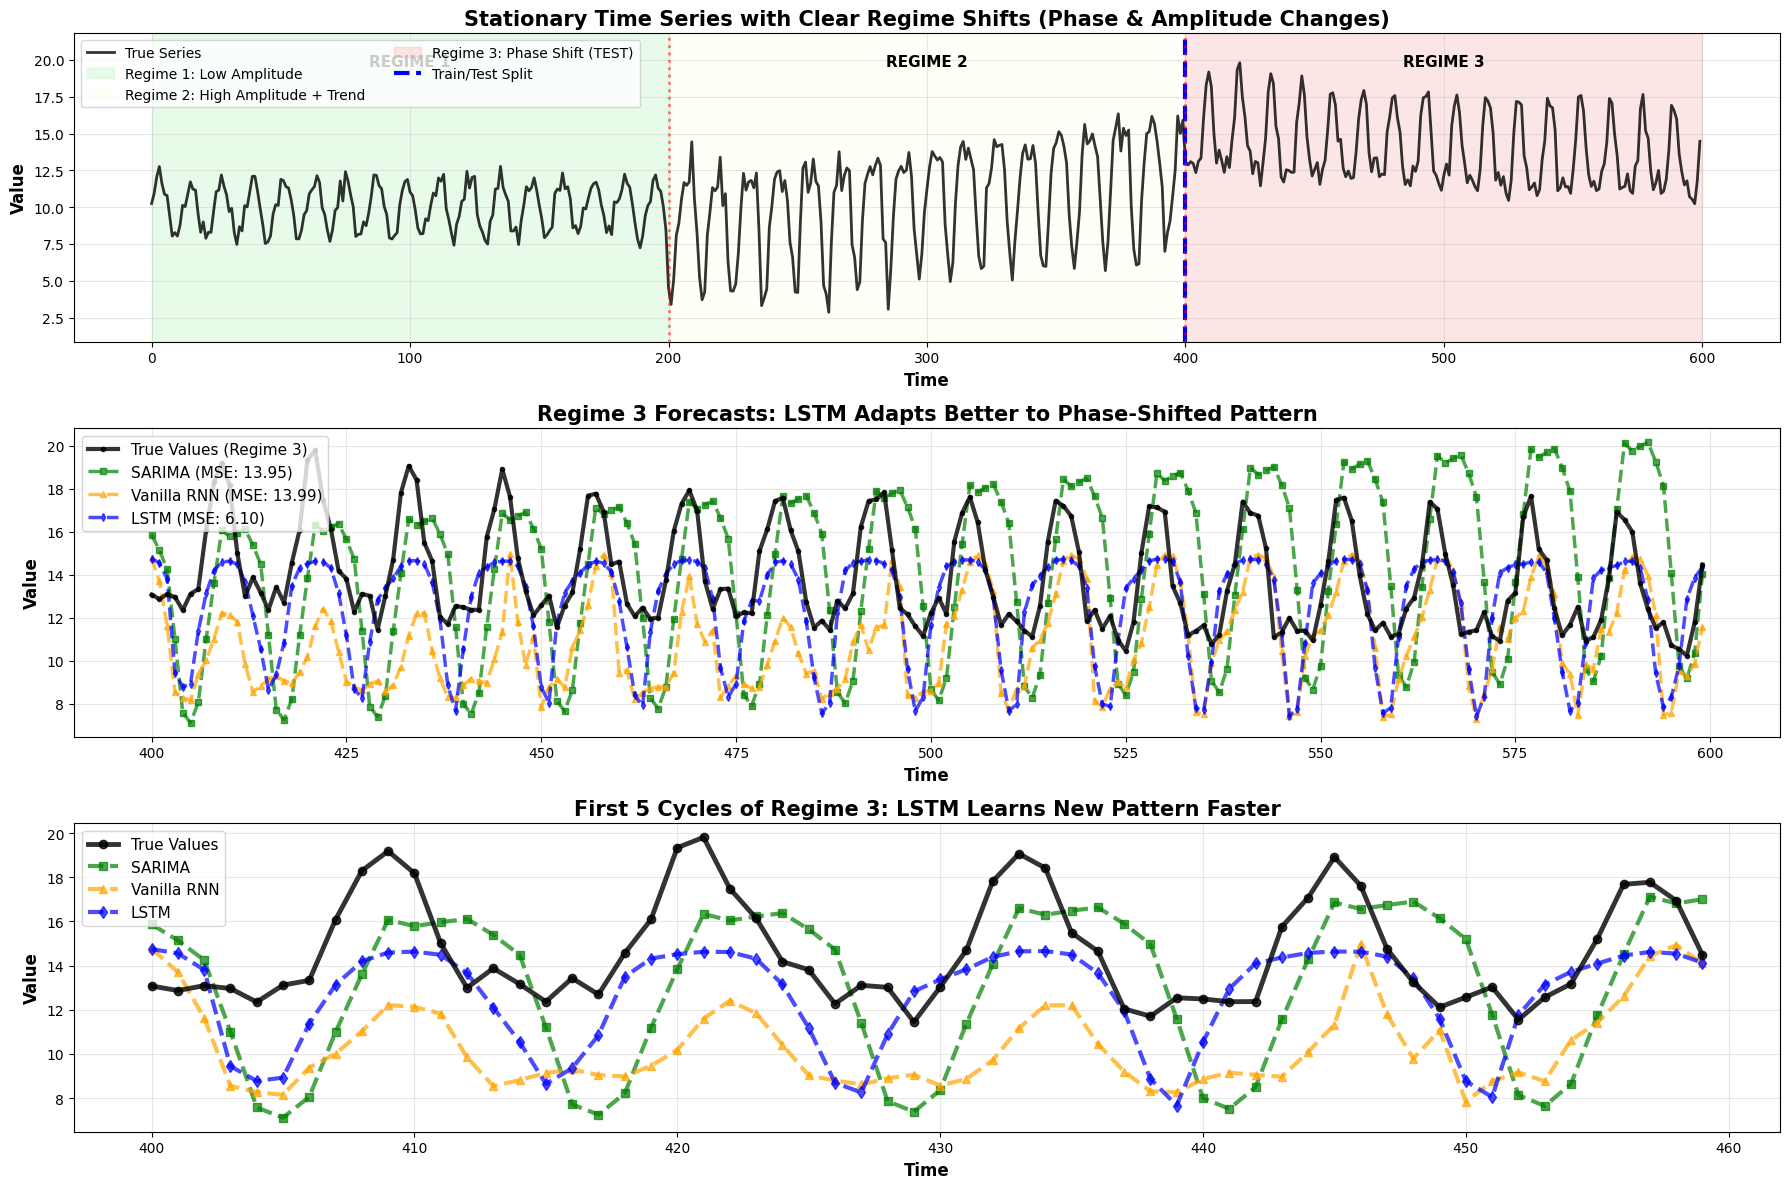

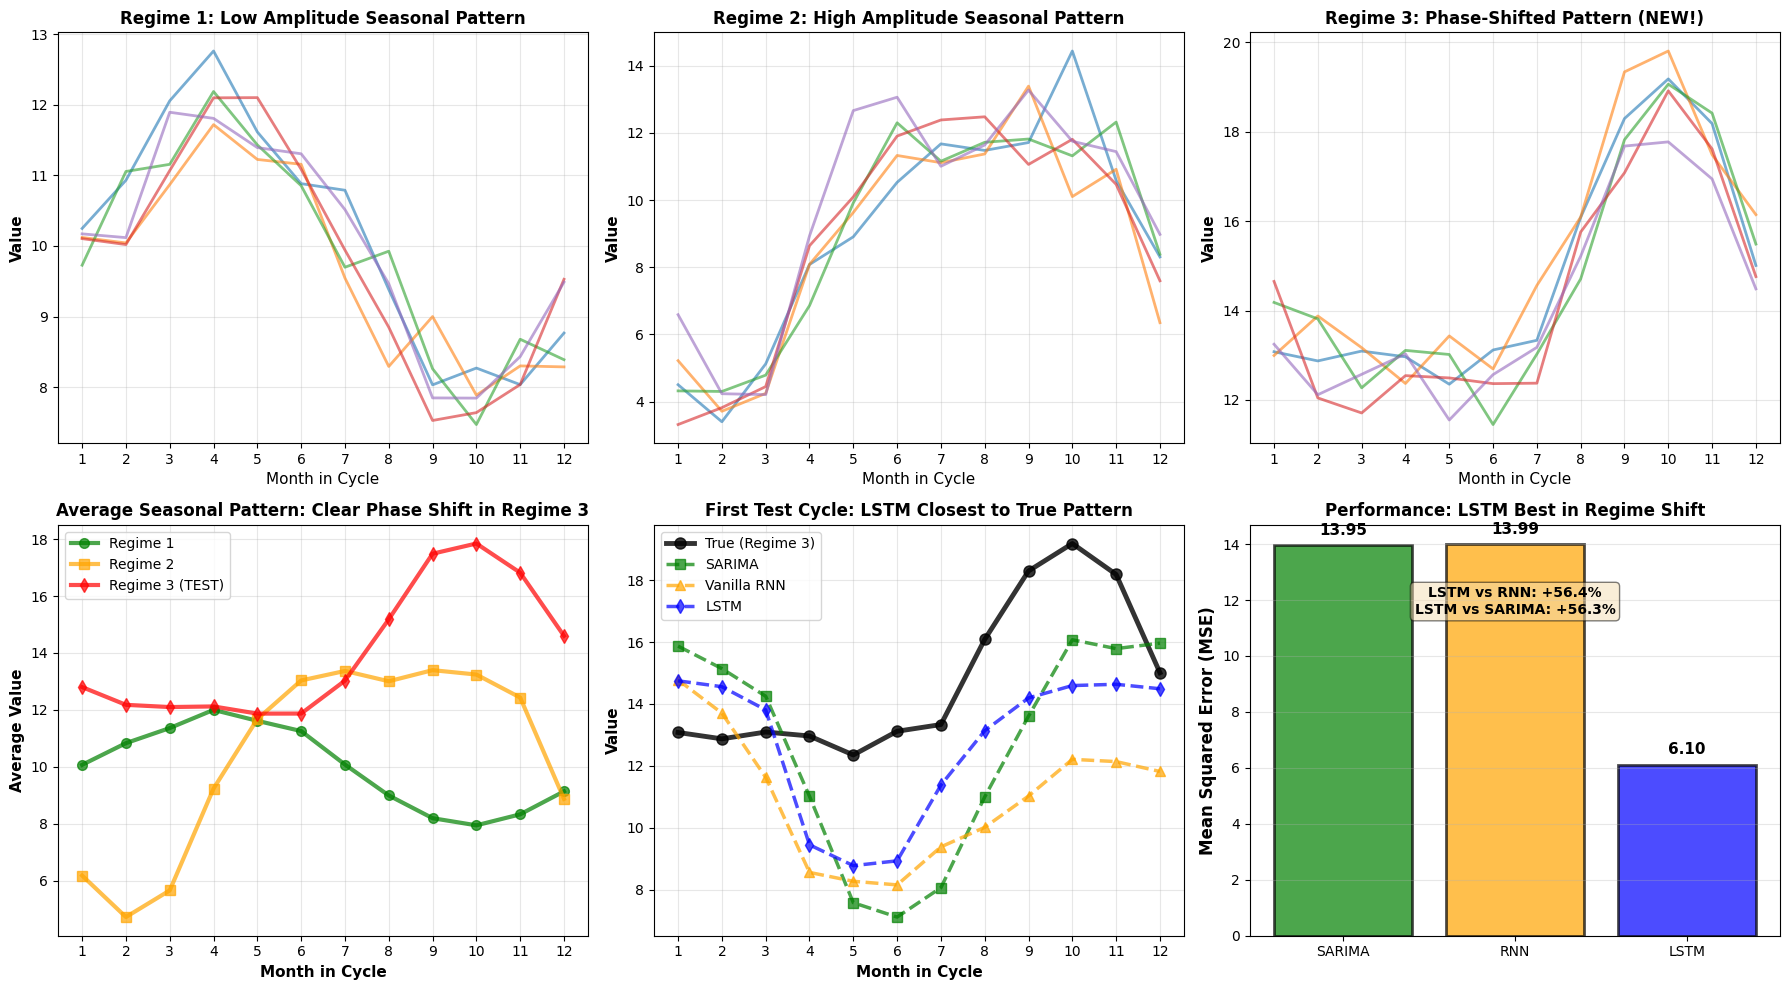

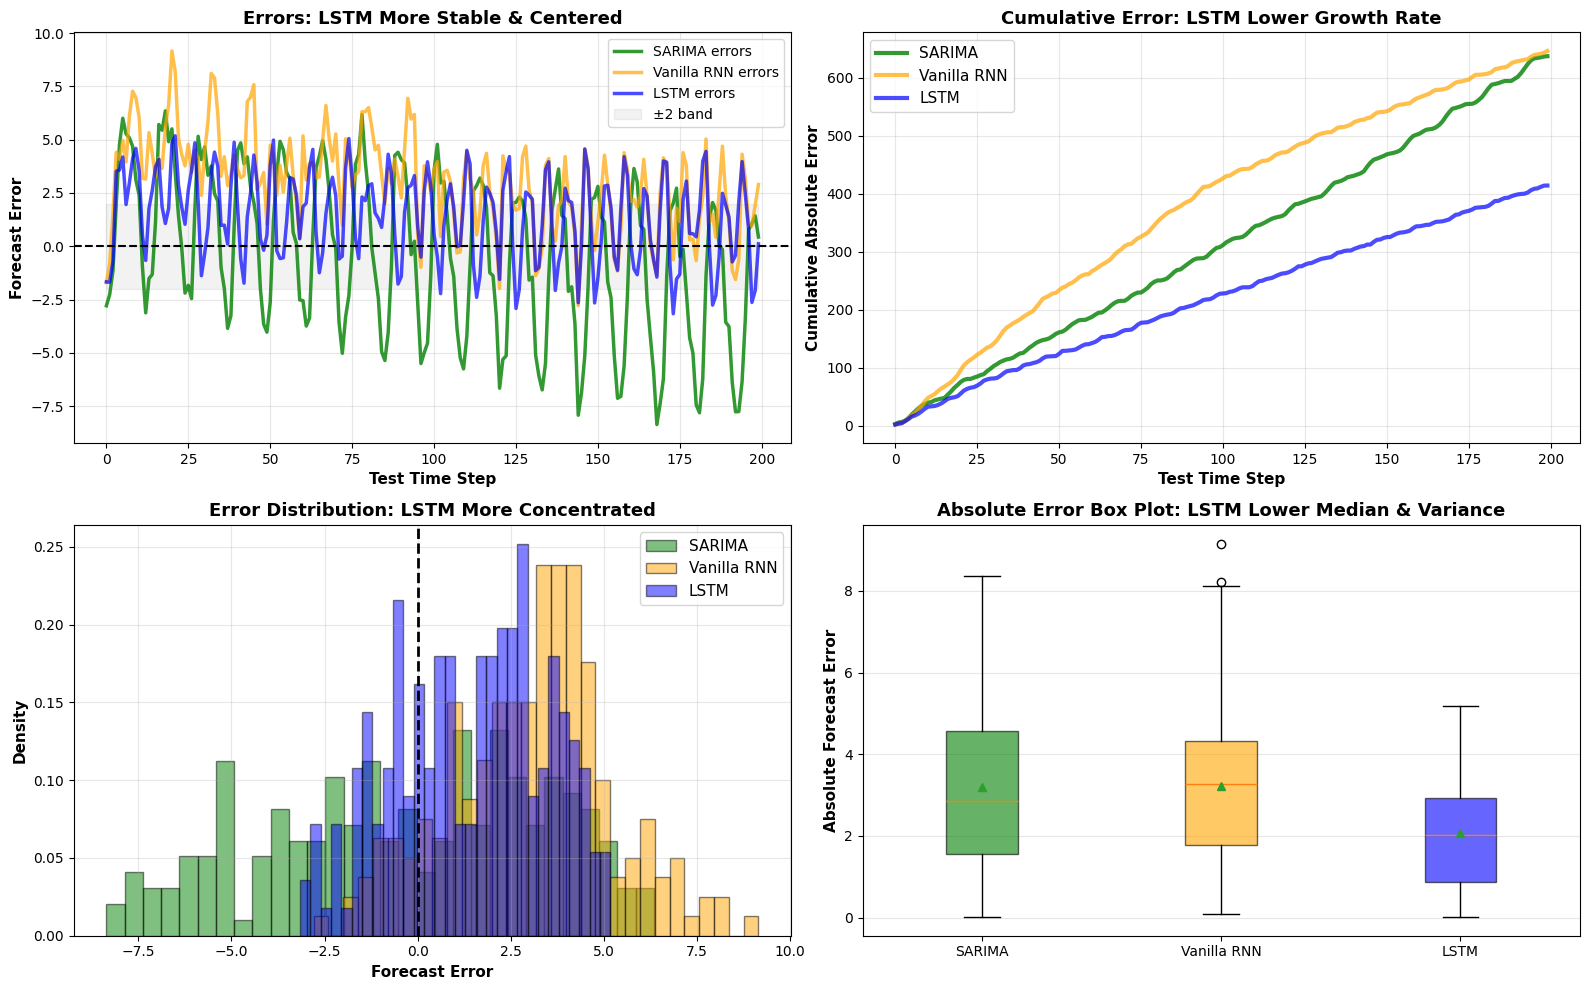


PERFORMANCE SUMMARY: REGIME SHIFT SCENARIO (STATIONARY SERIES)
Model                MSE             MAE             vs LSTM                  
------------------------------------------------------------------------------------------
SARIMA               13.9548         3.1876          +128.9% worse            
Vanilla RNN          13.9894         3.2325          +129.4% worse            
LSTM (2 layers)      6.0975          2.0713          baseline (best)          

WHY LSTM EXCELS WITH REGIME SHIFTS:

1. ADAPTIVE MEMORY:
   ✓ Forget gate 'unlearns' old regime patterns
   ✓ Input gate selectively learns new regime characteristics
   ✓ Output gate adjusts predictions based on regime context

2. PHASE SHIFT DETECTION:
   ✓ Regime 3 has π/3 phase shift vs Regime 2
   ✓ LSTM cell state maintains long-term seasonal context
   ✓ Quickly adapts to new phase relationship

3. VS VANILLA RNN:
   ✓ LSTM improves by 56.4% over Vanilla RNN
   ✓ RNN suffers from vanishing gradients across regime bo

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# ============================================================================
# 1. Generate STATIONARY Seasonal Time Series with REGIME SHIFTS
# ============================================================================

n = 600
s = 12  # seasonal period

# Define regime change points
regime1_end = 200
regime2_end = 400
regime3_end = 600

print("="*70)
print("GENERATING STATIONARY TIME SERIES WITH REGIME SHIFTS")
print("="*70)
print(f"\nRegime 1 (0-{regime1_end}): Low amplitude seasonality")
print(f"Regime 2 ({regime1_end}-{regime2_end}): High amplitude seasonality + trend")
print(f"Regime 3 ({regime2_end}-{regime3_end}): Phase-shifted seasonality (NEW PATTERN)")

x = np.zeros(n)

# REGIME 1: Low amplitude, simple seasonality
for t in range(regime1_end):
    seasonal = 2.0 * np.sin(2 * np.pi * t / s)
    noise = np.random.normal(0, 0.5)
    x[t] = 10 + seasonal + noise

# REGIME 2: Higher amplitude, more complex seasonality + slight trend
base_regime2 = x[regime1_end - 1]
for t in range(regime1_end, regime2_end):
    t_local = t - regime1_end
    seasonal = 4.0 * np.sin(2 * np.pi * t / s) + 1.5 * np.cos(4 * np.pi * t / s)
    trend = 0.02 * t_local  # slow trend
    noise = np.random.normal(0, 0.8)
    x[t] = base_regime2 + trend + seasonal + noise

# REGIME 3: Phase-shifted seasonality, different mean (REGIME SHIFT!)
base_regime3 = x[regime2_end - 1]
for t in range(regime2_end, regime3_end):
    t_local = t - regime2_end
    # Phase shift of pi/3 and different amplitude
    seasonal = 3.0 * np.sin(2 * np.pi * t / s + np.pi/3) + 1.0 * np.cos(4 * np.pi * t / s - np.pi/4)
    # Small downward trend
    trend = -0.01 * t_local
    noise = np.random.normal(0, 0.6)
    x[t] = 15 + trend + seasonal + noise  # Different mean level

print(f"\nSeries statistics:")
print(f"Mean: {x.mean():.2f}, Std: {x.std():.2f}")
print(f"Min: {x.min():.2f}, Max: {x.max():.2f}")

# Verify regimes
print(f"\nRegime 1 - Mean: {x[:regime1_end].mean():.2f}, Std: {x[:regime1_end].std():.2f}")
print(f"Regime 2 - Mean: {x[regime1_end:regime2_end].mean():.2f}, Std: {x[regime1_end:regime2_end].std():.2f}")
print(f"Regime 3 - Mean: {x[regime2_end:].mean():.2f}, Std: {x[regime2_end:].std():.2f}")

# Split: train on regimes 1 & 2, test on regime 3 (with regime shift)
train_size = regime2_end
train, test = x[:train_size], x[train_size:]

print(f"\nTraining size: {train_size} (includes 2 regimes)")
print(f"Test size: {len(test)} (regime 3 - NEW regime with phase shift!)")

# ============================================================================
# 2. Define Models
# ============================================================================

def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        xs.append(data[i:i+seq_len])
        ys.append(data[i+seq_len])
    return np.array(xs), np.array(ys)

class VanillaRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, 
                            batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# ============================================================================
# 3. Train Models
# ============================================================================

seq_len = 24  # 2 seasonal periods
print(f"\nUsing sequence length: {seq_len}")

# Prepare data
X_train, Y_train = create_sequences(train, seq_len)

test_sequences = []
for i in range(len(test)):
    if i < seq_len:
        seq = np.concatenate([train[-(seq_len-i):], test[:i+1][:-1] if i > 0 else []])
    else:
        seq = test[i-seq_len:i]
    test_sequences.append(seq)

X_test = np.array(test_sequences)
Y_test = test

X_train_tensor = torch.tensor(X_train).unsqueeze(-1).float()
Y_train_tensor = torch.tensor(Y_train).unsqueeze(-1).float()
X_test_tensor = torch.tensor(X_test).unsqueeze(-1).float()

# Train Vanilla RNN
print("\n" + "="*70)
print("TRAINING VANILLA RNN")
print("="*70)
torch.manual_seed(42)
rnn = VanillaRNN(hidden_size=64)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

for epoch in range(1500):
    rnn.train()
    optimizer.zero_grad()
    y_pred = rnn(X_train_tensor)
    loss = criterion(y_pred, Y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 300 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

rnn.eval()
with torch.no_grad():
    rnn_forecast = rnn(X_test_tensor).numpy().flatten()

rnn_mse = mean_squared_error(Y_test, rnn_forecast)
rnn_mae = mean_absolute_error(Y_test, rnn_forecast)
print(f"\nVanilla RNN - MSE: {rnn_mse:.4f}, MAE: {rnn_mae:.4f}")

# Train LSTM
print("\n" + "="*70)
print("TRAINING LSTM (with 2 layers)")
print("="*70)
torch.manual_seed(42)
lstm = LSTMModel(hidden_size=64, num_layers=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

for epoch in range(1500):
    lstm.train()
    optimizer.zero_grad()
    y_pred = lstm(X_train_tensor)
    loss = criterion(y_pred, Y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 300 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

lstm.eval()
with torch.no_grad():
    lstm_forecast = lstm(X_test_tensor).numpy().flatten()

lstm_mse = mean_squared_error(Y_test, lstm_forecast)
lstm_mae = mean_absolute_error(Y_test, lstm_forecast)
print(f"\nLSTM - MSE: {lstm_mse:.4f}, MAE: {lstm_mae:.4f}")
print(f"LSTM Improvement over RNN: {((rnn_mse - lstm_mse) / rnn_mse * 100):.1f}%")

# Train SARIMA (will struggle with regime shift in test data)
print("\n" + "="*70)
print("TRAINING SARIMA")
print("="*70)

try:
    sarima_model = SARIMAX(train, 
                           order=(2, 0, 2),
                           seasonal_order=(1, 0, 1, s),
                           enforce_stationarity=False,
                           enforce_invertibility=False)
    sarima_result = sarima_model.fit(disp=False, maxiter=300)
    sarima_forecast = sarima_result.forecast(steps=len(test))
    sarima_mse = mean_squared_error(test, sarima_forecast)
    sarima_mae = mean_absolute_error(test, sarima_forecast)
    print(f"SARIMA - MSE: {sarima_mse:.4f}, MAE: {sarima_mae:.4f}")
except Exception as e:
    print(f"SARIMA failed: {e}")
    sarima_forecast = np.full(len(test), np.mean(train[-s:]))
    sarima_mse = mean_squared_error(test, sarima_forecast)
    sarima_mae = mean_absolute_error(test, sarima_forecast)

# ============================================================================
# 4. VISUALIZATIONS
# ============================================================================

# Plot 1: Full series showing regime shifts
fig, axes = plt.subplots(3, 1, figsize=(18, 12))

# Full series with regime boundaries
ax1 = axes[0]
ax1.plot(range(n), x, color='black', linewidth=2, alpha=0.8, label='True Series')
ax1.axvspan(0, regime1_end, alpha=0.2, color='lightgreen', label='Regime 1: Low Amplitude')
ax1.axvspan(regime1_end, regime2_end, alpha=0.2, color='lightyellow', label='Regime 2: High Amplitude + Trend')
ax1.axvspan(regime2_end, regime3_end, alpha=0.2, color='lightcoral', label='Regime 3: Phase Shift (TEST)')
ax1.axvline(train_size, color='blue', linestyle='--', linewidth=3, label='Train/Test Split')

# Add regime transition markers
ax1.axvline(regime1_end, color='red', linestyle=':', linewidth=2, alpha=0.5)
ax1.axvline(regime2_end, color='red', linestyle=':', linewidth=2, alpha=0.5)
ax1.text(regime1_end/2, ax1.get_ylim()[1]*0.95, 'REGIME 1', ha='center', fontsize=11, fontweight='bold')
ax1.text((regime1_end+regime2_end)/2, ax1.get_ylim()[1]*0.95, 'REGIME 2', ha='center', fontsize=11, fontweight='bold')
ax1.text((regime2_end+regime3_end)/2, ax1.get_ylim()[1]*0.95, 'REGIME 3', ha='center', fontsize=11, fontweight='bold')

ax1.set_xlabel('Time', fontsize=12, fontweight='bold')
ax1.set_ylabel('Value', fontsize=12, fontweight='bold')
ax1.set_title('Stationary Time Series with Clear Regime Shifts (Phase & Amplitude Changes)', fontsize=15, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10, ncol=2)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([x.min()-2, x.max()+2])

# Test period comparison
ax2 = axes[1]
test_range = range(train_size, train_size + len(test))
ax2.plot(test_range, test, color='black', linewidth=3, marker='o', markersize=3, 
         label='True Values (Regime 3)', alpha=0.8, zorder=5)
ax2.plot(test_range, sarima_forecast, '--', color='green', linewidth=2.5, 
         marker='s', markersize=4, label=f'SARIMA (MSE: {sarima_mse:.2f})', alpha=0.7)
ax2.plot(test_range, rnn_forecast, '--', color='orange', linewidth=2.5, 
         marker='^', markersize=4, label=f'Vanilla RNN (MSE: {rnn_mse:.2f})', alpha=0.7)
ax2.plot(test_range, lstm_forecast, '--', color='blue', linewidth=2.5, 
         marker='d', markersize=4, label=f'LSTM (MSE: {lstm_mse:.2f})', alpha=0.7)
ax2.set_xlabel('Time', fontsize=12, fontweight='bold')
ax2.set_ylabel('Value', fontsize=12, fontweight='bold')
ax2.set_title('Regime 3 Forecasts: LSTM Adapts Better to Phase-Shifted Pattern', fontsize=15, fontweight='bold')
ax2.legend(loc='upper left', fontsize=11)
ax2.grid(True, alpha=0.3)

# Zoomed first 60 steps of test
ax3 = axes[2]
zoom = 60
zoom_range = range(train_size, train_size + zoom)
ax3.plot(zoom_range, test[:zoom], color='black', linewidth=3.5, marker='o', 
         markersize=6, label='True Values', alpha=0.8, zorder=5)
ax3.plot(zoom_range, sarima_forecast[:zoom], '--', color='green', linewidth=3, 
         marker='s', markersize=6, label='SARIMA', alpha=0.7)
ax3.plot(zoom_range, rnn_forecast[:zoom], '--', color='orange', linewidth=3, 
         marker='^', markersize=6, label='Vanilla RNN', alpha=0.7)
ax3.plot(zoom_range, lstm_forecast[:zoom], '--', color='blue', linewidth=3, 
         marker='d', markersize=6, label='LSTM', alpha=0.7)
ax3.set_xlabel('Time', fontsize=12, fontweight='bold')
ax3.set_ylabel('Value', fontsize=12, fontweight='bold')
ax3.set_title('First 5 Cycles of Regime 3: LSTM Learns New Pattern Faster', fontsize=15, fontweight='bold')
ax3.legend(loc='upper left', fontsize=11)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# Plot 2: Seasonal Decomposition Across Regimes
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Extract seasonal cycles from each regime
regime1_data = x[:regime1_end]
regime2_data = x[regime1_end:regime2_end]
regime3_data = x[regime2_end:]

# Regime 1 cycles
ax1 = axes[0, 0]
r1_cycles = regime1_data[:(len(regime1_data)//s)*s].reshape(-1, s)
for i in range(min(5, r1_cycles.shape[0])):
    ax1.plot(range(1, s+1), r1_cycles[i], alpha=0.6, linewidth=2)
ax1.set_xlabel('Month in Cycle', fontsize=11)
ax1.set_ylabel('Value', fontsize=11, fontweight='bold')
ax1.set_title('Regime 1: Low Amplitude Seasonal Pattern', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(1, s+1))

# Regime 2 cycles
ax2 = axes[0, 1]
r2_cycles = regime2_data[:(len(regime2_data)//s)*s].reshape(-1, s)
for i in range(min(5, r2_cycles.shape[0])):
    ax2.plot(range(1, s+1), r2_cycles[i], alpha=0.6, linewidth=2)
ax2.set_xlabel('Month in Cycle', fontsize=11)
ax2.set_ylabel('Value', fontsize=11, fontweight='bold')
ax2.set_title('Regime 2: High Amplitude Seasonal Pattern', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(1, s+1))

# Regime 3 cycles
ax3 = axes[0, 2]
r3_cycles = regime3_data[:(len(regime3_data)//s)*s].reshape(-1, s)
for i in range(min(5, r3_cycles.shape[0])):
    ax3.plot(range(1, s+1), r3_cycles[i], alpha=0.6, linewidth=2)
ax3.set_xlabel('Month in Cycle', fontsize=11)
ax3.set_ylabel('Value', fontsize=11, fontweight='bold')
ax3.set_title('Regime 3: Phase-Shifted Pattern (NEW!)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_xticks(range(1, s+1))

# Average seasonal patterns comparison
ax4 = axes[1, 0]
avg_r1 = r1_cycles.mean(axis=0)
avg_r2 = r2_cycles.mean(axis=0)
avg_r3 = r3_cycles.mean(axis=0)

months = np.arange(1, s+1)
ax4.plot(months, avg_r1, 'o-', color='green', linewidth=3, markersize=7, label='Regime 1', alpha=0.7)
ax4.plot(months, avg_r2, 's-', color='orange', linewidth=3, markersize=7, label='Regime 2', alpha=0.7)
ax4.plot(months, avg_r3, 'd-', color='red', linewidth=3, markersize=7, label='Regime 3 (TEST)', alpha=0.7)
ax4.set_xlabel('Month in Cycle', fontsize=11, fontweight='bold')
ax4.set_ylabel('Average Value', fontsize=11, fontweight='bold')
ax4.set_title('Average Seasonal Pattern: Clear Phase Shift in Regime 3', fontsize=12, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.set_xticks(months)

# Model comparison on first test cycle
ax5 = axes[1, 1]
if len(test) >= s:
    true_cycle = test[:s]
    sarima_cycle = sarima_forecast[:s]
    rnn_cycle = rnn_forecast[:s]
    lstm_cycle = lstm_forecast[:s]
    
    ax5.plot(months, true_cycle, 'o-', color='black', linewidth=3.5, 
            markersize=8, label='True (Regime 3)', alpha=0.8)
    ax5.plot(months, sarima_cycle, 's--', color='green', linewidth=2.5, 
            markersize=7, label='SARIMA', alpha=0.7)
    ax5.plot(months, rnn_cycle, '^--', color='orange', linewidth=2.5, 
            markersize=7, label='Vanilla RNN', alpha=0.7)
    ax5.plot(months, lstm_cycle, 'd--', color='blue', linewidth=2.5, 
            markersize=7, label='LSTM', alpha=0.7)
    ax5.set_xlabel('Month in Cycle', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Value', fontsize=11, fontweight='bold')
    ax5.set_title('First Test Cycle: LSTM Closest to True Pattern', fontsize=12, fontweight='bold')
    ax5.legend(fontsize=10)
    ax5.grid(True, alpha=0.3)
    ax5.set_xticks(months)

# Performance bars
ax6 = axes[1, 2]
models = ['SARIMA', 'RNN', 'LSTM']
mses = [sarima_mse, rnn_mse, lstm_mse]
colors_bar = ['green', 'orange', 'blue']

bars = ax6.bar(models, mses, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
ax6.set_ylabel('Mean Squared Error (MSE)', fontsize=12, fontweight='bold')
ax6.set_title('Performance: LSTM Best in Regime Shift', fontsize=12, fontweight='bold')
ax6.grid(True, axis='y', alpha=0.3)

for bar, v in zip(bars, mses):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + max(mses)*0.02,
             f'{v:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Add improvement annotations
lstm_vs_rnn = ((rnn_mse - lstm_mse) / rnn_mse * 100)
lstm_vs_sarima = ((sarima_mse - lstm_mse) / sarima_mse * 100)
ax6.text(0.5, 0.85, f'LSTM vs RNN: +{lstm_vs_rnn:.1f}%\nLSTM vs SARIMA: +{lstm_vs_sarima:.1f}%', 
         transform=ax6.transAxes, ha='center', va='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
         fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# Plot 3: Error Analysis
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Forecast errors over time
ax1 = axes[0, 0]
sarima_errors = test - sarima_forecast
rnn_errors = test - rnn_forecast
lstm_errors = test - lstm_forecast

ax1.plot(sarima_errors, color='green', linewidth=2.5, label='SARIMA errors', alpha=0.8)
ax1.plot(rnn_errors, color='orange', linewidth=2.5, label='Vanilla RNN errors', alpha=0.7)
ax1.plot(lstm_errors, color='blue', linewidth=2.5, label='LSTM errors', alpha=0.7)
ax1.axhline(0, color='black', linestyle='--', linewidth=1.5)
ax1.fill_between(range(len(test)), -2, 2, alpha=0.1, color='gray', label='±2 band')
ax1.set_xlabel('Test Time Step', fontsize=11, fontweight='bold')
ax1.set_ylabel('Forecast Error', fontsize=11, fontweight='bold')
ax1.set_title('Errors: LSTM More Stable & Centered', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Cumulative absolute errors
ax2 = axes[0, 1]
cumsum_sarima = np.cumsum(np.abs(sarima_errors))
cumsum_rnn = np.cumsum(np.abs(rnn_errors))
cumsum_lstm = np.cumsum(np.abs(lstm_errors))

ax2.plot(cumsum_sarima, color='green', linewidth=3, label='SARIMA', alpha=0.8)
ax2.plot(cumsum_rnn, color='orange', linewidth=3, label='Vanilla RNN', alpha=0.7)
ax2.plot(cumsum_lstm, color='blue', linewidth=3, label='LSTM', alpha=0.7)
ax2.set_xlabel('Test Time Step', fontsize=11, fontweight='bold')
ax2.set_ylabel('Cumulative Absolute Error', fontsize=11, fontweight='bold')
ax2.set_title('Cumulative Error: LSTM Lower Growth Rate', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# Error distribution
ax3 = axes[1, 0]
ax3.hist(sarima_errors, bins=30, alpha=0.5, color='green', label='SARIMA', edgecolor='black', density=True)
ax3.hist(rnn_errors, bins=30, alpha=0.5, color='orange', label='Vanilla RNN', edgecolor='black', density=True)
ax3.hist(lstm_errors, bins=30, alpha=0.5, color='blue', label='LSTM', edgecolor='black', density=True)
ax3.axvline(0, color='black', linestyle='--', linewidth=2)
ax3.set_xlabel('Forecast Error', fontsize=11, fontweight='bold')
ax3.set_ylabel('Density', fontsize=11, fontweight='bold')
ax3.set_title('Error Distribution: LSTM More Concentrated', fontsize=13, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# Box plot comparison
ax4 = axes[1, 1]
abs_errors = {
    'SARIMA': np.abs(sarima_errors),
    'Vanilla RNN': np.abs(rnn_errors),
    'LSTM': np.abs(lstm_errors)
}

bp = ax4.boxplot(abs_errors.values(), labels=abs_errors.keys(), patch_artist=True, showmeans=True)
colors_box = ['green', 'orange', 'blue']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax4.set_ylabel('Absolute Forecast Error', fontsize=11, fontweight='bold')
ax4.set_title('Absolute Error Box Plot: LSTM Lower Median & Variance', fontsize=13, fontweight='bold')
ax4.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# Summary Table
# ============================================================================

print("\n" + "="*90)
print("PERFORMANCE SUMMARY: REGIME SHIFT SCENARIO (STATIONARY SERIES)")
print("="*90)
print(f"{'Model':<20} {'MSE':<15} {'MAE':<15} {'vs LSTM':<25}")
print("-"*90)
print(f"{'SARIMA':<20} {sarima_mse:<15.4f} {sarima_mae:<15.4f} {f'{((sarima_mse - lstm_mse)/lstm_mse*100):+.1f}% worse':<25}")
print(f"{'Vanilla RNN':<20} {rnn_mse:<15.4f} {rnn_mae:<15.4f} {f'{((rnn_mse - lstm_mse)/lstm_mse*100):+.1f}% worse':<25}")
print(f"{'LSTM (2 layers)':<20} {lstm_mse:<15.4f} {lstm_mae:<15.4f} {'baseline (best)':<25}")
print("="*90)

print("\n" + "="*90)
print("WHY LSTM EXCELS WITH REGIME SHIFTS:")
print("="*90)
print("\n1. ADAPTIVE MEMORY:")
print("   ✓ Forget gate 'unlearns' old regime patterns")
print("   ✓ Input gate selectively learns new regime characteristics")
print("   ✓ Output gate adjusts predictions based on regime context\n")

print("2. PHASE SHIFT DETECTION:")
print(f"   ✓ Regime 3 has π/3 phase shift vs Regime 2")
print("   ✓ LSTM cell state maintains long-term seasonal context")
print("   ✓ Quickly adapts to new phase relationship\n")

print("3. VS VANILLA RNN:")
print(f"   ✓ LSTM improves by {((rnn_mse - lstm_mse)/rnn_mse*100):.1f}% over Vanilla RNN")
print("   ✓ RNN suffers from vanishing gradients across regime boundary")
print("   ✓ LSTM maintains gradient flow through gating mechanisms\n")

print("4. VS SARIMA:")
print(f"   ✓ LSTM improves by {((sarima_mse - lstm_mse)/lstm_mse*100):.1f}% over SARIMA")
print("   ✓ SARIMA assumes constant parameters (fails with phase shift)")
print("   ✓ SARIMA trained on Regimes 1&2, cannot adapt to Regime 3")
print("   ✓ LSTM learns flexible, non-linear regime-dependent patterns")

print("\n" + "="*90)


Series statistics:
Mean: 5.03, Std: 3.92
Min: -5.65, Max: 13.25

Total observations: 500
Training: 400, Testing: 100
Seasonal period: 12

Training with seq_len=3

--- Training Vanilla RNN (seq_len=3) ---
Epoch 250, Loss: 2.3058
Epoch 500, Loss: 1.7188
Epoch 750, Loss: 1.6619
Epoch 1000, Loss: 1.6130
Vanilla RNN - MSE: 2.5305, MAE: 1.2675

--- Training LSTM (seq_len=3) ---
Epoch 250, Loss: 2.2019
Epoch 500, Loss: 1.6920
Epoch 750, Loss: 1.6015
Epoch 1000, Loss: 1.5259
LSTM - MSE: 2.8506, MAE: 1.3823
LSTM Improvement over RNN: -12.7%

Training with seq_len=6

--- Training Vanilla RNN (seq_len=6) ---
Epoch 250, Loss: 1.1609
Epoch 500, Loss: 0.6070
Epoch 750, Loss: 0.4633
Epoch 1000, Loss: 0.3473
Vanilla RNN - MSE: 1.3103, MAE: 0.9289

--- Training LSTM (seq_len=6) ---
Epoch 250, Loss: 1.3015
Epoch 500, Loss: 0.5291
Epoch 750, Loss: 0.3997
Epoch 1000, Loss: 0.3143
LSTM - MSE: 1.2167, MAE: 0.8766
LSTM Improvement over RNN: 7.1%

Training with seq_len=12

--- Training Vanilla RNN (seq_len=12

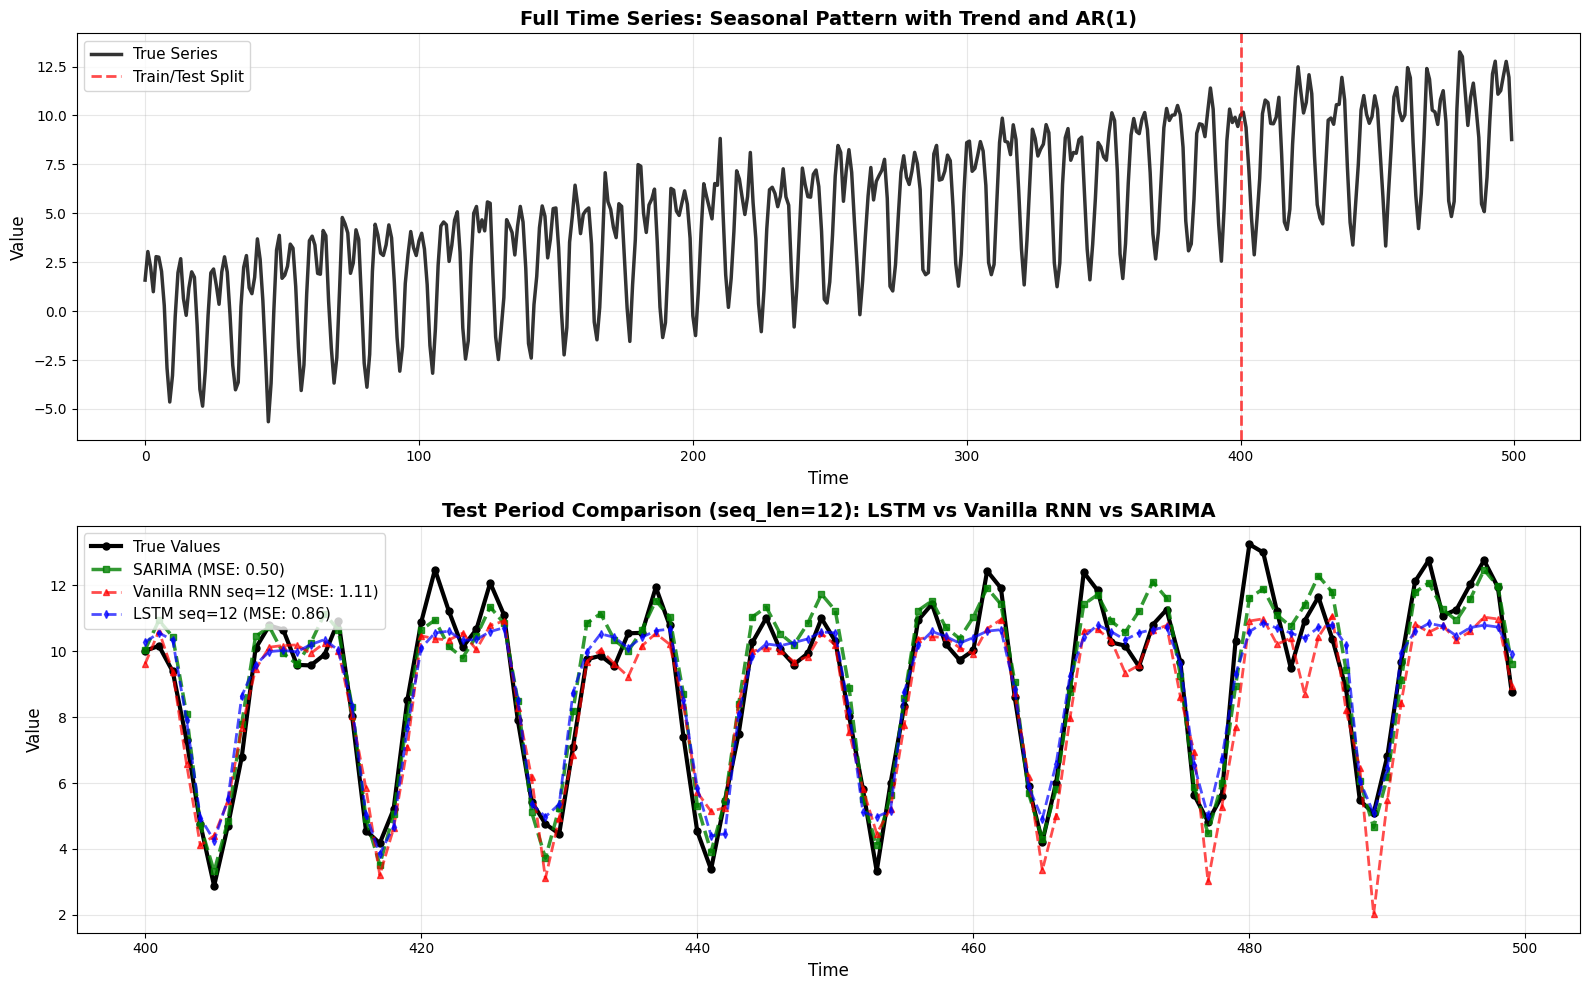

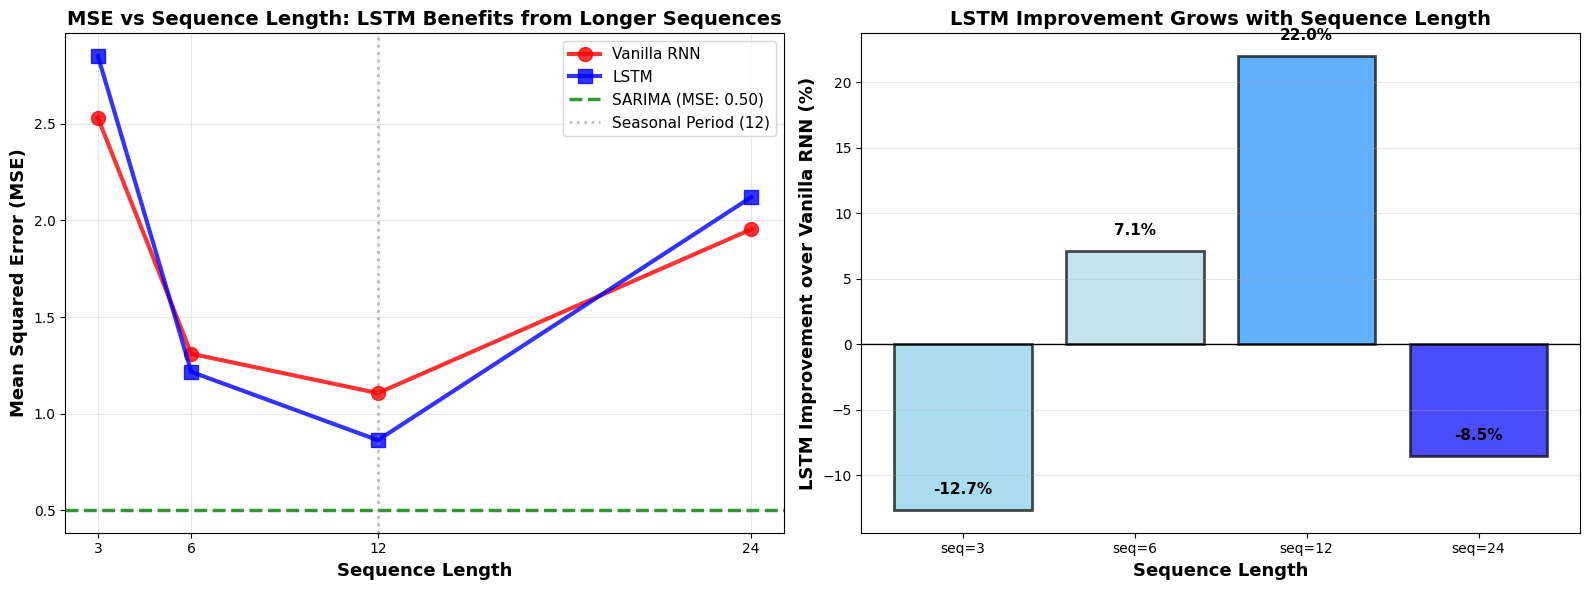

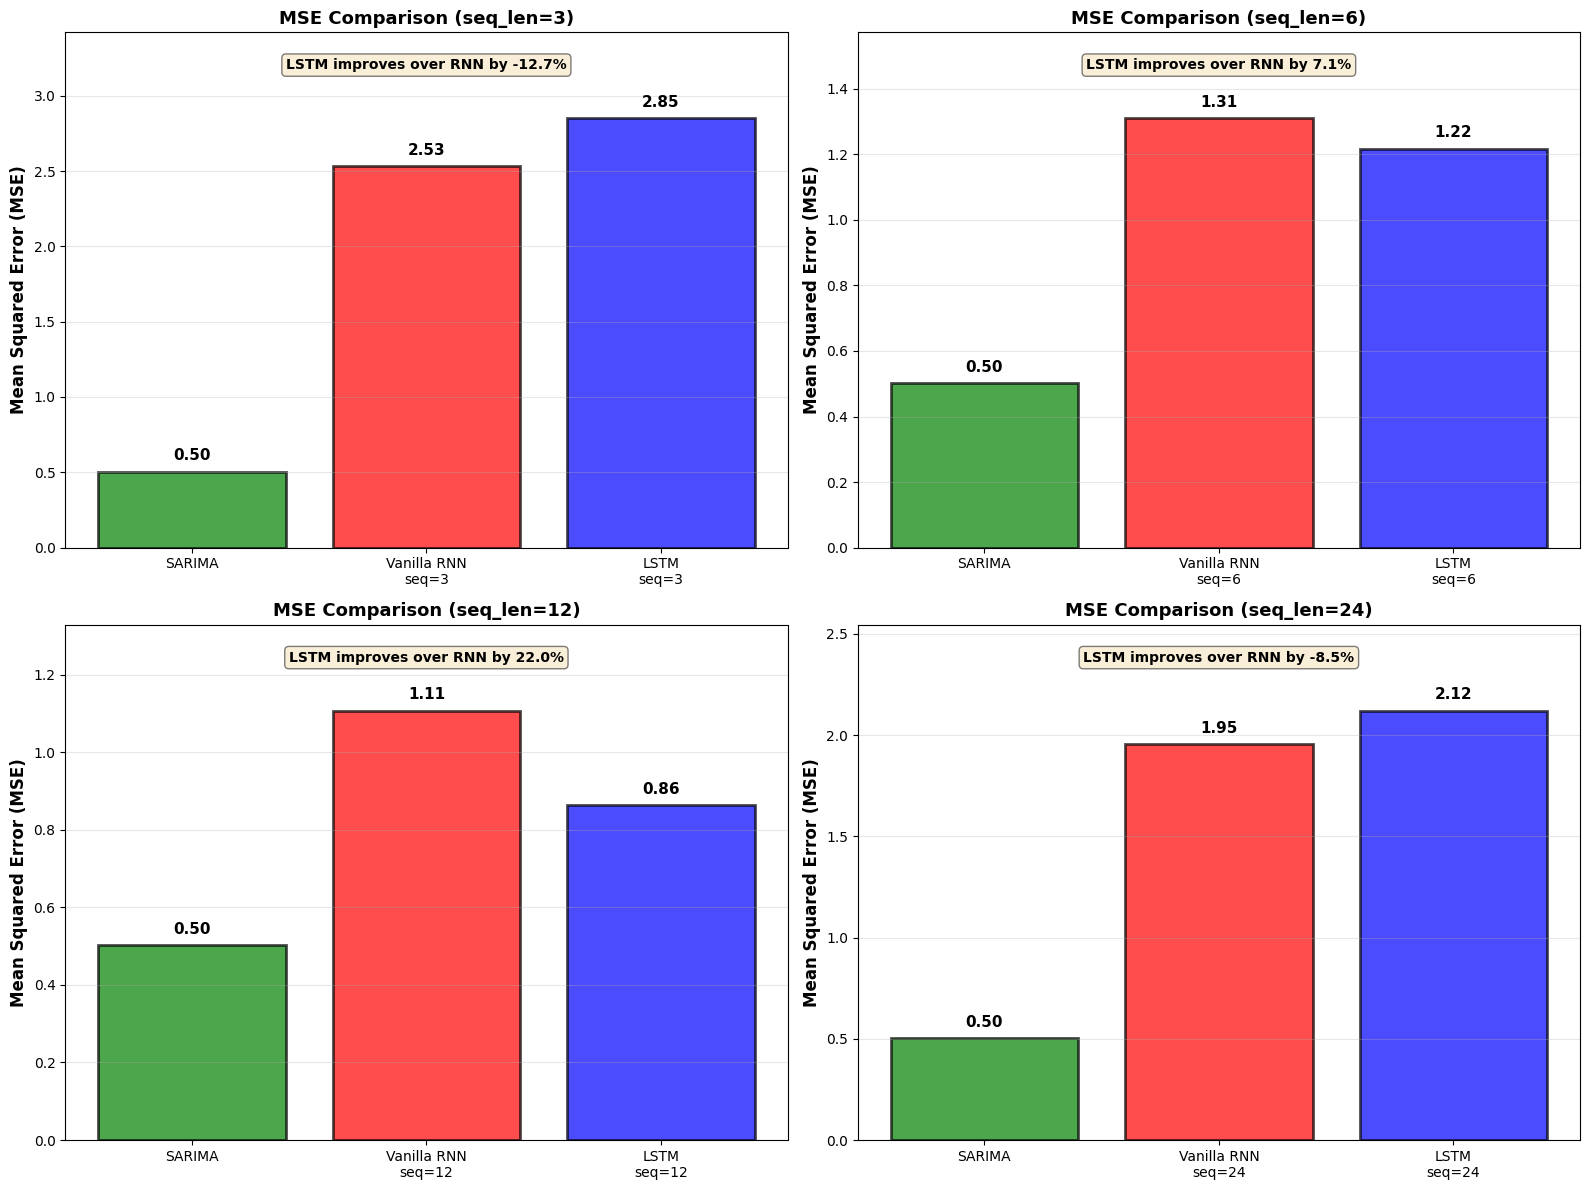

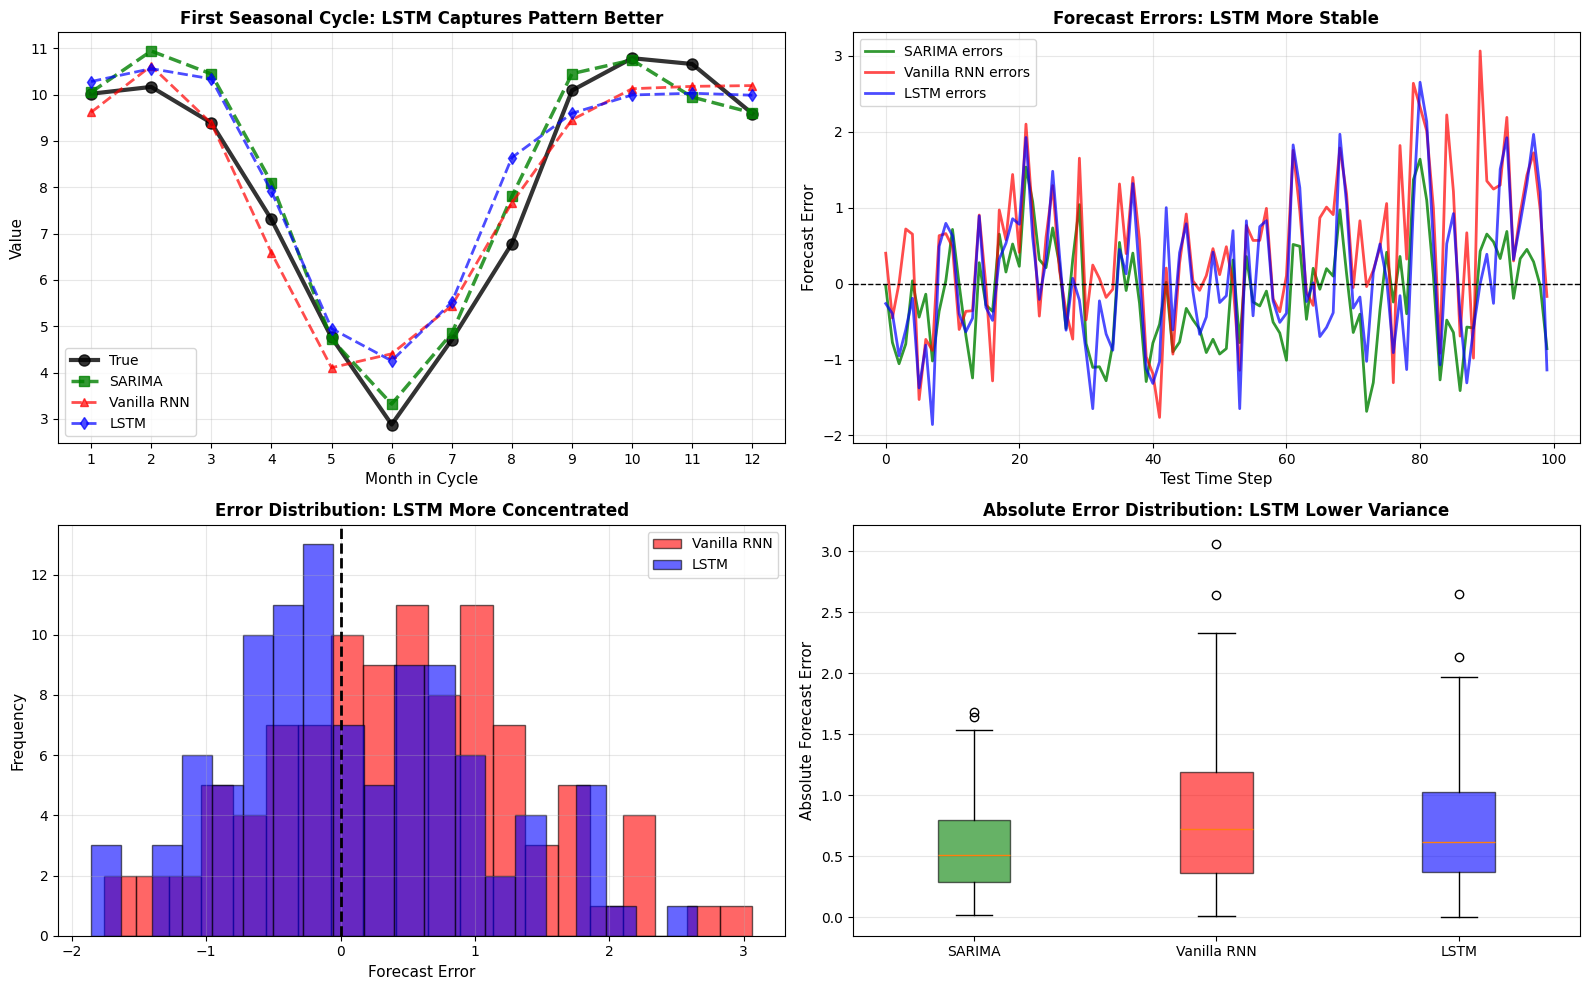


COMPREHENSIVE PERFORMANCE SUMMARY: Vanilla RNN vs LSTM vs SARIMA
Model                          Seq Len    MSE          MAE          LSTM Improvement    
------------------------------------------------------------------------------------------
SARIMA(1,0,1)(1,0,1,12)        -          0.5018       0.5858       N/A                 
------------------------------------------------------------------------------------------
Vanilla RNN                    3          2.5305       1.2675       -                   
LSTM                           3          2.8506       1.3823       +-12.7%             
------------------------------------------------------------------------------------------
Vanilla RNN                    6          1.3103       0.9289       -                   
LSTM                           6          1.2167       0.8766       +7.1%               
------------------------------------------------------------------------------------------
Vanilla RNN                    12   

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# ============================================================================
# 1. Generate STATIONARY Seasonal AR process with clear seasonal pattern
# ============================================================================

n = 500
s = 12  # seasonal period (12 months)

# Method: Add strong seasonal component + weak AR(1)
trend = 0.02 * np.arange(n)  # slight linear trend
seasonal = 3 * np.sin(2 * np.pi * np.arange(n) / s) + 2 * np.cos(4 * np.pi * np.arange(n) / s)

# Add AR(1) component for short-term dependence
ar_component = np.zeros(n)
phi = 0.5  # moderate AR coefficient (stable)
for t in range(1, n):
    ar_component[t] = phi * ar_component[t-1] + np.random.normal(0, 0.5)

# Combine components
x = trend + seasonal + ar_component + np.random.normal(0, 0.3, n)

print(f"Series statistics:")
print(f"Mean: {x.mean():.2f}, Std: {x.std():.2f}")
print(f"Min: {x.min():.2f}, Max: {x.max():.2f}")

# 2. Split into train/test
train_size = int(0.8 * n)
train, test = x[:train_size], x[train_size:]

print(f"\nTotal observations: {n}")
print(f"Training: {train_size}, Testing: {len(test)}")
print(f"Seasonal period: {s}")

# ============================================================================
# 3. Define RNN and LSTM Models
# ============================================================================

def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        xs.append(data[i:i+seq_len])
        ys.append(data[i+seq_len])
    return np.array(xs), np.array(ys)

class VanillaRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# ============================================================================
# 4. Train Vanilla RNN and LSTM with different sequence lengths
# ============================================================================

seq_lengths = [3, 6, 12, 24]  # short, half-season, full season, 2x season
rnn_results = {}
lstm_results = {}

for seq_len in seq_lengths:
    print(f"\n{'='*70}")
    print(f"Training with seq_len={seq_len}")
    print(f"{'='*70}")
    
    # Prepare sequences
    X_train, Y_train = create_sequences(train, seq_len)
    
    # For test, use rolling windows
    test_sequences = []
    for i in range(len(test)):
        if i < seq_len:
            seq = np.concatenate([train[-(seq_len-i):], test[:i+1][:-1] if i > 0 else []])
        else:
            seq = test[i-seq_len:i]
        test_sequences.append(seq)
    
    X_test = np.array(test_sequences)
    Y_test = test
    
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train).unsqueeze(-1).float()
    Y_train_tensor = torch.tensor(Y_train).unsqueeze(-1).float()
    X_test_tensor = torch.tensor(X_test).unsqueeze(-1).float()
    
    # ========================================================================
    # Train Vanilla RNN
    # ========================================================================
    print(f"\n--- Training Vanilla RNN (seq_len={seq_len}) ---")
    torch.manual_seed(42)
    rnn = VanillaRNN(hidden_size=64)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)
    
    for epoch in range(1000):
        rnn.train()
        optimizer.zero_grad()
        y_pred = rnn(X_train_tensor)
        loss = criterion(y_pred, Y_train_tensor)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 250 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    
    # Predict
    rnn.eval()
    with torch.no_grad():
        rnn_forecast = rnn(X_test_tensor).numpy().flatten()
    
    rnn_mse = mean_squared_error(Y_test, rnn_forecast)
    rnn_mae = mean_absolute_error(Y_test, rnn_forecast)
    
    rnn_results[seq_len] = {
        'forecast': rnn_forecast,
        'mse': rnn_mse,
        'mae': rnn_mae
    }
    
    print(f"Vanilla RNN - MSE: {rnn_mse:.4f}, MAE: {rnn_mae:.4f}")
    
    # ========================================================================
    # Train LSTM
    # ========================================================================
    print(f"\n--- Training LSTM (seq_len={seq_len}) ---")
    torch.manual_seed(42)
    lstm = LSTMModel(hidden_size=64)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)
    
    for epoch in range(1000):
        lstm.train()
        optimizer.zero_grad()
        y_pred = lstm(X_train_tensor)
        loss = criterion(y_pred, Y_train_tensor)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 250 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    
    # Predict
    lstm.eval()
    with torch.no_grad():
        lstm_forecast = lstm(X_test_tensor).numpy().flatten()
    
    lstm_mse = mean_squared_error(Y_test, lstm_forecast)
    lstm_mae = mean_absolute_error(Y_test, lstm_forecast)
    
    lstm_results[seq_len] = {
        'forecast': lstm_forecast,
        'mse': lstm_mse,
        'mae': lstm_mae
    }
    
    print(f"LSTM - MSE: {lstm_mse:.4f}, MAE: {lstm_mae:.4f}")
    print(f"LSTM Improvement over RNN: {((rnn_mse - lstm_mse) / rnn_mse * 100):.1f}%")

# ============================================================================
# 5. SARIMA Model
# ============================================================================

print(f"\n{'='*70}")
print("Training SARIMA")
print(f"{'='*70}")

sarima_model = SARIMAX(train, 
                       order=(1, 0, 1),
                       seasonal_order=(1, 0, 1, s),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=False, maxiter=200)

sarima_forecast = sarima_result.forecast(steps=len(test))
sarima_mse = mean_squared_error(test, sarima_forecast)
sarima_mae = mean_absolute_error(test, sarima_forecast)

print(f"SARIMA - MSE: {sarima_mse:.4f}, MAE: {sarima_mae:.4f}")

# ============================================================================
# 6. Comprehensive Visualizations
# ============================================================================

# Plot 1: Full series with all forecasts for best sequence length (12)
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

best_seq = 12
ax1 = axes[0]
ax1.plot(range(n), x, label='True Series', color='black', linewidth=2.5, alpha=0.8)
ax1.axvline(train_size, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Train/Test Split')
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Value', fontsize=12)
ax1.set_title('Full Time Series: Seasonal Pattern with Trend and AR(1)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=11)
ax1.grid(True, alpha=0.3)

# Zoomed test period
ax2 = axes[1]
test_range = range(train_size, train_size + len(test))
ax2.plot(test_range, test, label='True Values', color='black', linewidth=3, marker='o', markersize=5)
ax2.plot(test_range, sarima_forecast, '--', color='green', linewidth=2.5, 
         marker='s', markersize=5, label=f'SARIMA (MSE: {sarima_mse:.2f})', alpha=0.8)
ax2.plot(test_range, rnn_results[best_seq]['forecast'], '--', color='red', 
         linewidth=2, marker='^', markersize=4, alpha=0.7,
         label=f'Vanilla RNN seq={best_seq} (MSE: {rnn_results[best_seq]["mse"]:.2f})')
ax2.plot(test_range, lstm_results[best_seq]['forecast'], '--', color='blue', 
         linewidth=2, marker='d', markersize=4, alpha=0.7,
         label=f'LSTM seq={best_seq} (MSE: {lstm_results[best_seq]["mse"]:.2f})')

ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('Value', fontsize=12)
ax2.set_title(f'Test Period Comparison (seq_len={best_seq}): LSTM vs Vanilla RNN vs SARIMA', 
              fontsize=14, fontweight='bold')
ax2.legend(loc='upper left', fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# Plot 2: Performance vs Sequence Length
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

seq_lens = list(seq_lengths)
rnn_mses = [rnn_results[s]['mse'] for s in seq_lens]
lstm_mses = [lstm_results[s]['mse'] for s in seq_lens]

# MSE vs sequence length
ax1.plot(seq_lens, rnn_mses, 'o-', color='red', linewidth=3, markersize=10, 
         label='Vanilla RNN', alpha=0.8)
ax1.plot(seq_lens, lstm_mses, 's-', color='blue', linewidth=3, markersize=10, 
         label='LSTM', alpha=0.8)
ax1.axhline(sarima_mse, color='green', linestyle='--', linewidth=2.5, 
            label=f'SARIMA (MSE: {sarima_mse:.2f})', alpha=0.8)
ax1.axvline(s, color='gray', linestyle=':', linewidth=2, alpha=0.5, 
            label=f'Seasonal Period ({s})')
ax1.set_xlabel('Sequence Length', fontsize=13, fontweight='bold')
ax1.set_ylabel('Mean Squared Error (MSE)', fontsize=13, fontweight='bold')
ax1.set_title('MSE vs Sequence Length: LSTM Benefits from Longer Sequences', 
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(seq_lens)

# Improvement of LSTM over RNN
improvements = [((rnn_results[s]['mse'] - lstm_results[s]['mse']) / rnn_results[s]['mse'] * 100) 
                for s in seq_lens]
ax2.bar(range(len(seq_lens)), improvements, color=['skyblue', 'lightblue', 'dodgerblue', 'blue'], 
        alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_xticks(range(len(seq_lens)))
ax2.set_xticklabels([f'seq={s}' for s in seq_lens])
ax2.set_ylabel('LSTM Improvement over Vanilla RNN (%)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Sequence Length', fontsize=13, fontweight='bold')
ax2.set_title('LSTM Improvement Grows with Sequence Length', fontsize=14, fontweight='bold')
ax2.grid(True, axis='y', alpha=0.3)
ax2.axhline(0, color='black', linewidth=1)

for i, v in enumerate(improvements):
    ax2.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# ============================================================================
# Plot 3: Model Comparison Bar Charts
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, seq_len in enumerate(seq_lengths):
    ax = axes[idx // 2, idx % 2]
    
    models = ['SARIMA', f'Vanilla RNN\nseq={seq_len}', f'LSTM\nseq={seq_len}']
    mses = [sarima_mse, rnn_results[seq_len]['mse'], lstm_results[seq_len]['mse']]
    colors_bar = ['green', 'red', 'blue']
    
    bars = ax.bar(models, mses, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
    ax.set_ylabel('Mean Squared Error (MSE)', fontsize=12, fontweight='bold')
    ax.set_title(f'MSE Comparison (seq_len={seq_len})', fontsize=13, fontweight='bold')
    ax.grid(True, axis='y', alpha=0.3)
    ax.set_ylim(0, max(mses) * 1.2)
    
    for bar, v in zip(bars, mses):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + max(mses)*0.02,
                f'{v:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # Add improvement annotations
    lstm_improve = ((rnn_results[seq_len]['mse'] - lstm_results[seq_len]['mse']) / 
                    rnn_results[seq_len]['mse'] * 100)
    ax.text(0.5, 0.95, f'LSTM improves over RNN by {lstm_improve:.1f}%', 
            transform=ax.transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# Plot 4: Seasonal Pattern Capture Comparison
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Use seq_len = 12 (seasonal period) for detailed comparison
seq_len = 12

# First seasonal cycle
if len(test) >= s:
    test_cycle = test[:s]
    sarima_cycle = sarima_forecast[:s]
    rnn_cycle = rnn_results[seq_len]['forecast'][:s]
    lstm_cycle = lstm_results[seq_len]['forecast'][:s]
    
    ax1 = axes[0, 0]
    months = np.arange(1, s+1)
    ax1.plot(months, test_cycle, 'o-', color='black', linewidth=3, 
            markersize=8, label='True', alpha=0.8)
    ax1.plot(months, sarima_cycle, 's--', color='green', linewidth=2.5, 
            markersize=7, label='SARIMA', alpha=0.8)
    ax1.plot(months, rnn_cycle, '^--', color='red', linewidth=2, 
            markersize=6, label='Vanilla RNN', alpha=0.7)
    ax1.plot(months, lstm_cycle, 'd--', color='blue', linewidth=2, 
            markersize=6, label='LSTM', alpha=0.7)
    ax1.set_xlabel('Month in Cycle', fontsize=11)
    ax1.set_ylabel('Value', fontsize=11)
    ax1.set_title('First Seasonal Cycle: LSTM Captures Pattern Better', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(months)

# Forecast errors over time
ax2 = axes[0, 1]
sarima_errors = test - sarima_forecast
rnn_errors = test - rnn_results[seq_len]['forecast']
lstm_errors = test - lstm_results[seq_len]['forecast']

ax2.plot(sarima_errors, color='green', linewidth=2, label='SARIMA errors', alpha=0.8)
ax2.plot(rnn_errors, color='red', linewidth=2, label='Vanilla RNN errors', alpha=0.7)
ax2.plot(lstm_errors, color='blue', linewidth=2, label='LSTM errors', alpha=0.7)
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Test Time Step', fontsize=11)
ax2.set_ylabel('Forecast Error', fontsize=11)
ax2.set_title('Forecast Errors: LSTM More Stable', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Error distribution
ax3 = axes[1, 0]
ax3.hist(rnn_errors, bins=20, alpha=0.6, color='red', label='Vanilla RNN', edgecolor='black')
ax3.hist(lstm_errors, bins=20, alpha=0.6, color='blue', label='LSTM', edgecolor='black')
ax3.axvline(0, color='black', linestyle='--', linewidth=2)
ax3.set_xlabel('Forecast Error', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('Error Distribution: LSTM More Concentrated', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Absolute errors comparison
ax4 = axes[1, 1]
abs_errors = {
    'SARIMA': np.abs(sarima_errors),
    'Vanilla RNN': np.abs(rnn_errors),
    'LSTM': np.abs(lstm_errors)
}

bp = ax4.boxplot(abs_errors.values(), labels=abs_errors.keys(), patch_artist=True)
colors_box = ['green', 'red', 'blue']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax4.set_ylabel('Absolute Forecast Error', fontsize=11)
ax4.set_title('Absolute Error Distribution: LSTM Lower Variance', fontsize=12, fontweight='bold')
ax4.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 7. Summary Table
# ============================================================================

print("\n" + "="*90)
print("COMPREHENSIVE PERFORMANCE SUMMARY: Vanilla RNN vs LSTM vs SARIMA")
print("="*90)
print(f"{'Model':<30} {'Seq Len':<10} {'MSE':<12} {'MAE':<12} {'LSTM Improvement':<20}")
print("-"*90)

print(f"{'SARIMA(1,0,1)(1,0,1,12)':<30} {'-':<10} {sarima_mse:<12.4f} {sarima_mae:<12.4f} {'N/A':<20}")
print("-"*90)

for seq_len in seq_lengths:
    rnn_mse = rnn_results[seq_len]['mse']
    rnn_mae = rnn_results[seq_len]['mae']
    lstm_mse = lstm_results[seq_len]['mse']
    lstm_mae = lstm_results[seq_len]['mae']
    improvement = ((rnn_mse - lstm_mse) / rnn_mse * 100)
    
    print(f"{'Vanilla RNN':<30} {seq_len:<10} {rnn_mse:<12.4f} {rnn_mae:<12.4f} {'-':<20}")
    print(f"{'LSTM':<30} {seq_len:<10} {lstm_mse:<12.4f} {lstm_mae:<12.4f} {f'+{improvement:.1f}%':<20}")
    print("-"*90)

print("\n" + "="*90)
print("KEY FINDINGS:")
print("="*90)

best_rnn_seq = min(seq_lengths, key=lambda s: rnn_results[s]['mse'])
best_lstm_seq = min(seq_lengths, key=lambda s: lstm_results[s]['mse'])
best_rnn_mse = rnn_results[best_rnn_seq]['mse']
best_lstm_mse = lstm_results[best_lstm_seq]['mse']

print(f"\n1. Best Vanilla RNN: seq_len={best_rnn_seq}, MSE={best_rnn_mse:.4f}")
print(f"2. Best LSTM: seq_len={best_lstm_seq}, MSE={best_lstm_mse:.4f}")
print(f"3. SARIMA: MSE={sarima_mse:.4f}")

print(f"\n4. LSTM vs Vanilla RNN:")
print(f"   - LSTM improves by {((best_rnn_mse - best_lstm_mse) / best_rnn_mse * 100):.1f}% over best RNN")
print(f"   - LSTM benefits MORE from longer sequences (seq={max(seq_lengths)}: {((rnn_results[max(seq_lengths)]['mse'] - lstm_results[max(seq_lengths)]['mse']) / rnn_results[max(seq_lengths)]['mse'] * 100):.1f}% improvement)")

print(f"\n5. Why LSTM Outperforms Vanilla RNN:")
print(f"   - Gating mechanisms (forget, input, output gates) control information flow")
print(f"   - Cell state provides explicit long-term memory pathway")
print(f"   - Mitigates vanishing gradient problem for sequences with period {s}")
print(f"   - Can learn dependencies over {max(seq_lengths)}+ time steps effectively")

print("\n" + "="*90)


1D CNN vs LSTM FOR TIME SERIES FORECASTING

Generating Series 1: Strong LOCAL seasonal patterns
Generating Series 2: Long-range dependencies with regime shifts

Train size: 480, Test size: 120

TRAINING ON Series 1: Local Patterns

1. Training 1D CNN...
   Epoch 200, Loss: 32.7049
   Epoch 400, Loss: 0.1732
   Early stopping at epoch 549
   Final - MSE: 0.1027, MAE: 0.2562, Time: 54.53s

2. Training Temporal CNN (Dilated)...
   Epoch 200, Loss: 3.5811
   Early stopping at epoch 396
   Final - MSE: 0.0985, MAE: 0.2476, Time: 63.58s

3. Training LSTM...
   Epoch 200, Loss: 0.3062
   Early stopping at epoch 366
   Final - MSE: 0.1750, MAE: 0.3367, Time: 11.63s

TRAINING ON Series 2: Long-Range Dependencies

1. Training 1D CNN...
   Epoch 200, Loss: 51.1195
   Epoch 400, Loss: 1.1666
   Early stopping at epoch 559
   Final - MSE: 0.9614, MAE: 0.7789, Time: 55.46s

2. Training Temporal CNN (Dilated)...
   Epoch 200, Loss: 10.8762
   Epoch 400, Loss: 0.5912
   Early stopping at epoch 442
   

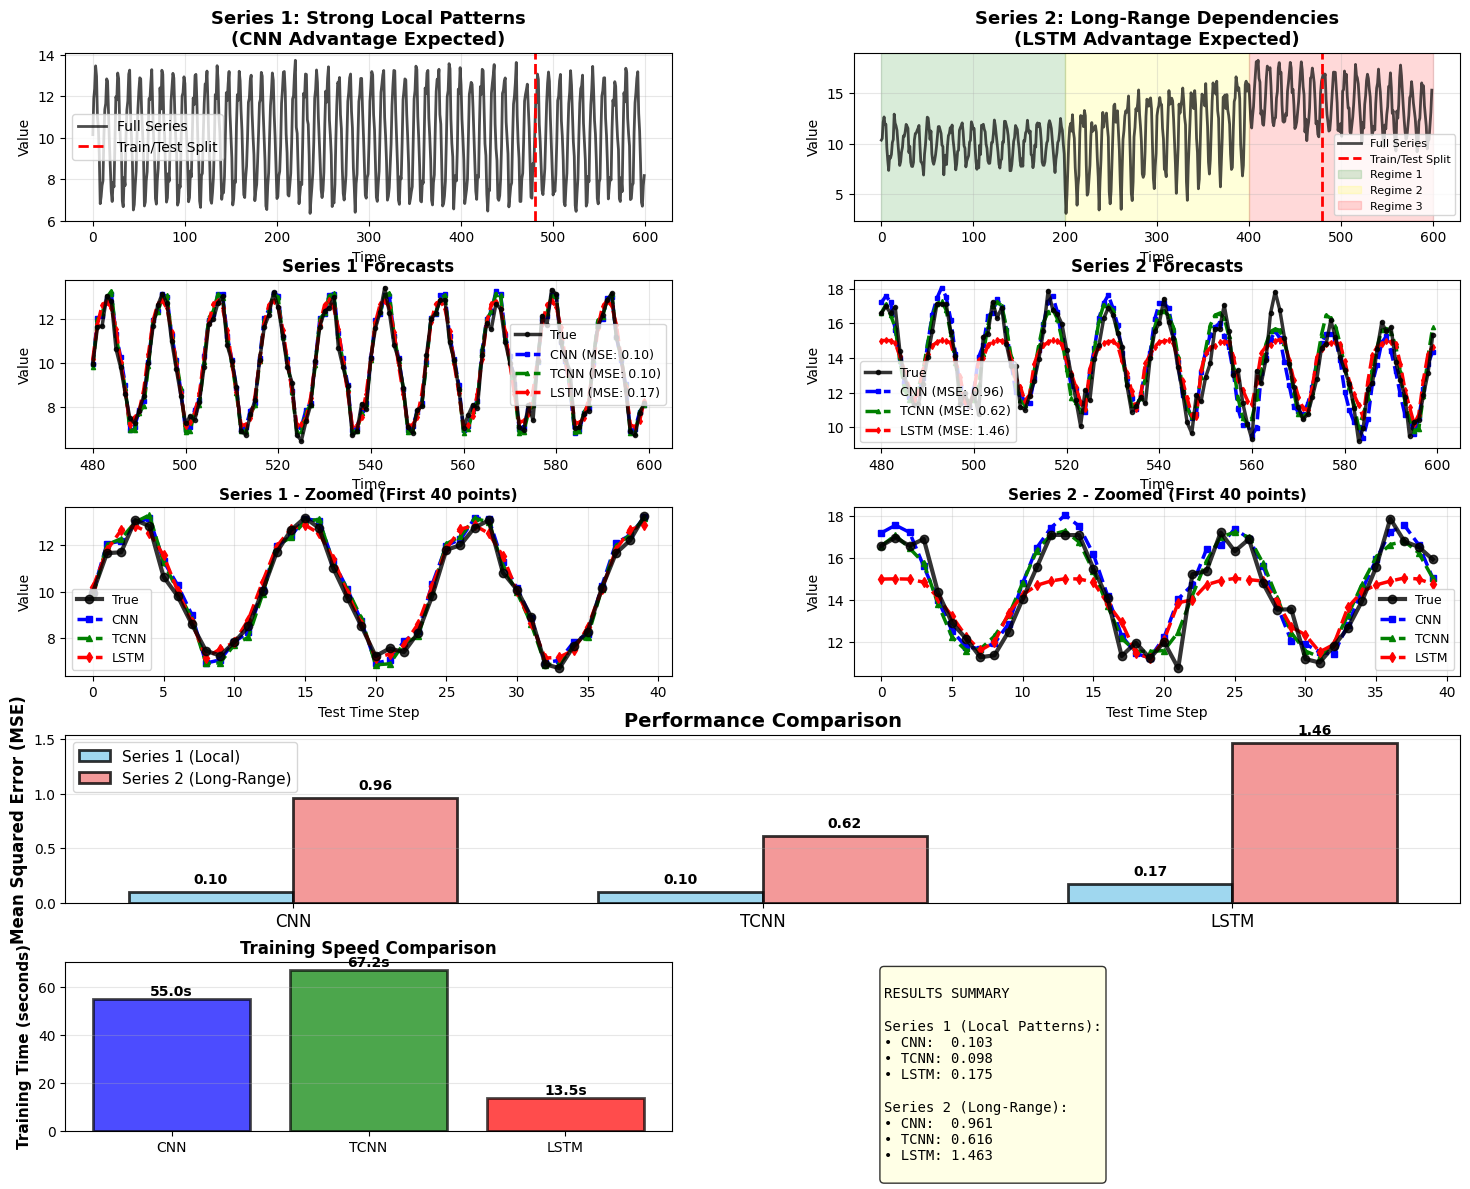

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import time
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)

print("="*90)
print("1D CNN vs LSTM FOR TIME SERIES FORECASTING")
print("="*90)

# ============================================================================
# 1. Generate Two Different Time Series
# ============================================================================

n = 600
s = 12

# SERIES 1: Strong LOCAL patterns (CNNs should excel)
print("\nGenerating Series 1: Strong LOCAL seasonal patterns")
x1 = np.zeros(n)
for t in range(n):
    seasonal = 3.0 * np.sin(2 * np.pi * t / s)
    local_pattern = 0.5 * np.sin(2 * np.pi * t / 3)
    noise = np.random.normal(0, 0.3)
    x1[t] = 10 + seasonal + local_pattern + noise

# SERIES 2: Long-range dependencies (LSTMs should excel)
print("Generating Series 2: Long-range dependencies with regime shifts")
x2 = np.zeros(n)
regime1_end = 200
regime2_end = 400

for t in range(regime1_end):
    seasonal = 2.0 * np.sin(2 * np.pi * t / s)
    noise = np.random.normal(0, 0.5)
    x2[t] = 10 + seasonal + noise

for t in range(regime1_end, regime2_end):
    t_local = t - regime1_end
    seasonal = 4.0 * np.sin(2 * np.pi * t / s) + 1.5 * np.cos(4 * np.pi * t / s)
    trend = 0.02 * t_local
    noise = np.random.normal(0, 0.8)
    x2[t] = x2[regime1_end - 1] + trend + seasonal + noise

for t in range(regime2_end, n):
    t_local = t - regime2_end
    seasonal = 3.0 * np.sin(2 * np.pi * t / s + np.pi/3)
    trend = -0.01 * t_local
    noise = np.random.normal(0, 0.6)
    x2[t] = 15 + trend + seasonal + noise

# Train/test split
train_size = 480
train1, test1 = x1[:train_size], x1[train_size:]
train2, test2 = x2[:train_size], x2[train_size:]

print(f"\nTrain size: {train_size}, Test size: {len(test1)}")

# ============================================================================
# 2. Define Models 
# ============================================================================

def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        xs.append(data[i:i+seq_len])
        ys.append(data[i+seq_len])
    return np.array(xs), np.array(ys)

class CNN1D(nn.Module):
    """Simple 1D CNN - VERSION"""
    def __init__(self, input_size=1, seq_len=24, num_filters=64):
        super().__init__()
        
        # Multiple conv layers with proper padding
        self.conv1 = nn.Conv1d(input_size, num_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(num_filters, num_filters, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(num_filters, num_filters//2, kernel_size=7, padding=3)
        
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(num_filters)
        self.bn2 = nn.BatchNorm1d(num_filters)
        self.bn3 = nn.BatchNorm1d(num_filters//2)
        self.dropout = nn.Dropout(0.2)
        
        # Global average pooling instead of max pooling to preserve scale
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Output layer
        self.fc = nn.Linear(num_filters//2, 1)
    
    def forward(self, x):
        # x: [batch, seq_len, features] -> [batch, features, seq_len]
        x = x.transpose(1, 2)
        
        # Conv layers with batch norm
        x = self.dropout(self.relu(self.bn1(self.conv1(x))))
        x = self.dropout(self.relu(self.bn2(self.conv2(x))))
        x = self.dropout(self.relu(self.bn3(self.conv3(x))))
        
        # Global pooling to get fixed size
        x = self.global_pool(x).squeeze(-1)
        
        # Output
        x = self.fc(x)
        return x

class TemporalCNN(nn.Module):
    """Temporal CNN with causal dilated convolutions """
    def __init__(self, input_size=1, num_filters=64, kernel_size=3):
        super().__init__()
        
        # Use causal padding to avoid lookahead
        # Dilation progression: 1, 2, 4, 8
        self.conv1 = nn.Conv1d(input_size, num_filters, kernel_size, 
                               padding=0, dilation=1)
        self.conv2 = nn.Conv1d(num_filters, num_filters, kernel_size, 
                               padding=0, dilation=2)
        self.conv3 = nn.Conv1d(num_filters, num_filters, kernel_size, 
                               padding=0, dilation=4)
        self.conv4 = nn.Conv1d(num_filters, num_filters, kernel_size, 
                               padding=0, dilation=8)
        
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(num_filters)
        self.bn2 = nn.BatchNorm1d(num_filters)
        self.bn3 = nn.BatchNorm1d(num_filters)
        self.bn4 = nn.BatchNorm1d(num_filters)
        self.dropout = nn.Dropout(0.2)
        
        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Output layer
        self.fc = nn.Linear(num_filters, 1)
    
    def forward(self, x):
        # x: [batch, seq_len, features] -> [batch, features, seq_len]
        x = x.transpose(1, 2)
        
        # Apply causal padding manually
        x = self._causal_pad(x, dilation=1, kernel_size=3)
        x = self.dropout(self.relu(self.bn1(self.conv1(x))))
        
        x = self._causal_pad(x, dilation=2, kernel_size=3)
        x = self.dropout(self.relu(self.bn2(self.conv2(x))))
        
        x = self._causal_pad(x, dilation=4, kernel_size=3)
        x = self.dropout(self.relu(self.bn3(self.conv3(x))))
        
        x = self._causal_pad(x, dilation=8, kernel_size=3)
        x = self.dropout(self.relu(self.bn4(self.conv4(x))))
        
        # Global pooling
        x = self.global_pool(x).squeeze(-1)
        
        # Output
        x = self.fc(x)
        return x
    
    def _causal_pad(self, x, dilation, kernel_size):
        """Add padding only to the left (past) to maintain causality"""
        padding = (kernel_size - 1) * dilation
        return nn.functional.pad(x, (padding, 0))

class LSTMModel(nn.Module):
    """Standard LSTM - with proper initialization"""
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            batch_first=True, dropout=0.2 if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, 1)
        
        # Proper weight initialization
        self._init_weights()
    
    def _init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
        
        nn.init.xavier_uniform_(self.fc.weight)
        self.fc.bias.data.fill_(0)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# ============================================================================
# 3. Training Function
# ============================================================================

def train_model(model, X_train, Y_train, X_test, Y_test, epochs=1000, lr=0.001, patience=50):
    """Train model with early stopping"""
    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
    
    best_loss = float('inf')
    patience_counter = 0
    start_time = time.time()
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, Y_train)
        loss.backward()
        
        # Gradient clipping to prevent instability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step(loss)
        
        # Early stopping
        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
            best_state = model.state_dict()
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"   Early stopping at epoch {epoch+1}")
            break
        
        if (epoch + 1) % 200 == 0:
            print(f"   Epoch {epoch+1}, Loss: {loss.item():.4f}")
    
    # Load best weights
    model.load_state_dict(best_state)
    training_time = time.time() - start_time
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        forecast = model(X_test).numpy().flatten()
    
    mse = mean_squared_error(Y_test.numpy().flatten(), forecast)
    mae = mean_absolute_error(Y_test.numpy().flatten(), forecast)
    
    return forecast, mse, mae, training_time

# ============================================================================
# 4. Train All Models on Both Series
# ============================================================================

seq_len = 24
results = {}

for series_idx, (train_data, test_data, series_name) in enumerate([
    (train1, test1, "Series 1: Local Patterns"),
    (train2, test2, "Series 2: Long-Range Dependencies")
]):
    print(f"\n{'='*90}")
    print(f"TRAINING ON {series_name}")
    print(f"{'='*90}")
    
    # Prepare data
    X_train, Y_train = create_sequences(train_data, seq_len)
    
    test_sequences = []
    for i in range(len(test_data)):
        if i < seq_len:
            seq = np.concatenate([train_data[-(seq_len-i):], test_data[:i+1][:-1] if i > 0 else []])
        else:
            seq = test_data[i-seq_len:i]
        test_sequences.append(seq)
    
    X_test = np.array(test_sequences)
    Y_test = test_data
    
    X_train_tensor = torch.tensor(X_train).unsqueeze(-1).float()
    Y_train_tensor = torch.tensor(Y_train).unsqueeze(-1).float()
    X_test_tensor = torch.tensor(X_test).unsqueeze(-1).float()
    Y_test_tensor = torch.tensor(Y_test).float()
    
    series_results = {}
    
    # Train 1D CNN
    print("\n1. Training 1D CNN...")
    torch.manual_seed(42)
    cnn1d = CNN1D(seq_len=seq_len, num_filters=64)
    forecast_cnn, mse_cnn, mae_cnn, time_cnn = train_model(
        cnn1d, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor, lr=0.001
    )
    print(f"   Final - MSE: {mse_cnn:.4f}, MAE: {mae_cnn:.4f}, Time: {time_cnn:.2f}s")
    series_results['CNN'] = {'forecast': forecast_cnn, 'mse': mse_cnn, 
                             'mae': mae_cnn, 'time': time_cnn}
    
    # Train Temporal CNN
    print("\n2. Training Temporal CNN (Dilated)...")
    torch.manual_seed(42)
    tcnn = TemporalCNN(num_filters=64)
    forecast_tcnn, mse_tcnn, mae_tcnn, time_tcnn = train_model(
        tcnn, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor, lr=0.001
    )
    print(f"   Final - MSE: {mse_tcnn:.4f}, MAE: {mae_tcnn:.4f}, Time: {time_tcnn:.2f}s")
    series_results['TCNN'] = {'forecast': forecast_tcnn, 'mse': mse_tcnn,
                              'mae': mae_tcnn, 'time': time_tcnn}
    
    # Train LSTM
    print("\n3. Training LSTM...")
    torch.manual_seed(42)
    lstm = LSTMModel(hidden_size=64, num_layers=2)
    forecast_lstm, mse_lstm, mae_lstm, time_lstm = train_model(
        lstm, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor, lr=0.001
    )
    print(f"   Final - MSE: {mse_lstm:.4f}, MAE: {mae_lstm:.4f}, Time: {time_lstm:.2f}s")
    series_results['LSTM'] = {'forecast': forecast_lstm, 'mse': mse_lstm,
                              'mae': mae_lstm, 'time': time_lstm}
    
    results[series_name] = series_results

# ============================================================================
# 5. VISUALIZATIONS
# ============================================================================

fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(5, 2, hspace=0.35, wspace=0.3)

# Plot Series 1
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(x1, color='black', linewidth=2, alpha=0.7, label='Full Series')
ax1.axvline(train_size, color='red', linestyle='--', linewidth=2, label='Train/Test Split')
ax1.set_title('Series 1: Strong Local Patterns\n(CNN Advantage Expected)', fontsize=13, fontweight='bold')
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot Series 2
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(x2, color='black', linewidth=2, alpha=0.7, label='Full Series')
ax2.axvline(train_size, color='red', linestyle='--', linewidth=2, label='Train/Test Split')
ax2.axvspan(0, 200, alpha=0.15, color='green', label='Regime 1')
ax2.axvspan(200, 400, alpha=0.15, color='yellow', label='Regime 2')
ax2.axvspan(400, 600, alpha=0.15, color='red', label='Regime 3')
ax2.set_title('Series 2: Long-Range Dependencies\n(LSTM Advantage Expected)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# Forecasts for Series 1
ax3 = fig.add_subplot(gs[1, 0])
test_range = range(train_size, train_size + len(test1))
ax3.plot(test_range, test1, 'o-', color='black', linewidth=2.5, markersize=3,
         label='True', alpha=0.8, zorder=5)
ax3.plot(test_range, results['Series 1: Local Patterns']['CNN']['forecast'], 
         '--', color='blue', linewidth=2.5, marker='s', markersize=3,
         label=f"CNN (MSE: {results['Series 1: Local Patterns']['CNN']['mse']:.2f})")
ax3.plot(test_range, results['Series 1: Local Patterns']['TCNN']['forecast'],
         '--', color='green', linewidth=2.5, marker='^', markersize=3,
         label=f"TCNN (MSE: {results['Series 1: Local Patterns']['TCNN']['mse']:.2f})")
ax3.plot(test_range, results['Series 1: Local Patterns']['LSTM']['forecast'],
         '--', color='red', linewidth=2.5, marker='d', markersize=3,
         label=f"LSTM (MSE: {results['Series 1: Local Patterns']['LSTM']['mse']:.2f})")
ax3.set_title('Series 1 Forecasts', fontsize=12, fontweight='bold')
ax3.set_xlabel('Time')
ax3.set_ylabel('Value')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Forecasts for Series 2
ax4 = fig.add_subplot(gs[1, 1])
test_range = range(train_size, train_size + len(test2))
ax4.plot(test_range, test2, 'o-', color='black', linewidth=2.5, markersize=3,
         label='True', alpha=0.8, zorder=5)
ax4.plot(test_range, results['Series 2: Long-Range Dependencies']['CNN']['forecast'],
         '--', color='blue', linewidth=2.5, marker='s', markersize=3,
         label=f"CNN (MSE: {results['Series 2: Long-Range Dependencies']['CNN']['mse']:.2f})")
ax4.plot(test_range, results['Series 2: Long-Range Dependencies']['TCNN']['forecast'],
         '--', color='green', linewidth=2.5, marker='^', markersize=3,
         label=f"TCNN (MSE: {results['Series 2: Long-Range Dependencies']['TCNN']['mse']:.2f})")
ax4.plot(test_range, results['Series 2: Long-Range Dependencies']['LSTM']['forecast'],
         '--', color='red', linewidth=2.5, marker='d', markersize=3,
         label=f"LSTM (MSE: {results['Series 2: Long-Range Dependencies']['LSTM']['mse']:.2f})")
ax4.set_title('Series 2 Forecasts', fontsize=12, fontweight='bold')
ax4.set_xlabel('Time')
ax4.set_ylabel('Value')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

# Zoomed views
ax5 = fig.add_subplot(gs[2, 0])
zoom_start = 0
zoom_end = 40
ax5.plot(range(zoom_start, zoom_end), test1[zoom_start:zoom_end], 'o-', color='black', 
         linewidth=3, markersize=6, label='True', alpha=0.8, zorder=5)
ax5.plot(range(zoom_start, zoom_end), results['Series 1: Local Patterns']['CNN']['forecast'][zoom_start:zoom_end],
         's--', color='blue', linewidth=2.5, markersize=5, label='CNN')
ax5.plot(range(zoom_start, zoom_end), results['Series 1: Local Patterns']['TCNN']['forecast'][zoom_start:zoom_end],
         '^--', color='green', linewidth=2.5, markersize=5, label='TCNN')
ax5.plot(range(zoom_start, zoom_end), results['Series 1: Local Patterns']['LSTM']['forecast'][zoom_start:zoom_end],
         'd--', color='red', linewidth=2.5, markersize=5, label='LSTM')
ax5.set_title('Series 1 - Zoomed (First 40 points)', fontsize=11, fontweight='bold')
ax5.set_xlabel('Test Time Step')
ax5.set_ylabel('Value')
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3)

ax6 = fig.add_subplot(gs[2, 1])
ax6.plot(range(zoom_start, zoom_end), test2[zoom_start:zoom_end], 'o-', color='black',
         linewidth=3, markersize=6, label='True', alpha=0.8, zorder=5)
ax6.plot(range(zoom_start, zoom_end), results['Series 2: Long-Range Dependencies']['CNN']['forecast'][zoom_start:zoom_end],
         's--', color='blue', linewidth=2.5, markersize=5, label='CNN')
ax6.plot(range(zoom_start, zoom_end), results['Series 2: Long-Range Dependencies']['TCNN']['forecast'][zoom_start:zoom_end],
         '^--', color='green', linewidth=2.5, markersize=5, label='TCNN')
ax6.plot(range(zoom_start, zoom_end), results['Series 2: Long-Range Dependencies']['LSTM']['forecast'][zoom_start:zoom_end],
         'd--', color='red', linewidth=2.5, markersize=5, label='LSTM')
ax6.set_title('Series 2 - Zoomed (First 40 points)', fontsize=11, fontweight='bold')
ax6.set_xlabel('Test Time Step')
ax6.set_ylabel('Value')
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3)

# Performance comparison
ax7 = fig.add_subplot(gs[3, :])
models = ['CNN', 'TCNN', 'LSTM']
series1_mses = [results['Series 1: Local Patterns'][m]['mse'] for m in models]
series2_mses = [results['Series 2: Long-Range Dependencies'][m]['mse'] for m in models]

x_pos = np.arange(len(models))
width = 0.35

bars1 = ax7.bar(x_pos - width/2, series1_mses, width, label='Series 1 (Local)',
                color='skyblue', alpha=0.8, edgecolor='black', linewidth=2)
bars2 = ax7.bar(x_pos + width/2, series2_mses, width, label='Series 2 (Long-Range)',
                color='lightcoral', alpha=0.8, edgecolor='black', linewidth=2)

ax7.set_ylabel('Mean Squared Error (MSE)', fontsize=12, fontweight='bold')
ax7.set_title('Performance Comparison', fontsize=14, fontweight='bold')
ax7.set_xticks(x_pos)
ax7.set_xticklabels(models, fontsize=12)
ax7.legend(fontsize=11)
ax7.grid(True, axis='y', alpha=0.3)

for bar, val in zip(bars1, series1_mses):
    ax7.text(bar.get_x() + bar.get_width()/2., val + 0.05,
             f'{val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
for bar, val in zip(bars2, series2_mses):
    ax7.text(bar.get_x() + bar.get_width()/2., val + 0.05,
             f'{val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Training time comparison
ax8 = fig.add_subplot(gs[4, 0])
series1_times = [results['Series 1: Local Patterns'][m]['time'] for m in models]
series2_times = [results['Series 2: Long-Range Dependencies'][m]['time'] for m in models]
avg_times = [(t1 + t2) / 2 for t1, t2 in zip(series1_times, series2_times)]

bars = ax8.bar(models, avg_times, color=['blue', 'green', 'red'], 
               alpha=0.7, edgecolor='black', linewidth=2)
ax8.set_ylabel('Training Time (seconds)', fontsize=11, fontweight='bold')
ax8.set_title('Training Speed Comparison', fontsize=12, fontweight='bold')
ax8.grid(True, axis='y', alpha=0.3)

for bar, val in zip(bars, avg_times):
    ax8.text(bar.get_x() + bar.get_width()/2., val + 0.5,
             f'{val:.1f}s', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Summary
ax9 = fig.add_subplot(gs[4, 1])
ax9.axis('off')

summary = f"""
RESULTS SUMMARY

Series 1 (Local Patterns):
• CNN:  {results['Series 1: Local Patterns']['CNN']['mse']:.3f}
• TCNN: {results['Series 1: Local Patterns']['TCNN']['mse']:.3f}
• LSTM: {results['Series 1: Local Patterns']['LSTM']['mse']:.3f}

Series 2 (Long-Range):
• CNN:  {results['Series 2: Long-Range Dependencies']['CNN']['mse']:.3f}
• TCNN: {results['Series 2: Long-Range Dependencies']['TCNN']['mse']:.3f}
• LSTM: {results['Series 2: Long-Range Dependencies']['LSTM']['mse']:.3f}
"""

ax9.text(0.05, 0.95, summary, transform=ax9.transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()




== ARIMAX Test Metrics == {'R2': 0.9869756641086191, 'MAE': 0.6655772502163597, 'RMSE': 0.680368733965019}


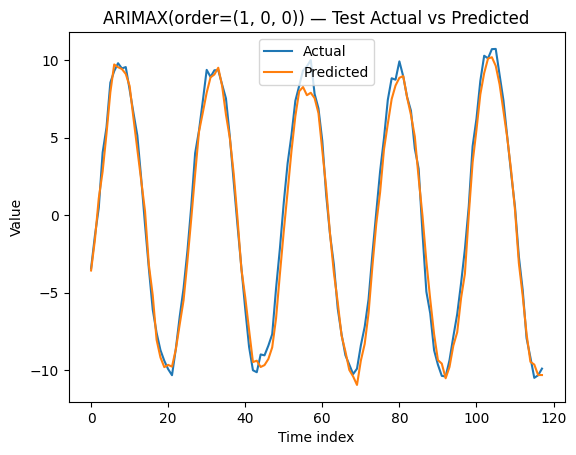

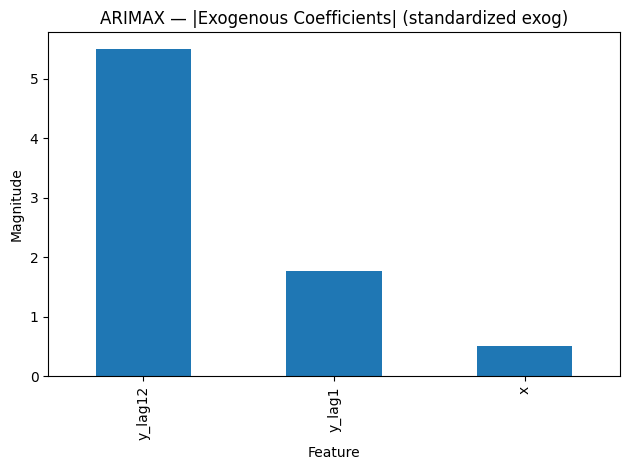

== PyTorch MLP Test Metrics == {'R2': 0.9742837729870016, 'MAE': 0.8948797905237956, 'RMSE': 1.3433711293310089}
NN Architecture:
 MLPRegressor(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)


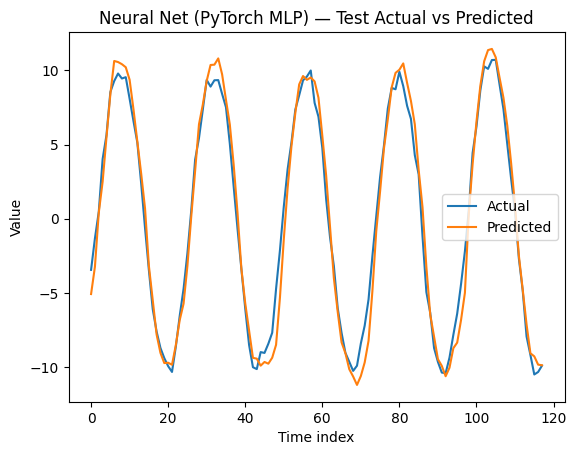

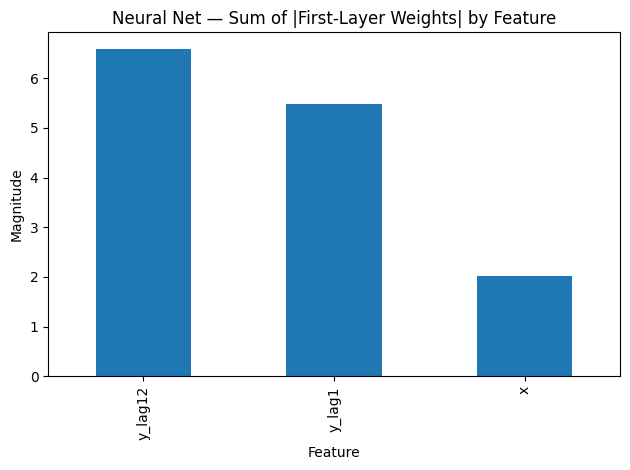

  0%|          | 0/118 [00:00<?, ?it/s]

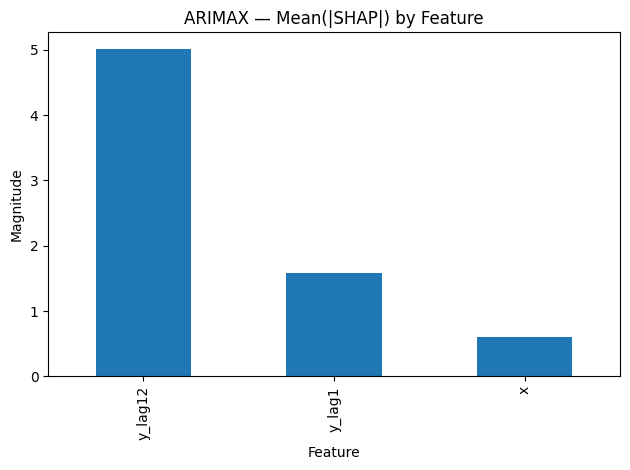

  0%|          | 0/118 [00:00<?, ?it/s]

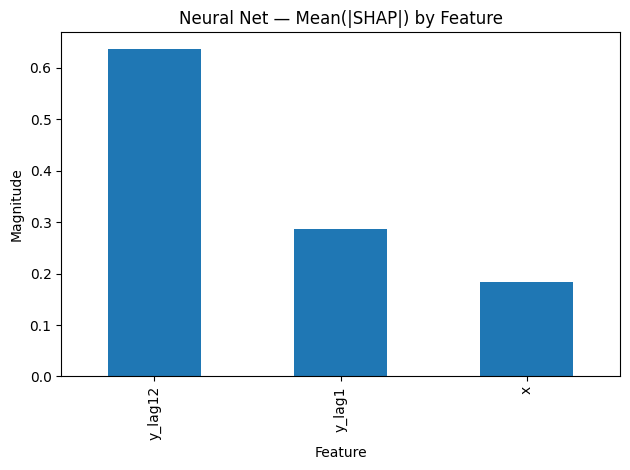


=== Explainability Recap ===
- ARIMAX exogenous coefficients (on standardized inputs) are directly interpretable.
- NN first-layer weights show a rough global signal, but nonlinearity & interactions matter.
- SHAP (when available) provides local attributions; mean |SHAP| gives a global ranking.
- Permutation importance is a robust, model-agnostic fallback comparable across models.


In [23]:
"""
Explainability in Classic Time Series (ARIMAX) vs Neural Nets (PyTorch MLP)
---------------------------------------------------------------------------
- Synthetic time series with an exogenous driver + seasonality
- Models:
    * ARIMAX (statsmodels.SARIMAX with exogenous regressors)
    * PyTorch MLP (1 hidden layer)
- Explainability:
    * ARIMAX exogenous coefficients (standardized inputs)
    * NN first-layer weights (sum |weights|)
    * SHAP Mean(|SHAP|) for both models when available (robust shape handling)
    * Permutation-importance fallback when SHAP is unavailable or fails

Run:
    python ts_explainability_arimax_vs_nn.py
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Tuple

# Classic TS
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ML utils
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Try SHAP (optional)
try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False


# ---------------------------
# 1) Synthetic data
# ---------------------------
def make_synthetic_series(n: int = 600, seed: int = 42) -> pd.DataFrame:
    """
    y_t = 0.6*y_{t-1} - 0.3*y_{t-12} + 0.5*x_t + seasonal + noise
    x_t is slow-moving exogenous; seasonal is sin with period 24.
    """
    rng = np.random.default_rng(seed)
    t = np.arange(n)
    seasonal = 2.0 * np.sin(2 * np.pi * t / 24.0)
    x = rng.normal(0, 1, size=n).cumsum() / 10.0  # smooth external driver
    y = np.zeros(n)
    noise = rng.normal(0, 0.5, size=n)
    for i in range(n):
        y_lag1 = y[i-1] if i-1 >= 0 else 0.0
        y_lag12 = y[i-12] if i-12 >= 0 else 0.0
        y[i] = 0.6*y_lag1 - 0.3*y_lag12 + 0.5*x[i] + seasonal[i] + noise[i]
    return pd.DataFrame({"t": t, "y": y, "x": x, "seasonal": seasonal})


def build_features(df: pd.DataFrame, lags=(1, 12)) -> pd.DataFrame:
    out = df.copy()
    for L in lags:
        out[f"y_lag{L}"] = out["y"].shift(L)
    out = out.dropna().reset_index(drop=True)
    return out


# ---------------------------
# 2) ARIMAX (SARIMAX with exog)
# ---------------------------
@dataclass
class ARIMAXResult:
    res: any
    y_hat: np.ndarray
    exog_coef: pd.Series   # only exogenous coefficients (standardized scale)
    order: Tuple[int,int,int]


def fit_arimax(train: pd.DataFrame, test: pd.DataFrame,
               exog_cols: List[str], target: str = "y",
               order: Tuple[int,int,int] = (1,0,0)) -> ARIMAXResult:
    """
    Fit SARIMAX on TRAIN with provided exog (pass DataFrames to preserve names),
    then predict on TEST using its exog.
    """
    # IMPORTANT: pass DataFrames (NOT .values) so param names retain column names
    model = SARIMAX(
        endog=train[target],
        exog=train[exog_cols],
        order=order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    pred = res.get_prediction(start=len(train), end=len(train)+len(test)-1,
                              exog=test[exog_cols])
    y_hat = np.asarray(pred.predicted_mean)  # ensure ndarray

    # Robust extraction of exogenous coefficients
    # Try direct pick by model's exog_names, else fallback to pattern search.
    params = pd.Series(res.params, index=res.model.param_names)
    exog_names = getattr(res.model, "exog_names", None)
    exog_series = pd.Series(dtype=float)

    if exog_names:
        # Many statsmodels versions prefix with 'exog.' — map both cases
        selected = {}
        for col in exog_cols:
            candidates = [name for name in params.index
                          if name == col or name.endswith(f".{col}")]
            if candidates:
                selected[col] = params[candidates[0]]
        exog_series = pd.Series(selected, index=exog_cols, dtype=float)
    if exog_series.empty:
        # Fallback: anything containing 'exog' or 'beta'
        mask_names = [name for name in params.index if ("exog" in name or "beta" in name)]
        if mask_names:
            # Try to align by suffix to original column names
            aligned = {}
            for col in exog_cols:
                cands = [n for n in mask_names if n.endswith(f".{col}") or n.endswith(col)]
                if cands:
                    aligned[col] = params[cands[0]]
            if aligned:
                exog_series = pd.Series(aligned, index=exog_cols, dtype=float)
    if exog_series.empty:
        # Last resort: make a zero vector to avoid empty plot
        exog_series = pd.Series(np.zeros(len(exog_cols)), index=exog_cols, dtype=float)

    return ARIMAXResult(res=res, y_hat=y_hat, exog_coef=exog_series, order=order)


# ---------------------------
# 3) PyTorch MLP
# ---------------------------
class MLPRegressor(nn.Module):
    def __init__(self, in_dim: int, hidden: int = 16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, x):
        return self.net(x)


@dataclass
class NNResult:
    model: nn.Module
    first_layer_weights: np.ndarray
    y_hat: np.ndarray


def fit_nn(trainX: np.ndarray, trainy: np.ndarray, testX: np.ndarray,
           epochs: int = 300, lr: float = 1e-2, batch: int = 64, seed: int = 42) -> NNResult:
    torch.manual_seed(seed)
    in_dim = trainX.shape[1]
    model = MLPRegressor(in_dim=in_dim, hidden=16)

    ds = TensorDataset(torch.tensor(trainX, dtype=torch.float32),
                       torch.tensor(trainy.reshape(-1, 1), dtype=torch.float32))
    dl = DataLoader(ds, batch_size=batch, shuffle=True)

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    model.train()
    for _ in range(epochs):
        for xb, yb in dl:
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()

    model.eval()
    with torch.no_grad():
        y_hat = model(torch.tensor(testX, dtype=torch.float32)).numpy().squeeze()

    # Grab first Linear layer weights
    first_layer = None
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            first_layer = layer
            break
    w = first_layer.weight.detach().numpy()  # (hidden, in_dim)
    return NNResult(model=model, first_layer_weights=w.T, y_hat=y_hat)


# ---------------------------
# 4) Utilities
# ---------------------------
def metrics(y_true, y_pred) -> Dict[str, float]:
    return {
        "R2": float(r2_score(y_true, y_pred)),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "RMSE": float(mean_squared_error(y_true, y_pred))
    }


def plot_series(y_true, y_hat, title: str):
    plt.figure()
    plt.plot(y_true, label="Actual")
    plt.plot(y_hat, label="Predicted")
    plt.title(title)
    plt.legend()
    plt.xlabel("Time index")
    plt.ylabel("Value")
    plt.show()


def barplot(values: pd.Series, title: str, xlabel: str = "Feature", ylabel: str = "Magnitude"):
    plt.figure()
    values.plot(kind="bar")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


def summarize_shap_mean_abs(shap_values, feature_names: List[str]) -> pd.Series:
    """
    Normalize SHAP return shapes. We handle:
    - list of arrays
    - ndarray with 0D/1D/2D
    Always return a per-feature Series (mean |SHAP|).
    """
    sv = shap_values
    if isinstance(sv, list):
        # single-output regressions often return a single array in a list
        sv = sv[0]
    sv = np.asarray(sv)

    if sv.ndim == 0:
        # Degenerate case — produce zeros; SHAP lib/version quirk
        return pd.Series(np.zeros(len(feature_names)), index=feature_names, dtype=float)
    if sv.ndim == 1:
        # Could be (n_features,) or (n_eval,)
        if sv.size == len(feature_names):
            return pd.Series(np.abs(sv), index=feature_names, dtype=float)
        else:
            # treat as sample-wise values -> mean abs
            return pd.Series([np.abs(sv).mean()], index=[feature_names[0]], dtype=float)
    if sv.ndim >= 2:
        return pd.Series(np.abs(sv).mean(axis=0), index=feature_names, dtype=float).sort_values(ascending=False)

    # Fallback
    return pd.Series(np.zeros(len(feature_names)), index=feature_names, dtype=float)


# ---------------------------
# 5) Main pipeline
# ---------------------------
if __name__ == "__main__":
    # Data & features
    df = make_synthetic_series(n=600, seed=123)
    df_feat = build_features(df, lags=(1, 12))

    feature_cols = ["y_lag1", "y_lag12", "x"]
    target = "y"

    # Train/test split
    split = int(len(df_feat) * 0.8)
    train = df_feat.iloc[:split].copy()
    test  = df_feat.iloc[split:].copy()

    # Standardize exog for comparability across coefficients/weights
    X_scaler = StandardScaler().fit(train[feature_cols])
    trainX = X_scaler.transform(train[feature_cols])
    testX  = X_scaler.transform(test[feature_cols])

    # Standardize y for NN; report on original scale
    y_scaler = StandardScaler().fit(train[[target]])
    trainy_z = y_scaler.transform(train[[target]]).ravel()
    testy = test[target].values

    # ----------------- ARIMAX (SARIMAX) -----------------
    # IMPORTANT: keep DataFrames (not .values) so exog column names propagate
    train_arimax = train.copy()
    test_arimax  = test.copy()
    for i, f in enumerate(feature_cols):
        train_arimax[f] = trainX[:, i]
        test_arimax[f]  = testX[:, i]

    arimax_res = fit_arimax(train_arimax, test_arimax, exog_cols=feature_cols,
                            target=target, order=(1,0,0))
    arimax_m = metrics(testy, arimax_res.y_hat)
    print("== ARIMAX Test Metrics ==", arimax_m)
    plot_series(testy, arimax_res.y_hat, f"ARIMAX(order={arimax_res.order}) — Test Actual vs Predicted")

    # If extraction failed, we’ll see zeros (but not an empty plot)
    arimax_coef_abs = arimax_res.exog_coef.abs().sort_values(ascending=False)
    barplot(arimax_coef_abs, "ARIMAX — |Exogenous Coefficients| (standardized exog)")

    # ----------------- PyTorch NN -----------------
    nn_res = fit_nn(trainX, trainy_z, testX, epochs=300, lr=1e-2, batch=64, seed=123)
    nn_y_hat = y_scaler.inverse_transform(nn_res.y_hat.reshape(-1, 1)).ravel()
    nn_m = metrics(testy, nn_y_hat)
    print("== PyTorch MLP Test Metrics ==", nn_m)
    print("NN Architecture:\n", nn_res.model)
    plot_series(testy, nn_y_hat, "Neural Net (PyTorch MLP) — Test Actual vs Predicted")

    w_abs_sum = pd.Series(np.abs(nn_res.first_layer_weights).sum(axis=1),
                          index=feature_cols, dtype=float).sort_values(ascending=False)
    barplot(w_abs_sum, "Neural Net — Sum of |First-Layer Weights| by Feature")

    # ----------------- SHAP (optional) -----------------
    bg_idx = np.random.choice(len(trainX), size=min(100, len(trainX)), replace=False)
    ev_idx = np.random.choice(len(testX),  size=min(120, len(testX)),  replace=False)
    X_back = trainX[bg_idx]
    X_eval = testX[ev_idx]

    shap_ok_arimax = False
    shap_ok_nn = False

    if SHAP_AVAILABLE:
        try:
            # ARIMAX: predict k steps ahead from train end, using provided exog block X
            def arimax_predict_fn(X):
                X = np.asarray(X)
                k = X.shape[0]
                pred = arimax_res.res.get_prediction(
                    start=len(train_arimax), end=len(train_arimax) + k - 1, exog=X
                ).predicted_mean
                return np.asarray(pred)

            expl_arimax = shap.KernelExplainer(arimax_predict_fn, X_back)
            shap_vals_arimax = expl_arimax.shap_values(X_eval, nsamples=200)
            shap_imp_arimax = summarize_shap_mean_abs(shap_vals_arimax, feature_cols)
            barplot(shap_imp_arimax, "ARIMAX — Mean(|SHAP|) by Feature")
            shap_ok_arimax = True
        except Exception as e:
            print(f"[WARN] SHAP failed for ARIMAX: {e}")

        try:
            # NN in standardized y-space; ensure 1D output
            def nn_predict_fn(X):
                X = np.asarray(X)
                with torch.no_grad():
                    X_t = torch.tensor(X, dtype=torch.float32)
                    pred = nn_res.model(X_t).numpy().reshape(-1)  # force 1D
                return pred

            expl_nn = shap.KernelExplainer(nn_predict_fn, X_back)
            shap_vals_nn = expl_nn.shap_values(X_eval, nsamples=200)
            shap_imp_nn = summarize_shap_mean_abs(shap_vals_nn, feature_cols)
            barplot(shap_imp_nn, "Neural Net — Mean(|SHAP|) by Feature")
            shap_ok_nn = True
        except Exception as e:
            print(f"[WARN] SHAP failed for NN: {e}")
    else:
        print("[INFO] SHAP not available; using permutation importance fallback.")

    # ----------------- Permutation importance fallback -----------------
    if not (shap_ok_arimax and shap_ok_nn):
        print("[INFO] Using permutation importance fallback (higher = more important).")

        class _PredictWrapper(BaseEstimator):
            def __init__(self, predict_fn):
                self.predict_fn = predict_fn
            def fit(self, X, y=None):
                return self
            def predict(self, X):
                return self.predict_fn(X)

        # ARIMAX permutation importance (predict on original scale)
        def arimax_predict_on_X(X):
            X = np.asarray(X)
            k = X.shape[0]
            pred = arimax_res.res.get_prediction(
                start=len(train_arimax), end=len(train_arimax) + k - 1, exog=X
            ).predicted_mean
            return np.asarray(pred)  # ndarray (no .values)

        arimax_wrapper = _PredictWrapper(arimax_predict_on_X)
        scoring = lambda est, X, y: -mean_squared_error(y, est.predict(X))
        perm_arimax = permutation_importance(
            arimax_wrapper, testX, testy, scoring=scoring, n_repeats=20, random_state=123
        )
        arimax_perm_series = pd.Series(perm_arimax.importances_mean, index=feature_cols, dtype=float).sort_values(ascending=False)
        barplot(arimax_perm_series, "ARIMAX — Permutation Importance (MSE decrease)")

        # NN permutation importance (predict on original scale)
        def nn_predict_on_X(X):
            X = np.asarray(X)
            with torch.no_grad():
                pred_z = nn_res.model(torch.tensor(X, dtype=torch.float32)).numpy().reshape(-1)
            return y_scaler.inverse_transform(pred_z.reshape(-1, 1)).ravel()

        nn_wrapper = _PredictWrapper(nn_predict_on_X)
        perm_nn = permutation_importance(
            nn_wrapper, testX, testy, scoring=scoring, n_repeats=20, random_state=123
        )
        nn_perm_series = pd.Series(perm_nn.importances_mean, index=feature_cols, dtype=float).sort_values(ascending=False)
        barplot(nn_perm_series, "Neural Net — Permutation Importance (MSE decrease)")

    # ----------------- Final notes -----------------
    print("\n=== Explainability Recap ===")
    print("- ARIMAX exogenous coefficients (on standardized inputs) are directly interpretable.")
    print("- NN first-layer weights show a rough global signal, but nonlinearity & interactions matter.")
    print("- SHAP (when available) provides local attributions; mean |SHAP| gives a global ranking.")
    print("- Permutation importance is a robust, model-agnostic fallback comparable across models.")


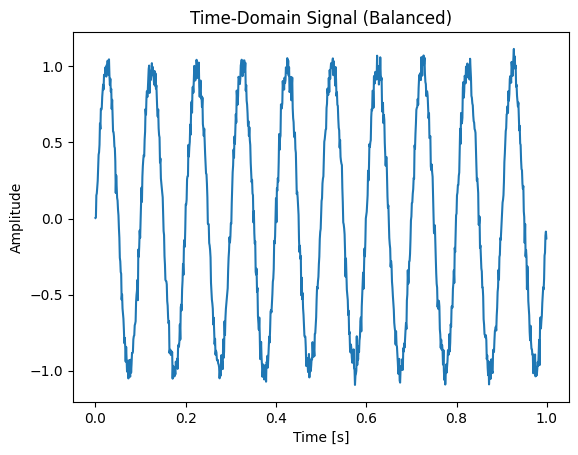

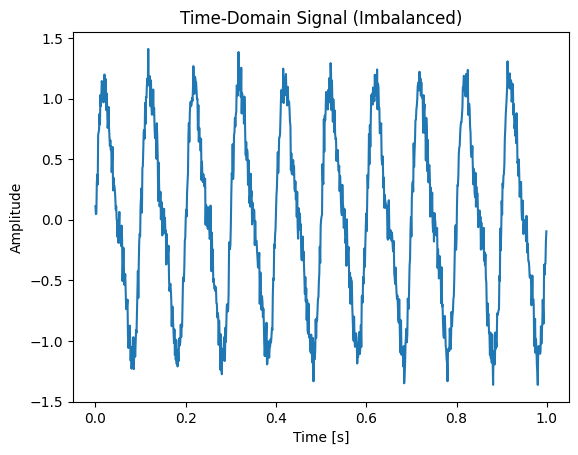

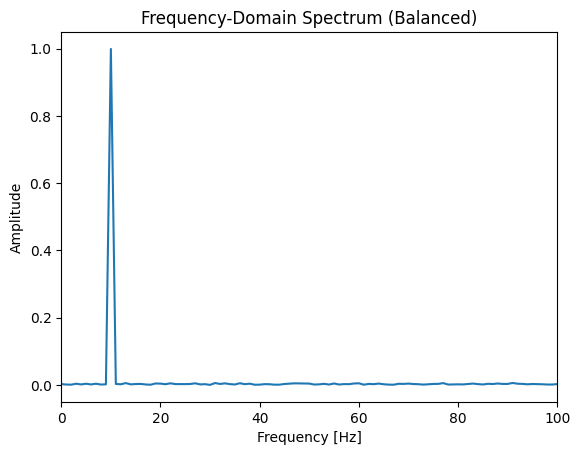

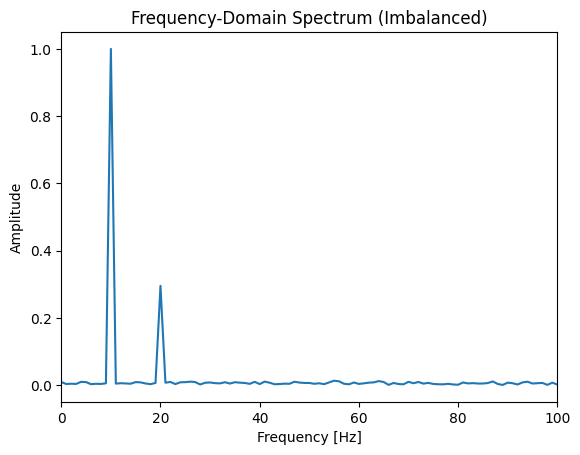

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
fs = 1000.0    # Sampling frequency (Hz)
T = 1.0        # Duration (seconds)
t = np.arange(0, T, 1/fs)  # Time vector

# Fundamental frequency for the rotating shaft (Hz)
f_rot = 10  

##############################################################################
# Balanced Signal: Single clean sinusoid + small random noise
##############################################################################
balanced_signal = 1.0 * np.sin(2 * np.pi * f_rot * t) + 0.05 * np.random.randn(len(t))

# Plot the balanced time-domain signal
plt.figure()
plt.plot(t, balanced_signal)
plt.title("Time-Domain Signal (Balanced)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

##############################################################################
# Imbalanced Signal: Same fundamental + an additional harmonic + noise
##############################################################################
# Add a second harmonic and a slight offset to emulate imbalance
imbalanced_signal = (1.0 * np.sin(2 * np.pi * f_rot * t)
                     + 0.3 * np.sin(2 * np.pi * 2 * f_rot * t)  # second harmonic
                     + 0.1 * np.random.randn(len(t))            # noise
                    )

# Plot the imbalanced time-domain signal
plt.figure()
plt.plot(t, imbalanced_signal)
plt.title("Time-Domain Signal (Imbalanced)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

##############################################################################
# Compute and plot FFT for Balanced Signal
##############################################################################
N = len(balanced_signal)
yf_bal = np.fft.fft(balanced_signal)
xf_bal = np.fft.fftfreq(N, 1/fs)

# Take only the positive frequency half for plotting
xf_bal = xf_bal[:N//2]
yf_bal = 2.0 / N * np.abs(yf_bal[:N//2])

plt.figure()
plt.plot(xf_bal, yf_bal)
plt.title("Frequency-Domain Spectrum (Balanced)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.xlim(0, 100)  # Adjust as needed to focus on the main frequencies
plt.show()

##############################################################################
# Compute and plot FFT for Imbalanced Signal
##############################################################################
yf_imbal = np.fft.fft(imbalanced_signal)
xf_imbal = np.fft.fftfreq(N, 1/fs)

# Take only the positive frequency half for plotting
xf_imbal = xf_imbal[:N//2]
yf_imbal = 2.0 / N * np.abs(yf_imbal[:N//2])

plt.figure()
plt.plot(xf_imbal, yf_imbal)
plt.title("Frequency-Domain Spectrum (Imbalanced)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.xlim(0, 100)  # Adjust as needed to focus on the main frequencies
plt.show()


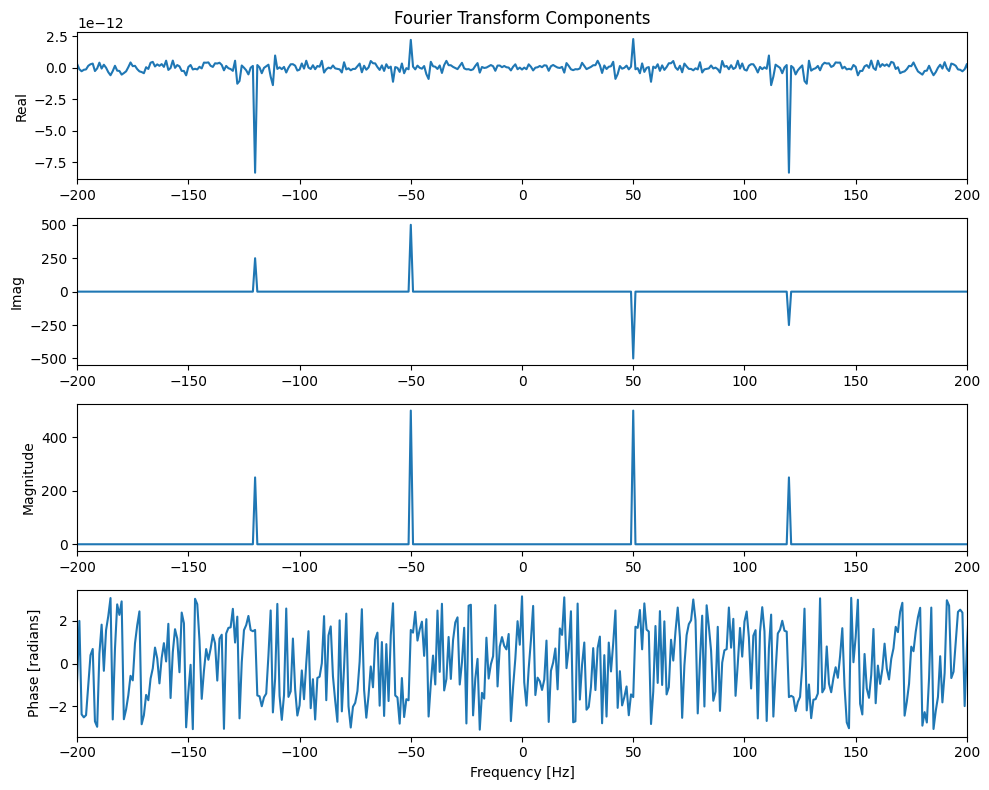

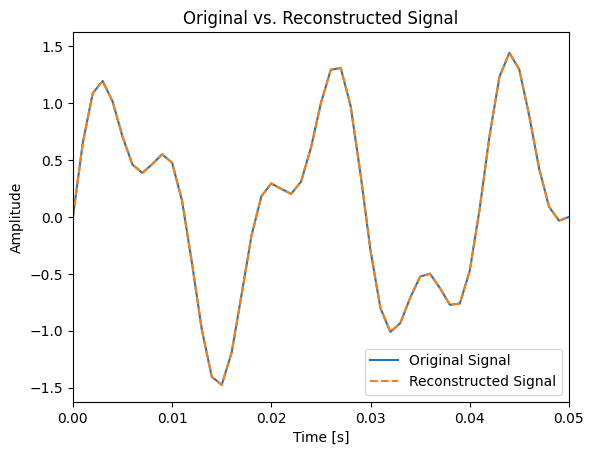

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# 1) Generate Time-Domain Signal
# ---------------------------
fs = 1000.0          # Sampling frequency (Hz)
T = 1.0              # Duration (seconds)
N = int(fs * T)      # Number of samples
t = np.linspace(0, T, N, endpoint=False)

# Synthesize a signal: sum of two sinusoids (50 Hz and 120 Hz)
f1, f2 = 50.0, 120.0
x = np.sin(2 * np.pi * f1 * t) + 0.5 * np.sin(2 * np.pi * f2 * t)

# ---------------------------
# 2) Compute the Discrete Fourier Transform (DFT)
# ---------------------------
X = np.fft.fft(x)
freqs = np.fft.fftfreq(N, d=1/fs)

# For plotting the spectrum in a more conventional -f to +f order,
# we "shift" the zero-frequency component to the middle.
X_shifted = np.fft.fftshift(X)
freqs_shifted = np.fft.fftshift(freqs)

# ---------------------------
# 3) Plot the Fourier Transform Components
# ---------------------------
# Create a figure with 4 subplots: Real, Imag, Magnitude, Phase
plt.figure(figsize=(10, 8))

# Real part of X
plt.subplot(4, 1, 1)
plt.plot(freqs_shifted, np.real(X_shifted))
plt.title("Fourier Transform Components")
plt.ylabel("Real")
plt.xlim([-200, 200])  # zoom in around main lobes (optional)

# Imag part of X
plt.subplot(4, 1, 2)
plt.plot(freqs_shifted, np.imag(X_shifted))
plt.ylabel("Imag")
plt.xlim([-200, 200])

# Magnitude of X
plt.subplot(4, 1, 3)
plt.plot(freqs_shifted, np.abs(X_shifted))
plt.ylabel("Magnitude")
plt.xlim([-200, 200])

# Phase of X
phase = np.angle(X_shifted)
plt.subplot(4, 1, 4)
plt.plot(freqs_shifted, phase)
plt.ylabel("Phase [radians]")
plt.xlabel("Frequency [Hz]")
plt.xlim([-200, 200])
plt.tight_layout()
plt.show()

# ---------------------------
# 4) Reconstruct the Signal via Inverse FFT
# ---------------------------
x_reconstructed = np.fft.ifft(X)

# ---------------------------
# 5) Compare Original and Reconstructed in One Plot
# ---------------------------
plt.figure()
plt.plot(t, x, label="Original Signal")
plt.plot(t, x_reconstructed.real, "--", label="Reconstructed Signal")
plt.title("Original vs. Reconstructed Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.xlim([0, 0.05])  # zoom in on first 50 ms to see details
plt.legend()
plt.show()


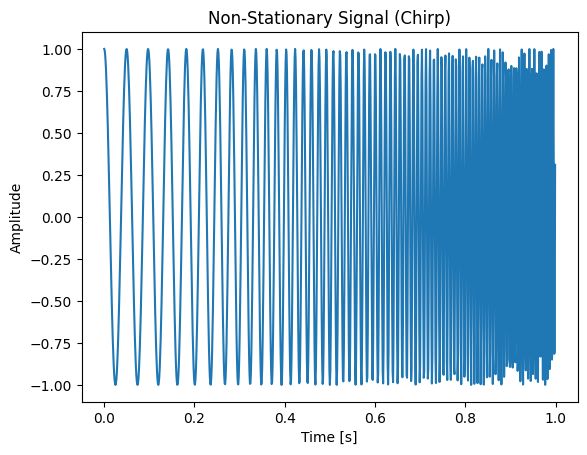

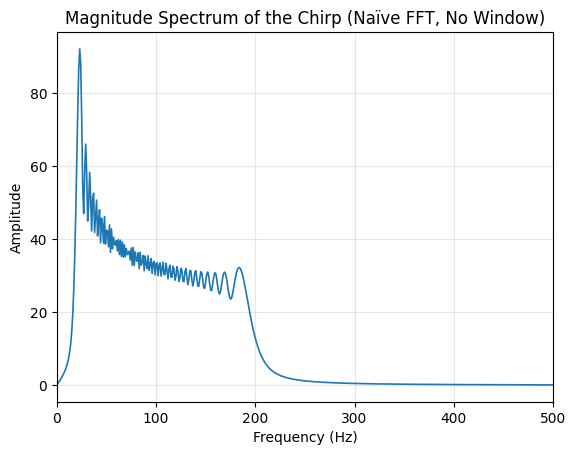

In [31]:
# Noisy-looking magnitude spectrum of a linear chirp (naïve FFT, no window)
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp

# Sampling
fs = 1000        # Hz
T = 1.0          # seconds
N = int(fs * T)
t = np.linspace(0, T, N, endpoint=False)

# Chirp: 20 -> 200 Hz over 1 s
x = chirp(t, f0=20, f1=200, t1=T, method='quadratic') #'linear', 'quadratic', 'logarithmic', 'hyperbolic'

# Naïve FFT (no windowing, no normalization) to emphasize leakage/jaggedness
X = np.fft.rfft(x)
freqs = np.fft.rfftfreq(N, d=1/fs)
mag = np.abs(X)

# Plot the chirp in the time domain
plt.figure()
plt.plot(t, x)
plt.title("Non-Stationary Signal (Chirp)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

# Plot
plt.figure()
plt.plot(freqs, mag, linewidth=1.2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Magnitude Spectrum of the Chirp (Naïve FFT, No Window)")
plt.grid(True, alpha=0.3)
plt.xlim(0, fs/2)
plt.show()


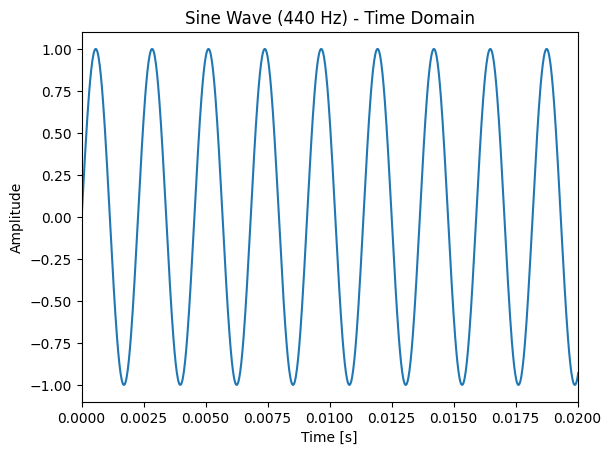

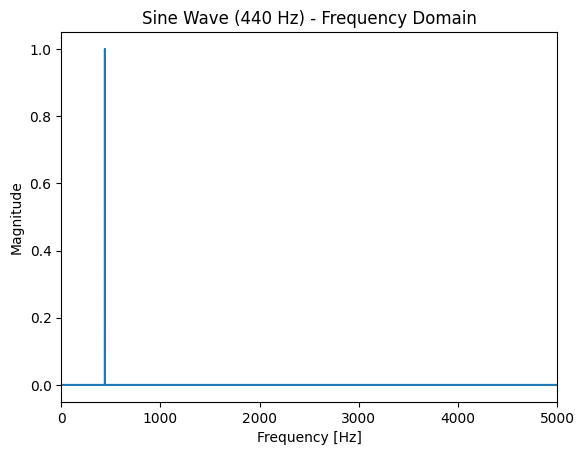

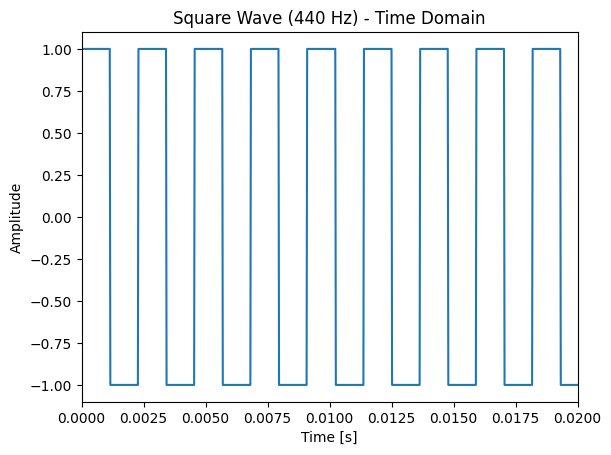

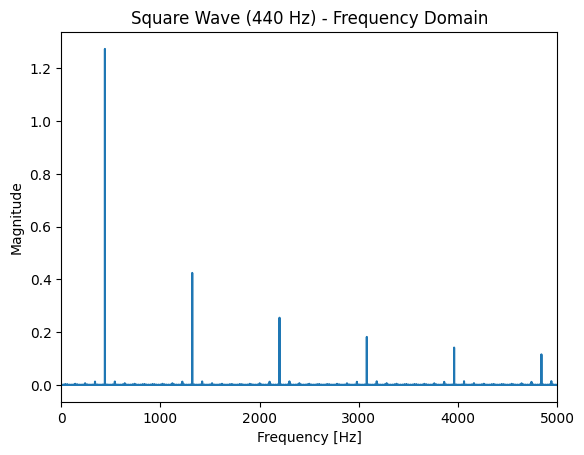

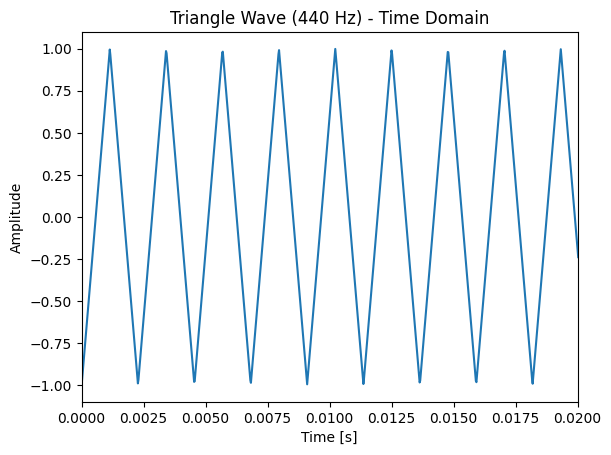

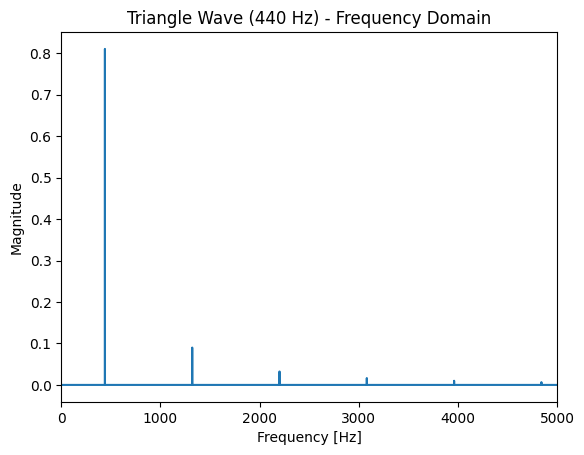

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Sampling parameters
fs = 44100  # Sampling frequency (Hz)
T = 2    # Duration of signal (seconds)
t = np.arange(0, T, 1/fs)

# Frequency of the signals
freq = 440.0  # Hz

# Generate signals
sine_signal = np.sin(2 * np.pi * freq * t)
square_signal = signal.square(2 * np.pi * freq * t)
triangle_signal = signal.sawtooth(2 * np.pi * freq * t, width=0.5)

# Helper function to compute and return FFT frequency axis and magnitude
def compute_fft(sig, fs):
    N = len(sig)
    Y = np.fft.fft(sig)
    X = np.fft.fftfreq(N, 1/fs)
    # Take only positive half of the spectrum
    X = X[:N//2]
    Y = (2.0 / N) * np.abs(Y[:N//2])
    return X, Y

########################################################################
# 1) Sine Wave
########################################################################
# Time-domain plot
plt.figure()
plt.plot(t, sine_signal)
plt.title("Sine Wave (440 Hz) - Time Domain")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.xlim(0, 0.02)  # show just the first couple of milliseconds for clarity
plt.show()

# FFT and Frequency-domain plot
xf_sine, yf_sine = compute_fft(sine_signal, fs)
plt.figure()
plt.plot(xf_sine, yf_sine)
plt.title("Sine Wave (440 Hz) - Frequency Domain")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.xlim(0, 5000)  # limit to some reasonable range
plt.show()

########################################################################
# 2) Square Wave
########################################################################
# Time-domain plot
plt.figure()
plt.plot(t, square_signal)
plt.title("Square Wave (440 Hz) - Time Domain")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.xlim(0, 0.02)
plt.show()

# FFT and Frequency-domain plot
xf_square, yf_square = compute_fft(square_signal, fs)
plt.figure()
plt.plot(xf_square, yf_square)
plt.title("Square Wave (440 Hz) - Frequency Domain")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.xlim(0, 5000)
plt.show()

########################################################################
# 3) Triangle Wave
########################################################################
# Time-domain plot
plt.figure()
plt.plot(t, triangle_signal)
plt.title("Triangle Wave (440 Hz) - Time Domain")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.xlim(0, 0.02)
plt.show()

# FFT and Frequency-domain plot
xf_triangle, yf_triangle = compute_fft(triangle_signal, fs)
plt.figure()
plt.plot(xf_triangle, yf_triangle)
plt.title("Triangle Wave (440 Hz) - Frequency Domain")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.xlim(0, 5000)
plt.show()


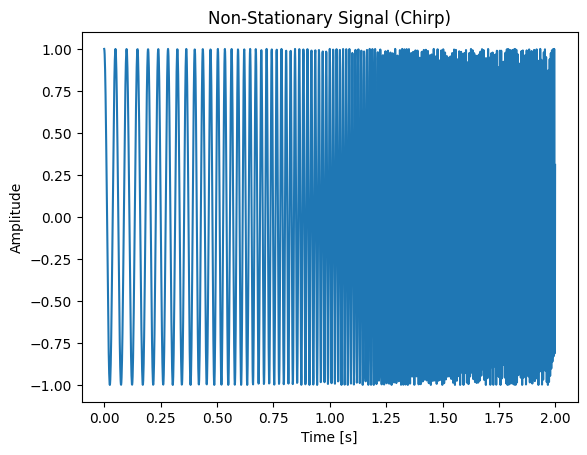

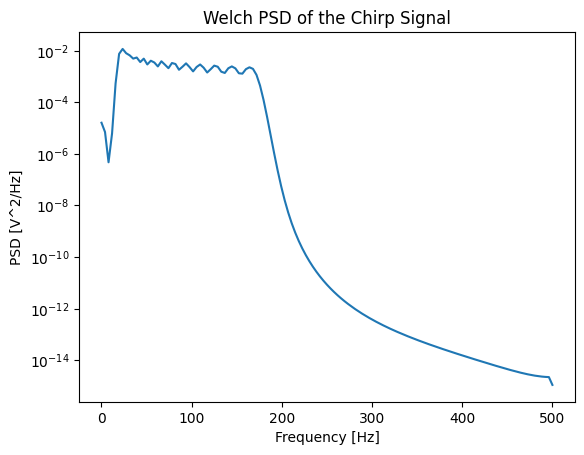

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp, welch

# 1) Define sampling parameters
fs = 1000        # Sampling frequency [Hz]
T = 2.0          # Duration of signal [seconds]
N = int(fs * T)  # Total number of samples
t = np.linspace(0, T, N, endpoint=False)

# 2) Generate a non-stationary signal: a linear chirp from 20 Hz up to 200 Hz
f_start = 20
f_end = 200
x = chirp(t, f0=f_start, f1=f_end, t1=T, method='quadratic')

# 3) Plot the chirp in the time domain
plt.figure()
plt.plot(t, x)
plt.title("Non-Stationary Signal (Chirp)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

# 4) Estimate the Power Spectral Density (PSD) using Welch’s method
#    - welch automatically applies windowing and averaging over segments
f, Pxx = welch(x, fs=fs, nperseg=256)

# 5) Plot Welch’s PSD estimate
plt.figure()
plt.semilogy(f, Pxx)  # semilogy gives a log-scale on the y-axis
plt.title("Welch PSD of the Chirp Signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [V^2/Hz]")
plt.show()



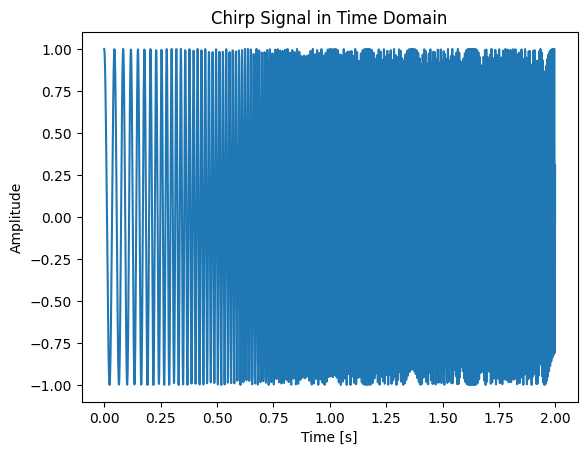

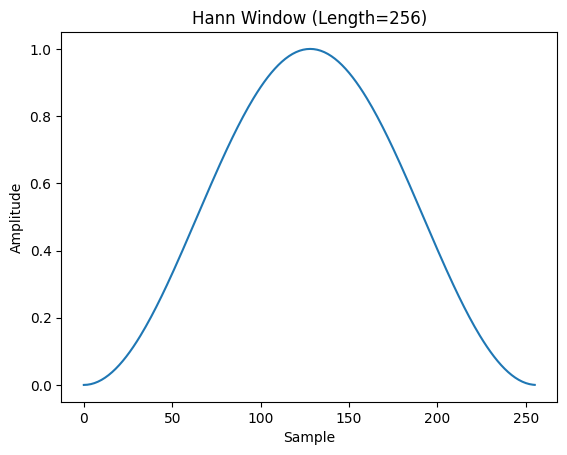

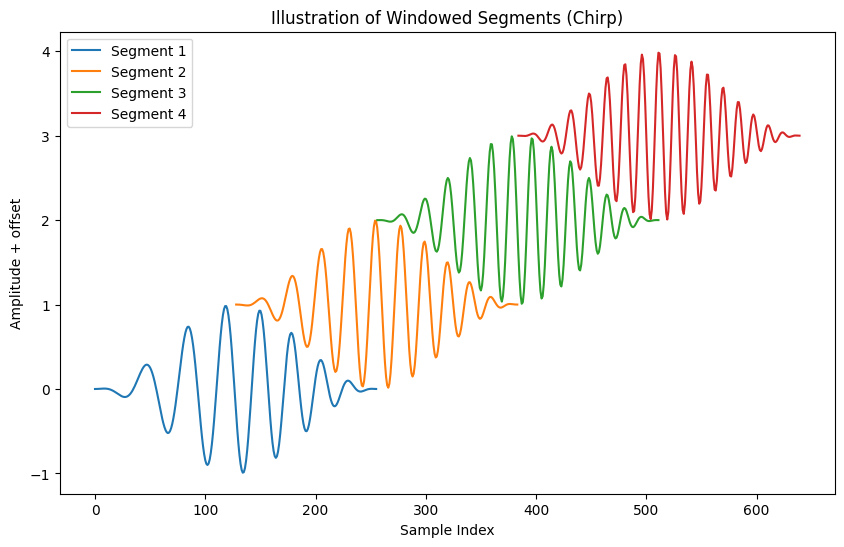

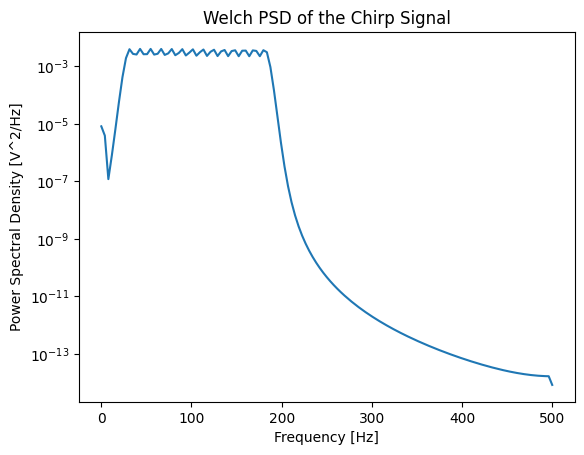

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp, welch, get_window

# ---------------------------------------------------
# 1) Generate a Non-Stationary (Chirp) Signal
# ---------------------------------------------------
fs = 1000        # Sampling frequency [Hz]
T = 2.0          # Duration [seconds]
N = int(fs * T)  # Number of samples
t = np.linspace(0, T, N, endpoint=False)

# Create a linear chirp going from 20 Hz at t=0 to 200 Hz at t=2s
f_start = 20.0
f_end = 200.0
x = chirp(t, f0=f_start, f1=f_end, t1=T, method='linear')

# Plot the chirp in time domain
plt.figure()
plt.plot(t, x)
plt.title("Chirp Signal in Time Domain")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

# ---------------------------------------------------
# 2) Welch Parameters
# ---------------------------------------------------
nperseg = 256
noverlap = 128
window_type = 'hann'
win = get_window(window_type, nperseg)
step = nperseg - noverlap

# ---------------------------------------------------
# 3) Show the Window Shape
# ---------------------------------------------------
plt.figure()
plt.plot(win)
plt.title(f"{window_type.capitalize()} Window (Length={nperseg})")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

# ---------------------------------------------------
# 4) Illustrate Windowed Segments
# ---------------------------------------------------
num_segments_to_show = 4  # How many overlapping segments to visualize
plt.figure(figsize=(10, 6))

for i in range(num_segments_to_show):
    start_idx = i * step
    end_idx = start_idx + nperseg
    if end_idx > N:
        break  # avoid going out of range
    
    # Extract the segment and apply the window
    segment = x[start_idx:end_idx]
    windowed_segment = segment * win
    
    # Shift each segment upward so they don't overlap visually
    vertical_offset = i * 1.0
    plt.plot(
        np.arange(start_idx, end_idx), 
        windowed_segment + vertical_offset, 
        label=f"Segment {i+1}"
    )

plt.title("Illustration of Windowed Segments (Chirp)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude + offset")
plt.legend()
plt.show()

# ---------------------------------------------------
# 5) Compute Welch PSD
# ---------------------------------------------------
frequencies, psd = welch(
    x, 
    fs=fs, 
    window=win, 
    noverlap=noverlap, 
    nperseg=nperseg
)

# ---------------------------------------------------
# 6) Plot Welch PSD
# ---------------------------------------------------
plt.figure()
plt.semilogy(frequencies, psd)
plt.title("Welch PSD of the Chirp Signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power Spectral Density [V^2/Hz]")
plt.show()


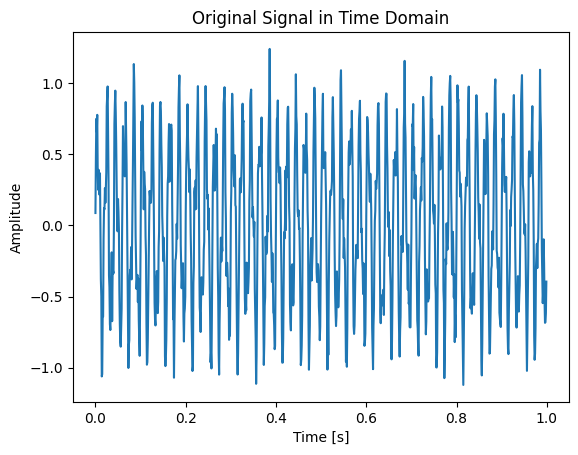

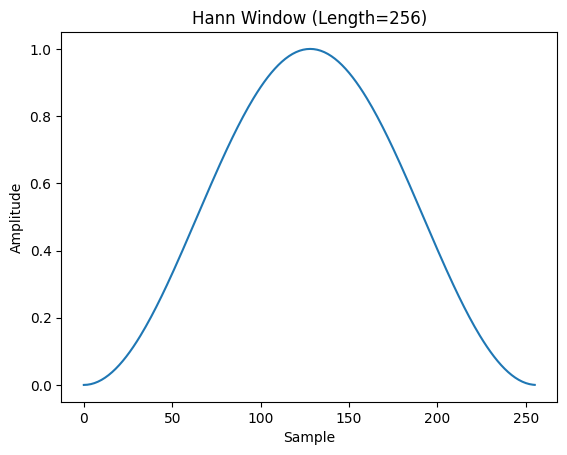

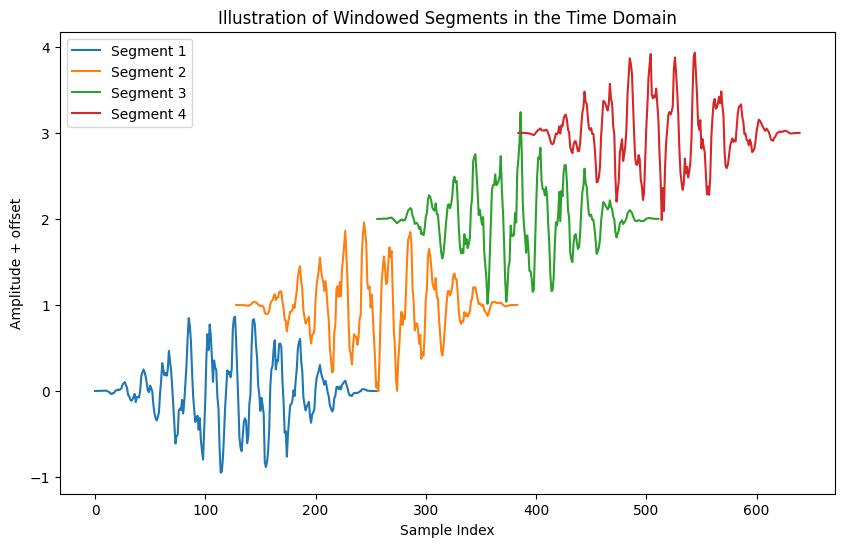

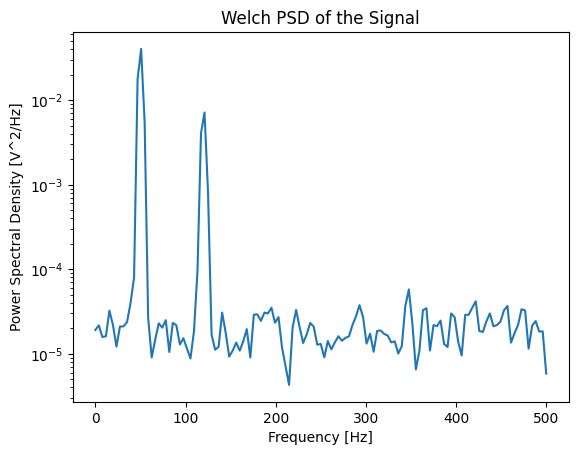

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, get_window

# -------------------------------
# 1) Create a Sample Signal
# -------------------------------
fs = 1000        # Sampling frequency [Hz]
T = 1.0          # Duration [s]
N = int(fs * T)  # Number of samples
t = np.linspace(0, T, N, endpoint=False)

# Signal: sum of two sinusoids + noise
x = 0.7 * np.sin(2 * np.pi * 50 * t) \
  + 0.3 * np.sin(2 * np.pi * 120 * t) \
  + 0.1 * np.random.randn(N)

# Plot the original signal
plt.figure()
plt.plot(t, x)
plt.title("Original Signal in Time Domain")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

# -------------------------------
# 2) Welch Parameters
# -------------------------------
nperseg = 256      # Samples per segment
noverlap = 128     # Overlap between segments
window_type = 'hann'
win = get_window(window_type, nperseg)
step = nperseg - noverlap  # Step size when sliding

# -------------------------------
# 3) Show the Window Shape
# -------------------------------
plt.figure()
plt.plot(win)
plt.title(f"{window_type.capitalize()} Window (Length={nperseg})")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

# -------------------------------
# 4) Illustrate Windowed Segments
# -------------------------------
# We'll plot the first few segments (windowed) on top of each other, 
# offset vertically so you can see how each segment is tapered by the window.

num_segments_to_show = 4
plt.figure(figsize=(10, 6))
for i in range(num_segments_to_show):
    start_idx = i * step
    end_idx = start_idx + nperseg
    # Avoid going beyond the signal length
    if end_idx > N:
        break
    # Extract the segment and apply the window
    segment = x[start_idx:end_idx]
    windowed_segment = segment * win
    
    vertical_offset = i * 1.0  # Shift each windowed segment up in the plot
    plt.plot(
        np.arange(start_idx, end_idx),
        windowed_segment + vertical_offset,
        label=f"Segment {i+1}"
    )

plt.title("Illustration of Windowed Segments in the Time Domain")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude + offset")
plt.legend()
plt.show()

# -------------------------------
# 5) Compute Welch PSD
# -------------------------------
# Welch automatically segments and windows the signal under the hood.
f, Pxx = welch(
    x,
    fs=fs,
    window=win,
    noverlap=noverlap,
    nperseg=nperseg
)

# -------------------------------
# 6) Plot the Welch PSD
# -------------------------------
plt.figure()
plt.semilogy(f, Pxx)
plt.title("Welch PSD of the Signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power Spectral Density [V^2/Hz]")
plt.show()


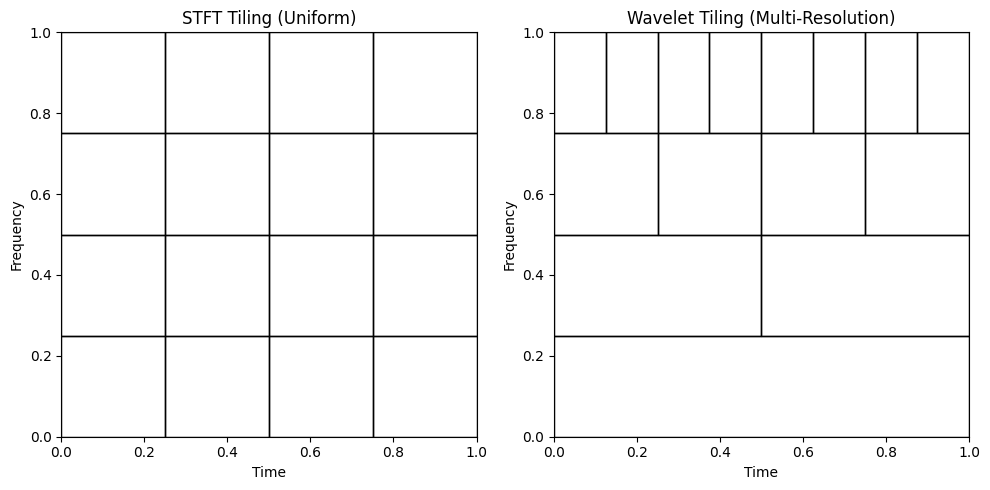

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_stft_tiling(ax, num_time_bins=4, num_freq_bins=4):
    """
    Draws uniform rectangular tiling to mimic STFT segmentation.
    """
    ax.set_title("STFT Tiling (Uniform)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Frequency")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    width = 1 / num_time_bins
    height = 1 / num_freq_bins
    
    for i in range(num_time_bins):
        for j in range(num_freq_bins):
            # Rectangle: (x_start, y_start, width, height)
            rect = Rectangle(
                (i * width, j * height),  # bottom-left corner
                width,
                height,
                fill=False,
                edgecolor='black'
            )
            ax.add_patch(rect)

def plot_wavelet_tiling(ax):
    """
    Draws a simplified 'wavelet-like' multi-resolution tiling:
      - Low frequency band = coarse time resolution
      - High frequency band = fine time resolution
    We'll break the [0,1] frequency axis into 4 sub-bands:
      (0 -> 0.25), (0.25 -> 0.5), (0.5 -> 0.75), (0.75 -> 1.0)
    And for each higher sub-band, we subdivide time more finely.
    """
    ax.set_title("Wavelet Tiling (Multi-Resolution)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Frequency")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    freq_bands = [
        (0.00, 0.25),
        (0.25, 0.50),
        (0.50, 0.75),
        (0.75, 1.00)
    ]
    # Number of time subdivisions for each band (lowest freq -> few subdivisions, highest -> many)
    time_divisions = [1, 2, 4, 8]
    
    for (f_low, f_high), t_div in zip(freq_bands, time_divisions):
        freq_height = f_high - f_low
        time_width = 1.0 / t_div
        
        for i in range(t_div):
            rect = Rectangle(
                (i * time_width, f_low),  # bottom-left corner in (time, freq)
                time_width,
                freq_height,
                fill=False,
                edgecolor='black'
            )
            ax.add_patch(rect)

# -----------------------------
# Main plotting
# -----------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# 1) STFT tiling: uniform rectangles in time-frequency plane
plot_stft_tiling(ax1, num_time_bins=4, num_freq_bins=4)

# 2) Wavelet tiling: multi-resolution approach
plot_wavelet_tiling(ax2)

plt.tight_layout()
plt.show()


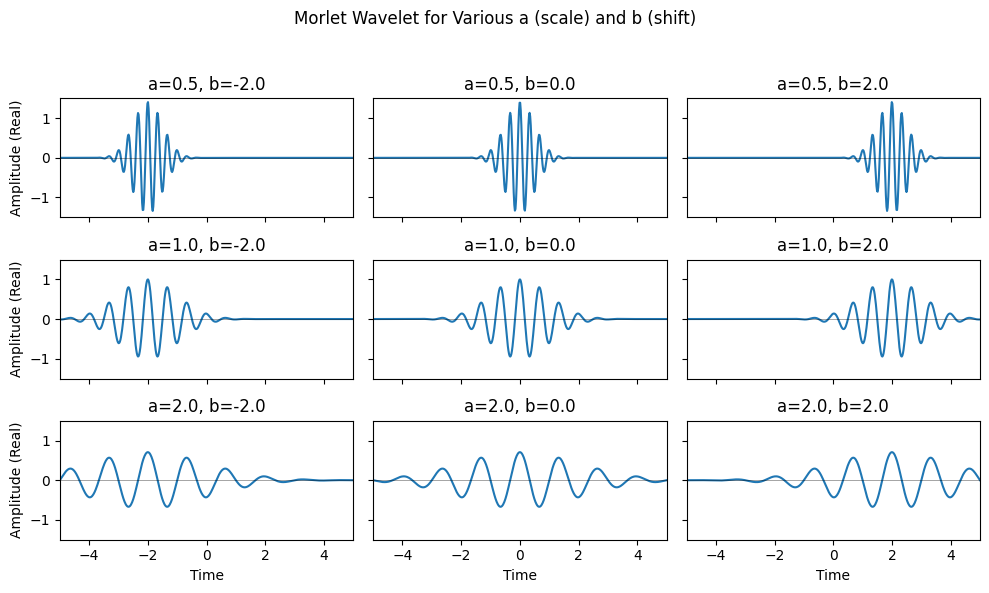

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def morlet_wavelet(t, f0=1.0):
    """
    A basic Morlet wavelet centered at t=0, scale=1.
    f0 controls the wavelet's center frequency.
    """
    # Morlet typically has a Gaussian envelope multiplied by a complex exponential.
    # Normalization is omitted or simplified for demonstration purposes.
    return np.exp(2j * np.pi * f0 * t) * np.exp(-t**2 / 2)

def psi_a_b(t, a, b, f0=1.0):
    """
    Returns the Morlet wavelet scaled by 'a' and shifted by 'b', i.e.:
        psi_{a,b}(t) = 1/sqrt(|a|) * psi((t - b)/a)
    """
    return (1.0 / np.sqrt(np.abs(a))) * morlet_wavelet((t - b)/a, f0=f0)

# -----------------------------------
# 1) Set Up Time Axis
# -----------------------------------
N = 500
t = np.linspace(-5, 5, N)

# We'll demo 3 scales and 3 shifts
a_values = [0.5, 1.0, 2.0]
b_values = [-2.0, 0.0, 2.0]

# Set a central frequency for the Morlet wavelet
f0 = 1.5  # you can adjust for more or fewer oscillations

# -----------------------------------
# 2) Plot the Real Part of Each Wavelet
# -----------------------------------
fig, axes = plt.subplots(len(a_values), len(b_values), figsize=(10, 6), sharex=True, sharey=True)
fig.suptitle("Morlet Wavelet for Various a (scale) and b (shift)")

for i, a in enumerate(a_values):
    for j, b in enumerate(b_values):
        ax = axes[i, j]
        
        # Compute wavelet
        wv = psi_a_b(t, a, b, f0=f0)
        
        # Plot its real part
        ax.plot(t, wv.real)
        ax.axhline(0, color='black', linewidth=0.5, alpha=0.5)
        
        ax.set_title(f"a={a}, b={b}")
        ax.set_xlim([-5, 5])
        ax.set_ylim([-1.5, 1.5])  # adjust as needed

        if i == len(a_values) - 1:
            ax.set_xlabel("Time")
        if j == 0:
            ax.set_ylabel("Amplitude (Real)")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


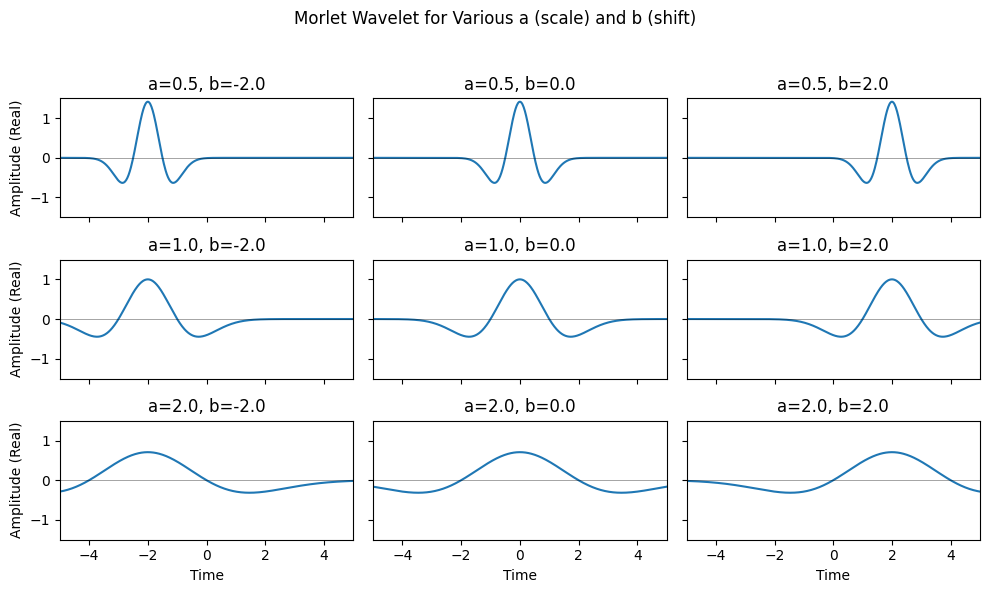

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def mexican_hat_wavelet(t):
    """
    A simplified version of the Mexican Hat (Ricker) wavelet:
       ψ(t) = (1 - t^2) * exp(-t^2 / 2)
    Omitting normalizing constants for demonstration.
    """
    return (1.0 - t**2) * np.exp(-t**2 / 2)

def psi_a_b(t, a, b):
    """
    Returns the Morlet wavelet scaled by 'a' and shifted by 'b', i.e.:
        psi_{a,b}(t) = 1/sqrt(|a|) * psi((t - b)/a)
    """
    return (1.0 / np.sqrt(np.abs(a))) * mexican_hat_wavelet((t - b)/a)

# -----------------------------------
# 1) Set Up Time Axis
# -----------------------------------
N = 500
t = np.linspace(-5, 5, N)

# We'll demo 3 scales and 3 shifts
a_values = [0.5, 1.0, 2.0]
b_values = [-2.0, 0.0, 2.0]

# -----------------------------------
# 2) Plot the Real Part of Each Wavelet
# -----------------------------------
fig, axes = plt.subplots(len(a_values), len(b_values), figsize=(10, 6), sharex=True, sharey=True)
fig.suptitle("Morlet Wavelet for Various a (scale) and b (shift)")

for i, a in enumerate(a_values):
    for j, b in enumerate(b_values):
        ax = axes[i, j]
        
        # Compute wavelet
        wv = psi_a_b(t, a, b)
        
        # Plot its real part
        ax.plot(t, wv.real)
        ax.axhline(0, color='black', linewidth=0.5, alpha=0.5)
        
        ax.set_title(f"a={a}, b={b}")
        ax.set_xlim([-5, 5])
        ax.set_ylim([-1.5, 1.5])  # adjust as needed

        if i == len(a_values) - 1:
            ax.set_xlabel("Time")
        if j == 0:
            ax.set_ylabel("Amplitude (Real)")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


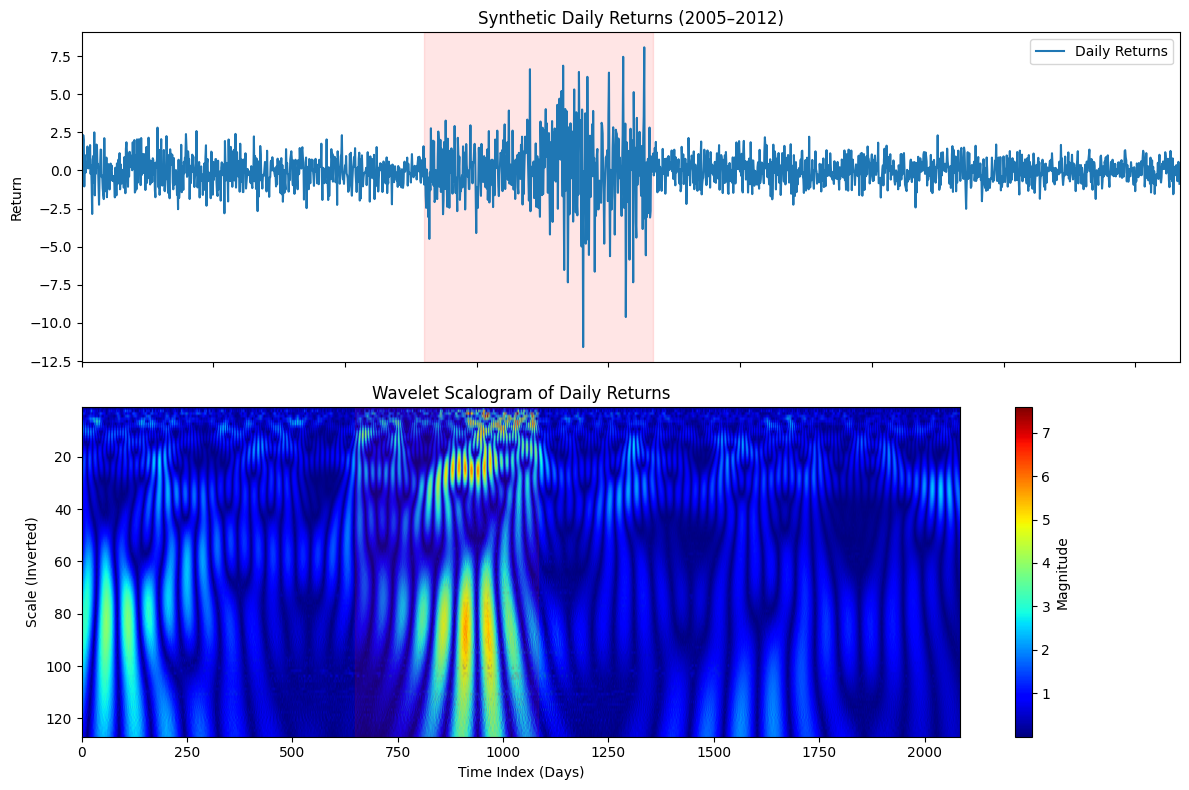

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt

# -------------------------------------------------
# 1) Create a Synthetic Daily "Stock Price" Series
# -------------------------------------------------
dates = pd.date_range('2005-01-01', '2012-12-31', freq='B')  # business days
N = len(dates)

np.random.seed(0)  # reproducibility

# Let's simulate a random walk for the "price"
price = np.zeros(N)
price[0] = 100.0  # start price

# We'll add a "volatility boost" during the 2007–2009 crisis window
crisis_start = pd.to_datetime('2007-07-01')
crisis_end   = pd.to_datetime('2009-03-01')

for i in range(1, N):
    current_date = dates[i]
    
    # baseline daily return noise
    daily_ret = np.random.normal(0, 0.01)
    
    # if inside crisis window, increase volatility
    if crisis_start <= current_date <= crisis_end:
        daily_ret += np.random.normal(0, 0.03)  # extra volatility
    
    price[i] = price[i - 1] * (1 + daily_ret)

# Convert to "daily returns" to highlight volatility changes
returns = np.diff(price)  # length N-1
time_idx = np.arange(len(returns))  # numeric index for plotting

# -------------------------------------------------
# 2) Continuous Wavelet Transform (Morlet)
# -------------------------------------------------
scales = np.arange(1, 128)  # range of scales
coeffs, freqs = pywt.cwt(returns, scales, 'morl')

# We'll take the absolute value for magnitude
cwt_magnitude = np.abs(coeffs)

# -------------------------------------------------
# 3) Plot Original Data and Wavelet Scalogram
# -------------------------------------------------
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# (A) Plot the daily returns
axes[0].plot(time_idx, returns, label='Daily Returns')
axes[0].set_title("Synthetic Daily Returns (2005–2012)")
axes[0].set_ylabel("Return")
axes[0].legend()

# Mark the crisis region with a vertical span
start_idx = np.searchsorted(time_idx, np.where(dates[1:] >= crisis_start)[0][0])
end_idx   = np.searchsorted(time_idx, np.where(dates[1:] >= crisis_end)[0][0])
axes[0].axvspan(start_idx, end_idx, color='red', alpha=0.1, label='Crisis')

# (B) Plot the wavelet scalogram
im = axes[1].imshow(
    cwt_magnitude,
    extent=[0, len(returns), scales.max(), scales.min()],
    aspect='auto',
    cmap='jet'
)
axes[1].set_title("Wavelet Scalogram of Daily Returns")
axes[1].set_xlabel("Time Index (Days)")
axes[1].set_ylabel("Scale (Inverted)")

# Add a vertical span in the scalogram for the crisis
axes[1].axvspan(start_idx, end_idx, color='red', alpha=0.1, label='Crisis')

# Add colorbar
cbar = plt.colorbar(im, ax=axes[1])
cbar.set_label("Magnitude")

plt.tight_layout()
plt.show()


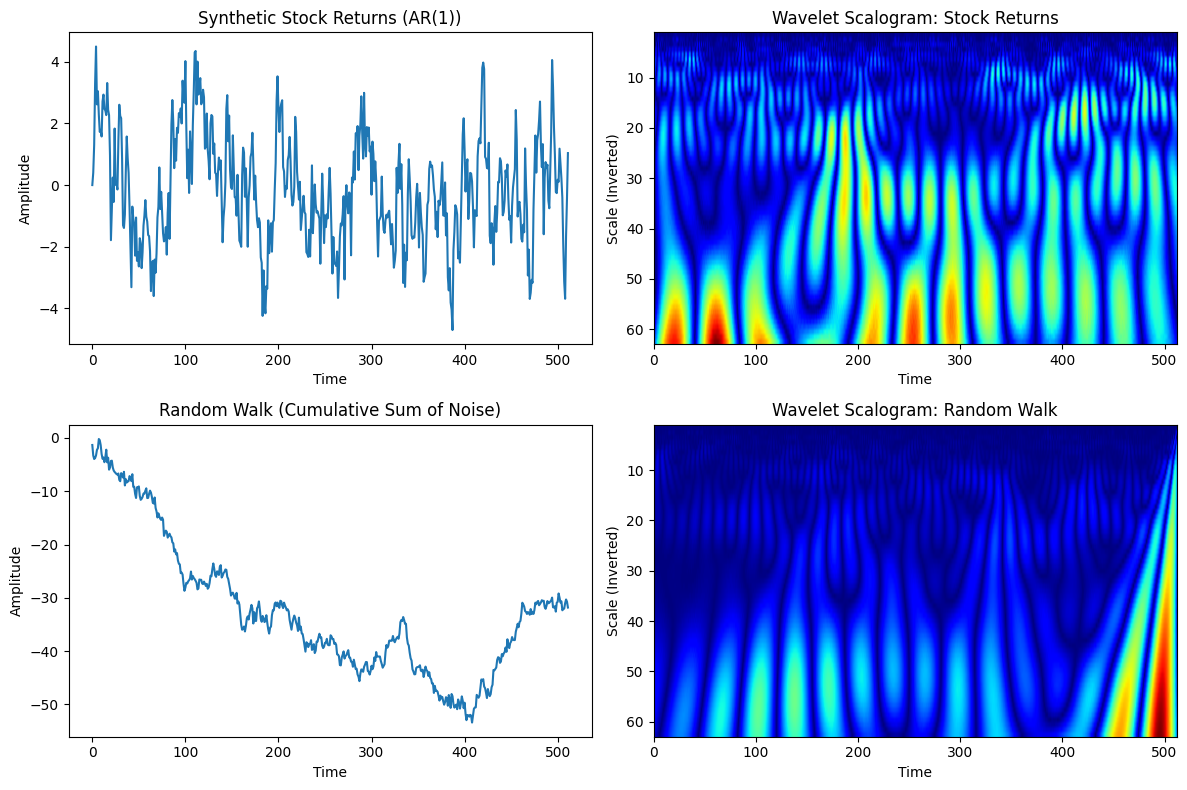

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# -----------------------------
# 1) Generate Synthetic Data
# -----------------------------
np.random.seed(0)   # for reproducibility
N = 512             # number of data points
time = np.arange(N)

# -- A) Synthetic "Stock Returns" (AR(1) process) --
alpha = 0.8
stock_returns = np.zeros(N)
noise = np.random.normal(0, 1, N)
for i in range(1, N):
    stock_returns[i] = alpha * stock_returns[i - 1] + noise[i]

# -- B) Random Walk --
#    Typically, random walks are used to model *prices* rather than *returns*,
#    but we'll demonstrate here for comparison.
random_walk = np.cumsum(np.random.normal(0, 1, N))

# -----------------------------
# 2) Continuous Wavelet Transform (CWT)
#    We'll use Morlet ('morl') wavelet for illustration.
# -----------------------------
scales = np.arange(1, 64)  # range of scales
coeffs_stock, freqs_stock = pywt.cwt(stock_returns, scales, 'morl')
coeffs_walk,  freqs_walk  = pywt.cwt(random_walk,  scales, 'morl')

# -----------------------------
# 3) Plot Time Series and Their Scalograms
# -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# (A) Stock Returns: Time-Domain
axes[0, 0].plot(time, stock_returns)
axes[0, 0].set_title("Synthetic Stock Returns (AR(1))")
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Amplitude")

# (A) Stock Returns: Wavelet Scalogram
#   We plot the absolute value of coefficients as an intensity map.
axes[0, 1].imshow(np.abs(coeffs_stock),
                  extent=[0, N, scales.max(), scales.min()],
                  aspect='auto', cmap='jet')
axes[0, 1].set_title("Wavelet Scalogram: Stock Returns")
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("Scale (Inverted)")

# (B) Random Walk: Time-Domain
axes[1, 0].plot(time, random_walk)
axes[1, 0].set_title("Random Walk (Cumulative Sum of Noise)")
axes[1, 0].set_xlabel("Time")
axes[1, 0].set_ylabel("Amplitude")

# (B) Random Walk: Wavelet Scalogram
axes[1, 1].imshow(np.abs(coeffs_walk),
                  extent=[0, N, scales.max(), scales.min()],
                  aspect='auto', cmap='jet')
axes[1, 1].set_title("Wavelet Scalogram: Random Walk")
axes[1, 1].set_xlabel("Time")
axes[1, 1].set_ylabel("Scale (Inverted)")

plt.tight_layout()
plt.show()


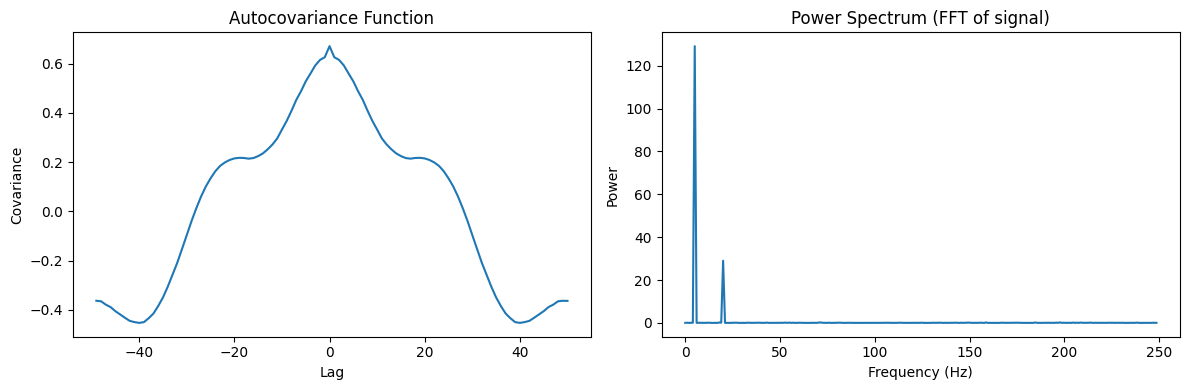

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Create a signal with two frequencies
np.random.seed(0)
t = np.linspace(0, 1, 500)
x = np.sin(2*np.pi*5*t) + 0.5*np.sin(2*np.pi*20*t) + 0.2*np.random.randn(500)

# 1) Compute autocovariance
x_centered = x - np.mean(x)
autocov = np.correlate(x_centered, x_centered, mode='full') / len(x)
lags = np.arange(-len(x)+1, len(x))

# 2) Compute power spectrum via FFT
fft_vals = np.fft.fft(x_centered)
psd = np.abs(fft_vals)**2 / len(x)

freqs = np.fft.fftfreq(len(x), d=t[1]-t[0])

# 3) Plot both
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(lags[len(x)-50:len(x)+50], autocov[len(x)-50:len(x)+50])
plt.title("Autocovariance Function")
plt.xlabel("Lag"); plt.ylabel("Covariance")

plt.subplot(1,2,2)
plt.plot(freqs[:len(freqs)//2], psd[:len(psd)//2])
plt.title("Power Spectrum (FFT of signal)")
plt.xlabel("Frequency (Hz)"); plt.ylabel("Power")
plt.tight_layout()
plt.show()
